# Imports

In [2]:
#%matplotlib widget
%matplotlib inline

import numpy as np
from random import randrange
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report,auc,r2_score,matthews_corrcoef
from catboost import CatBoostRegressor,CatBoostClassifier
from catboost.utils import get_roc_curve
import shap
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)
from sklearn import preprocessing
from catboost import Pool, cv
from scipy import stats
from sklearn import feature_selection as fs
from tabulate import tabulate
from scipy.optimize import curve_fit
from tqdm import tqdm
from numpy.random import RandomState
from scipy import stats
import os

In [3]:
import scipy.stats as stat
from scipy import stats
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

def print_coef(model, columns):
    """ Plot logistic regression model coefficients """ 
    coef = np.abs(pd.DataFrame(np.transpose(model.coef_), index = columns, columns = ['Coefficients']))
    coef = coef.sort_values(by=['Coefficients'], ascending=True)
    plt.figure(figsize = (6,18))
    plt.scatter(y = range(len(coef)), x = coef['Coefficients'])
    plt.yticks(range(len(coef)),coef.index, rotation = 'horizontal')
    plt.xlabel('LR coefficient')
    if present:
        ax = plt.gca()
        ax.patch.set_alpha(0)
    plt.show()
    #return coef
    
def print_coef_std_int(coefs,intercept, columns_feat):
    """ Plot logistic regression model coefficients """ 
    coef = pd.DataFrame(coefs, columns = columns_feat)
    #coef = coef.sort_values(by=['Coefficients'], ascending=True)
    
    quantile = p_values_null_coef(intercept)/100
    if quantile > 0.5:
        p_value_intercept = 1-quantile
    else:
        p_value_intercept = quantile


    p_values_coef = [p_value_intercept]
    for i in range(len(columns_feat)):
        quantile = p_values_null_coef(coefs[:,i])/100
        if quantile > 0.5:
            p_values_coef.append(1-quantile)
        else:
            p_values_coef.append(quantile)
    
    plt.figure(figsize = (6,9))
    plt.errorbar(x = np.append(intercept.mean(),coef.mean().values), y = range(len(columns_feat)+1), xerr = np.append(intercept.std(),coef.std()),ecolor=np.where(np.array(p_values_coef)<0.05,significant_color,non_significant_color), fmt='none')
    plt.axvline(x=0,color='black',alpha=0.5)
    plt.scatter(x = np.append(intercept.mean(),coef.mean().values), y = range(len(columns_feat)+1),color=np.where(np.array(p_values_coef)<0.05,significant_color,non_significant_color))
    plt.yticks(range(len(columns_feat)+1),np.append(["AF"],columns_feat), rotation = 'horizontal')
    plt.xlabel('Coefficient')
    if present:
        ax = plt.gca()
        ax.patch.set_alpha(0)
        leg = ax.legend(handles=legend_elements)
        leg.get_frame().set_alpha(0)
        for text in leg.get_texts():
            text.set_color("white")
    else:
        plt.legend(handles=legend_elements)
    plt.show()
    
def print_coef_std(coefs, columns_feat,lim):
    """ Plot logistic regression model coefficients """ 
    coef = pd.DataFrame(coefs, columns = columns_feat)
    #coef = coef.sort_values(by=['Coefficients'], ascending=True)

    p_values_coef = []
    for i in range(len(columns_feat)):
        quantile = p_values_null_coef(coefs[:,i])/100
        if quantile > 0.5:
            p_values_coef.append(1-quantile)
        else:
            p_values_coef.append(quantile)
    
    plt.figure(figsize = (6,9))
    plt.errorbar(x = coef.mean().values, y = range(len(columns_feat)), xerr = [coef.mean().values-coef.quantile(0.05),coef.quantile(0.95)-coef.mean().values],ecolor=np.where(np.array(p_values_coef)<0.05,significant_color,non_significant_color), fmt='none')
    plt.scatter(x = coef.mean().values, y = range(len(columns_feat)),color=np.where(np.array(p_values_coef)<0.05,significant_color,non_significant_color))
    plt.yticks(range(len(columns_feat)),columns_feat, rotation = 'horizontal')
    plt.xlabel('Coefficient')
    if present:
        ax = plt.gca()
        ax.patch.set_alpha(0)
        leg = ax.legend(handles=legend_elements)
        leg.get_frame().set_alpha(0)
        for text in leg.get_texts():
            text.set_color("white")
    else:
        plt.legend(handles=legend_elements)
    if lim>0:
        plt.xlim([-lim,lim])

    plt.show()
    
def p_values_lin_reg(model,X,y):
    model.fit(X,y)
    sse = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

    # compute the t-statistic for each feature
    t_test_val = model.coef_ / se
    # find the p-value for each feature
    p_value_lin = np.squeeze(2 * (1 - stat.t.cdf(np.abs(t_test_val), y.shape[0] - X.shape[1])))
    return p_value_lin

def p_values_null_coef(coefficients):
    #inverse of quantile
    return stats.percentileofscore(coefficients,0)

def p_values_arg_coef(coefficients,arg):
    #inverse of quantile
    return stats.percentileofscore(coefficients,arg)

def epsilon_PEHE(y_1,y_0,ITE):
    N = len(y_1)
    
    return 1/N * np.sum(((y_1-y_0)-(ITE))**2)


def epsilon_PEHE(y_1,y_0,ITE):
    N = len(y_1)
    
    return 1/N * np.sum(((y_1-y_0)-(ITE))**2)

def normalized_epsilon_PEHE(y_1,y_0,ITE):
    N = len(y_1)
    
    return 1/N * np.sum(((y_1-y_0)-(ITE))**2) * 1/(np.max(np.append(y_1,y_0))-np.min(np.append(y_1,y_0)))

def sqrt_epsilon_PEHE(y_1,y_0,ITE):
    return np.sqrt(epsilon_PEHE(y_1,y_0,ITE))


def sigmoid(x):
        return 1 / (1 + np.exp(-x))

# Simulation code

In [319]:
runs = 20

for i in range(runs):
    print("RUN: "+str(i)+"/"+str(runs))
    samples = 10000
    n_features = 10
    noise_level = 0.8#0.1

    x=np.random.multivariate_normal(np.zeros(n_features),0.5*(np.random.uniform(-1,1,(n_features,n_features))+np.transpose(np.random.uniform(-1,1,(n_features,n_features)))),(samples))

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    treatment_weights = np.random.uniform(-0.1,0.1,(n_features))
    treatment_noise = np.random.normal(0,noise_level)
    t_cond_x = np.random.binomial(1,sigmoid(np.matmul(x,treatment_weights)+treatment_noise))

    outcome_weights = np.random.uniform(-1,1,(n_features,2))
    outcome_noise = np.random.multivariate_normal(np.zeros(2),[[noise_level,0],[0,noise_level]],(samples))
    Y_cond_x = sigmoid(np.matmul(x,outcome_weights)+outcome_noise)
    Y_cond_x_labels = np.round(Y_cond_x)

    Y_treatment_outcomes = Y_cond_x_labels[:,0]#np.take(Y_cond_x_labels.flatten(),t_cond_x+2*np.arange(0,len(t_cond_x)))

    T0_idx_train,T0_idx_test = train_test_split(np.arange(0,samples)[t_cond_x==0],test_size=0.2)
    T1_idx_train,T1_idx_test = train_test_split(np.arange(0,samples)[t_cond_x==1],test_size=0.2)

    T0_X_train =  x[T0_idx_train]
    T0_X_test =  x[T0_idx_test]
    T0_y_train =  Y_treatment_outcomes[T0_idx_train]
    T0_y_test = Y_treatment_outcomes[T0_idx_test]
    T1_X_train = x[T1_idx_train]
    T1_X_test = x[T1_idx_test]
    T1_y_train = Y_treatment_outcomes[T1_idx_train]
    T1_y_test  = Y_treatment_outcomes[T1_idx_test]

    C_X_train = np.vstack((np.hstack((T0_X_train,np.zeros((len(T0_X_train),1)))),np.hstack((T1_X_train,np.zeros((len(T1_X_train),1))+1))))
    C_X_test_separate = np.vstack((T0_X_test,T1_X_test))
    C_X_test_T0 = np.hstack((C_X_test_separate,np.zeros((len(C_X_test_separate),1))))
    C_X_test_T1 = np.hstack((C_X_test_separate,np.zeros((len(C_X_test_separate),1))+1))
    C_y_train = np.append(T0_y_train,T1_y_train)
    C_y_test = np.append(T0_y_test,T1_y_test)

    T0_class_balance = [T0_y_train.sum()/len(T0_y_train),1-T0_y_train.sum()/len(T0_y_train)]
    T0_CB_model = CatBoostClassifier(verbose=False,iterations=250,class_weights=T0_class_balance)
    T0_CB_model.fit(Pool(T0_X_train,T0_y_train))

    T1_class_balance = [T1_y_train.sum()/len(T1_y_train),1-T1_y_train.sum()/len(T1_y_train)]
    T1_CB_model = CatBoostClassifier(verbose=False,iterations=250,class_weights=T1_class_balance)
    T1_CB_model.fit(Pool(T1_X_train,T1_y_train))

    #C_class_balance = [C_y_train.sum()/len(C_y_train),1-C_y_train.sum()/len(C_y_train)]
    #C_CB_model = CatBoostClassifier(verbose=False,iterations=250,class_weights=C_class_balance)
    #C_CB_model.fit(Pool(C_X_train,C_y_train))

    ITE = T1_CB_model.predict_proba(C_X_test_separate)[:,1]-T0_CB_model.predict_proba(C_X_test_separate)[:,1]
    #combo_ITE = C_CB_model.predict_proba(C_X_test_T1)[:,1]-C_CB_model.predict_proba(C_X_test_T0)[:,1]

    label_ITE = ITE

    X_lin_analysis = pd.DataFrame(C_X_test_separate)

    print("E PEHE = "+str(epsilon_PEHE(Y_cond_x[np.append(T0_idx_test,T1_idx_test),1],Y_cond_x[np.append(T0_idx_test,T1_idx_test),0],label_ITE)))

    from sklearn.linear_model import LinearRegression, LogisticRegression
    intercept = []
    r2s = []
    coefs = np.array([])
    loops = 1000
    for i in range(loops):#(1000):
        if i%250==0:
            print("\r Iteration "+str(i)+"/"+str(loops),end='')
        train_X_LinReg = X_lin_analysis.reset_index(drop=True).sample(int(len(X_lin_analysis)*0.67),random_state=i)
        train_Y_LinReg = label_ITE[train_X_LinReg.index.values]
        Lin_ITE = LinearRegression().fit(train_X_LinReg.values,train_Y_LinReg)
        #r2s.append(r2_score(ITE,Lin_ITE.predict(X_test_ITE_lin_reg.values)))
        intercept.append(Lin_ITE.intercept_)
        if len(coefs)==0:
            coefs = Lin_ITE.coef_
        else:
            coefs = np.vstack([coefs,Lin_ITE.coef_])
    intercept = np.array(intercept)        

    print("")
    quantile = p_values_null_coef(intercept)/100
    if quantile > 0.5:
        p_value = 1-quantile
    else:
        p_value = quantile
    significant_string = "" if (np.round(p_value,3)>0.05) else 20*"-"+">  " 
    print(significant_string+"TREATMENT: "+str(np.round(p_value,3)))
    print("Intercept = "+str(np.mean(intercept))+" (+-"+str(np.std(intercept))+")")

    for i in range(len(X_lin_analysis.columns)):
        quantile = p_values_null_coef(coefs[:,i])/100
        if quantile > 0.5:
            p_value = 1-quantile
        else:
            p_value = quantile
        significant_string = "" if (np.round(p_value,3)>0.05) else 20*"-"+">  "
        print(significant_string+str(X_lin_analysis.columns[i])+": "+str(np.round(p_value,3)))
    print(100*"=")

RUN: 0/20


covariance is not positive-semidefinite.


E PEHE = 0.23973297392500845
 Iteration 750/1000
-------------------->  TREATMENT: 0.002
Intercept = 0.005745016581581927 (+-0.0018894680436443798)
-------------------->  0: 0.001
-------------------->  1: 0.0
2: 0.379
3: 0.346
4: 0.243
-------------------->  5: 0.008
-------------------->  6: 0.0
-------------------->  7: 0.0
-------------------->  8: 0.0
-------------------->  9: 0.0
RUN: 1/20


covariance is not positive-semidefinite.


KeyboardInterrupt: 

In [ ]:
print_bool = False
if print_bool:
    print("")
    print("T0 TRAIN")
    print(classification_report(T0_y_train,T0_CB_model.predict(T0_X_train)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(T0_CB_model, Pool(data=T0_X_train,label=T0_y_train), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T0_y_train,T0_CB_model.predict(T0_X_train)),4)))
    print(50*"=")


    print("T1 TRAIN")
    print(classification_report(T1_y_train,T1_CB_model.predict(T1_X_train)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(T1_CB_model, Pool(data=T1_X_train,label=T1_y_train), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T1_y_train,T1_CB_model.predict(T1_X_train)),4)))
    print(50*"=")

    print("COMBO TRAIN")
    print(classification_report(C_y_train,C_CB_model.predict(C_X_train)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(C_CB_model, Pool(data=C_X_train,label=C_y_train), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(C_y_train,C_CB_model.predict(C_X_train)),4)))
    print(50*"=")

    print("T0 TEST")
    print(classification_report(T0_y_test,T0_CB_model.predict(T0_X_test)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(T0_CB_model, Pool(data=T0_X_test,label=T0_y_test), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T0_y_test,T0_CB_model.predict(T0_X_test)),4)))
    print(50*"=")

    print("T1 TEST")
    print(classification_report(T1_y_test,T1_CB_model.predict(T1_X_test)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(T1_CB_model, Pool(data=T1_X_test,label=T1_y_test), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T1_y_test,T1_CB_model.predict(T1_X_test)),4)))
    print(50*"=")

    C_X_test_sep_T0 = np.hstack((T0_X_test,np.zeros((len(T0_X_test),1))))
    print("COMBO TEST T0")
    print(classification_report(T0_y_test,C_CB_model.predict(C_X_test_sep_T0)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(C_CB_model, Pool(data=C_X_test_sep_T0,label=T0_y_test), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T0_y_test,C_CB_model.predict(C_X_test_sep_T0)),4)))
    print(50*"=")

    C_X_test_sep_T1 = np.hstack((T1_X_test,np.zeros((len(T1_X_test),1))+1))
    print("COMBO TEST T1")
    print(classification_report(T1_y_test,C_CB_model.predict(C_X_test_sep_T1)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(C_CB_model, Pool(data=C_X_test_sep_T1,label=T1_y_test), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T1_y_test,C_CB_model.predict(C_X_test_sep_T1)),4)))
    print(50*"=")

# TWINS DATASET

## Loading Data and preprocessing

In [ ]:
#The covariates data has 46 features
x = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/TWINS/twin_pairs_X_3years_samesex.csv")

#The outcome data contains mortality of the lighter and heavier twin
y = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/TWINS/twin_pairs_Y_3years_samesex.csv")

#The treatment data contains weight in grams of both the twins
t = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/TWINS/twin_pairs_T_3years_samesex.csv")

In [ ]:
selection_bias = True

MEAN MORT 1 : 0.1635940873609035
MEAN MORT 0 : 0.18875602059458563
ATE -0.025161933233682127
ITE STD 0.319516317500626
Treatment selection of T1: 0.6315396113602392


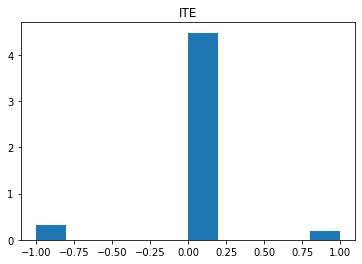

In [ ]:
#_0 denotes features specific to the lighter twin and _1 denotes features specific to the heavier twin
lighter_columns = ['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
        'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
        'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
        'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
        'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
        'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
        'data_year', 'nprevistq', 'dfageq', 'feduc6', #'infant_id_0',
        'dlivord_min', 'dtotord_min', 'bord_0','random_uniform_feature',
        'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']
heavier_columns = [ 'pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
        'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
        'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
        'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
        'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
        'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
        'data_year', 'nprevistq', 'dfageq', 'feduc6',#'infant_id_1', 
        'dlivord_min', 'dtotord_min', 'bord_1','random_uniform_feature',
        'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']

#heavier_columns = ['gestat10', 'nprevistq', 'csex', 'hydra','random_uniform_feature']
#lighter_columns = ['gestat10', 'nprevistq', 'csex', 'hydra','random_uniform_feature']

Exclude_features = ["infant_id_1","infant_id_0",""]

x.columns
x = x[['pldel', 'birattnd', 'brstate',
       'stoccfipb', 'mager8', 'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir',
       'mpre5', 'adequacy', 'orfath', 'frace', 'birmon', 'gestat10', 'csex',
       'anemia', 'cardiac', 'lung', 'diabetes', 'herpes', 'hydra', 'hemo',
       'chyper', 'phyper', 'eclamp', 'incervix', 'pre4000', 'preterm', 'renal',
       'rh', 'uterine', 'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5',
       'crace', 'data_year', 'nprevistq', 'dfageq', 'feduc6', 'infant_id_0',
       'infant_id_1', 'dlivord_min', 'dtotord_min', 'bord_0', 'bord_1',
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']]
dataset = x.copy(deep=True)
dataset["mort_0"]=y.mort_0
dataset["mort_1"]=y.mort_1
dataset["dbirwt_0"]=t.dbirwt_0
dataset["dbirwt_1"]=t.dbirwt_1

#select only if both <=2kg
dataset = dataset[(dataset.dbirwt_0<=2000) & (dataset.dbirwt_1<=2000)]
dataset["lightest_baby"]=0
dataset.loc[dataset.dbirwt_0>dataset.dbirwt_1,"lightest_baby"]=1

print("MEAN MORT 1 : "+str(np.mean(dataset["mort_1"])))
print("MEAN MORT 0 : "+str(np.mean(dataset["mort_0"])))
print("ATE", np.mean(dataset["mort_1"])- np.mean(dataset["mort_0"]))
print("ITE STD", np.std(dataset["mort_1"]- dataset["mort_0"]))
plt.hist(dataset["mort_1"]-dataset["mort_0"],density=True)
plt.title("ITE")

if not selection_bias:
    treatment_observation_arr = np.random.randint(0,2,len(dataset))
else:
    #ADD SELECTION BIAS
    noise_level = 0.1
    feat = ['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
           'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
           'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
           'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
           'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
           'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
           'data_year', 'nprevistq', 'dfageq', 'feduc6',
           'dlivord_min', 'dtotord_min',
           'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']
    n_features = len(feat)
    treatment_observation_arr = np.zeros(len(dataset))
    while np.mean(treatment_observation_arr) < 0.25 or np.mean(treatment_observation_arr) > 0.75:
        treatment_weights = np.random.uniform(-0.1,0.1,(n_features))*10
        r = np.round(np.random.uniform(0,2,n_features)-1)
        r[np.where(r<0)] = 0
        treatment_weights = treatment_weights*r
        treatment_noise = 0#np.random.normal(0,noise_level)
        treatment_observation_arr = np.random.binomial(1,sigmoid(np.matmul(dataset[feat].fillna(0).values,treatment_weights)*5+treatment_noise))  
    
dataset["treatment"]=treatment_observation_arr
print("Treatment selection of T1: "+str(sum(treatment_observation_arr)/len(treatment_observation_arr)))

In [ ]:
feat = ['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
        'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
        'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
        'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
        'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
        'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
        'data_year', 'nprevistq', 'dfageq', 'feduc6',
        'dlivord_min', 'dtotord_min',
        'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']

In [ ]:
dataset = dataset.reset_index()
dataset = dataset.rename(columns={"index":"childid"})

In [ ]:
np.mean(dataset[treatment_observation_arr==1].mort_1.values) - np.mean(dataset[treatment_observation_arr==0].mort_0.values)

-0.03441847935528697

In [ ]:
np.mean(dataset.mort_1.values) - np.mean(dataset.mort_0.values)

-0.025161933233682127

In [ ]:
# ATEs = []
# for i in range(10000):
#     if i%100==0:
#         print("\r"+str(i),end="")
#     sampled_dataset = dataset.sample(int(0.2*len(dataset)),replace=False,random_state=i)
#     ATEs.append(np.mean(sampled_dataset["mort_1"])- np.mean(sampled_dataset["mort_0"]))

# print("")
# print(np.mean(np.array(ATEs)))

In [ ]:
dataset["mort"] = 0
dataset.loc[dataset.treatment==1,"mort"] = dataset[dataset.treatment==1].mort_1
dataset.loc[dataset.treatment==0,"mort"] = dataset[dataset.treatment==0].mort_0

dataset["bord"] = 0
dataset.loc[dataset.treatment==1,"bord"] = dataset[dataset.treatment==1].bord_1
dataset.loc[dataset.treatment==0,"bord"] = dataset[dataset.treatment==0].bord_0

dataset["infant_id"] = 0
dataset.loc[dataset.treatment==1,"infant_id"] = dataset[dataset.treatment==1].infant_id_1
dataset.loc[dataset.treatment==0,"infant_id"] = dataset[dataset.treatment==0].infant_id_0

dataset["dbirwt"] = 0
dataset.loc[dataset.treatment==1,"dbirwt"] = dataset[dataset.treatment==1].dbirwt_1
dataset.loc[dataset.treatment==0,"dbirwt"] = dataset[dataset.treatment==0].dbirwt_0

In [ ]:
dataset_or = dataset.copy(deep=True)

In [ ]:
columns_list = ['pldel', 'birattnd', 'brstate',
       'stoccfipb', 'mager8', 'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir',
       'mpre5', 'adequacy', 'orfath', 'frace', 'birmon', 'gestat10', 'csex',
       'anemia', 'cardiac', 'lung', 'diabetes', 'herpes', 'hydra', 'hemo',
       'chyper', 'phyper', 'eclamp', 'incervix', 'pre4000', 'preterm', 'renal',
       'rh', 'uterine', 'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5',
       'crace', 'data_year', 'nprevistq', 'dfageq', 'feduc6', 'dlivord_min', 'dtotord_min', 'bord',
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']

In [ ]:
from causallib.estimation import IPW 

ipw = IPW(CatBoostClassifier(n_estimators=250,verbose=100))
ipw.fit(dataset[columns_list], dataset["treatment"])
potential_outcomes = ipw.estimate_population_outcome(dataset[columns_list], dataset["treatment"], dataset["mort"])
effect = ipw.estimate_effect(potential_outcomes[1], potential_outcomes[0])
effect

Learning rate set to 0.106287
0:	learn: 0.6181804	total: 33.2ms	remaining: 8.26s
100:	learn: 0.3016951	total: 462ms	remaining: 681ms
200:	learn: 0.2649208	total: 900ms	remaining: 219ms
249:	learn: 0.2489425	total: 1.08s	remaining: 0us


diff   -0.013591
dtype: float64

In [ ]:
import sys
sys.path.append("../../causalteshap/")
from causalteshap import CausalTeShap

In [ ]:
ATEs = []
for i in range(10000):
    if i%100==0:
        print("\r"+str(i),end="")
    d_temp = dataset.reset_index(drop=True)

    train_idx, val_idx = train_test_split(
        np.arange(len(d_temp)),
        test_size=0.2,
        random_state=i,
    )

    ATEs.append(np.mean(d_temp.iloc[np.sort(val_idx)].mort_1.values-d_temp.iloc[np.sort(val_idx)].mort_0.values))

print("")
print(np.mean(np.array(ATEs)))

9900
-0.02513615608136156


In [ ]:
matched_X, prev_auc,after_auc = causal_selector.propensity_matching(
    dataset[columns_list],
                    dataset.mort.values,dataset["treatment"].values
)

In [ ]:
match_dataset = dataset.iloc[matched_X]

np.mean(np.mean(match_dataset[match_dataset["treatment"]==1].mort.values)-np.mean(match_dataset[match_dataset["treatment"]==0].mort.values))

-0.020298317712979963

In [ ]:
causal_selector = CausalTeShap(CatBoostClassifier,iterations=10,meta_learner=True,power_alpha=0.01,verbose=True,classification=True)

causal_selector.fit(dataset[columns_list],
                    dataset.mort.values,dataset["treatment"].values,propensity_matching=True)

causal_selector.show_all_causality_information()

-0.018480018480018484
-0.018767377201112156
-0.01824059108750864
-0.03014018691588785
-0.02251624883936862
-0.020369936782954817
-0.017400721756553467
-0.02034211742949607
-0.020847810979847115
-0.017923001224815327

Done
Propensity matching was included in fitting - Propensity information: 

Before matching auc 	 | mean (std) = 0.5015 (0.0068)
After matching auc 	 | mean (std) = 0.5015 (0.0056)
T0 amount of class 1 samples 	 |  807 samples = 18.71% of all matched 4314 samples
T1 amount of class 1 samples 	 | 718 samples = 16.66% of all matched 4315 samples

Causality information:
TRAIN: 	 CATE = -0.0322212793955799 	| p-value = 0.0
VAL: 	 CATE = -0.03286403184308402 	| p-value = 0.0
CATE shap stats
----------------------------------------------------------------------
|             |       impact |   p_value |
|:------------|-------------:|----------:|
| T           | -0.250699    |         0 |
| csex        |  0.0202758   |         0 |
| gestat10    |  0.0141057   |         0 |
| dat

## Linear analysis on the ground truth

In [ ]:
add_nan_features = False
lin_anal_loops = 1000
samples = 5000

dataset_linal = dataset.sample(samples)
linal_treatment_observation_arr = np.random.randint(0,2,len(dataset_linal))

X_lin_analysis = dataset_linal[linal_treatment_observation_arr==0][lighter_columns].rename(columns={'infant_id_0':'infant_id',  'bord_0':'bord'})
X_lin_analysis = X_lin_analysis.append(dataset_linal[linal_treatment_observation_arr==1][heavier_columns].rename(columns={'infant_id_1':'infant_id',  'bord_1':'bord'}))
label_ITE = dataset_linal[linal_treatment_observation_arr==0].mort_1.values - dataset_linal[linal_treatment_observation_arr==0].mort_0.values
label_ITE = np.append(label_ITE,dataset_linal[linal_treatment_observation_arr==1].mort_1.values - dataset_linal[linal_treatment_observation_arr==1].mort_0.values)
print(np.mean(label_ITE))

if add_nan_features:
    possible_NaN_features = ['pldel', 'birattnd', 'ormoth',  'meduc6', 'mplbir',
    'mpre5', 'adequacy', 'orfath', 'frace', 
    'anemia', 'cardiac', 'lung', 'diabetes', 'herpes', 'hydra', 'hemo',
    'chyper', 'phyper', 'eclamp', 'incervix', 'pre4000', 'preterm', 'renal',
    'rh', 'uterine', 'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5',
    'nprevistq', 'dfageq', 'feduc6',  'dlivord_min', 'dtotord_min', 'bord', 
    'mplbir_reg']

    for feat in possible_NaN_features:
        X_lin_analysis[feat+"_NaN"]=0
        X_lin_analysis.loc[X_lin_analysis[feat].isna(),feat+"_NaN"]=1

X_lin_analysis = X_lin_analysis.fillna(X_lin_analysis.mean())

from sklearn.linear_model import LinearRegression, LogisticRegression
intercept = []
r2s = []
coefs = np.array([])
for i in range(lin_anal_loops):#(1000):
    if i%250==0:
        print("\r Iteration "+str(i)+"/"+str(lin_anal_loops),end='')
    train_X_LinReg = X_lin_analysis.reset_index(drop=True).sample(int(len(X_lin_analysis)*0.67),random_state=i)
    train_Y_LinReg = label_ITE[train_X_LinReg.index.values]
    Lin_ITE = LinearRegression().fit(train_X_LinReg.values,train_Y_LinReg)
    #r2s.append(r2_score(ITE,Lin_ITE.predict(X_test_ITE_lin_reg.values)))
    intercept.append(Lin_ITE.intercept_)
    if len(coefs)==0:
        coefs = Lin_ITE.coef_
    else:
        coefs = np.vstack([coefs,Lin_ITE.coef_])
intercept = np.array(intercept)        

print("")
quantile = p_values_null_coef(intercept)/100
if quantile > 0.5:
    p_value = 1-quantile
else:
    p_value = quantile
significant_string = "" if (np.round(p_value,3)>0.05) else 20*"-"+">  " 
print(significant_string+"TREATMENT: "+str(np.round(p_value,3)))
print("Intercept = "+str(np.mean(intercept))+" (+-"+str(np.std(intercept))+")")

for i in range(len(X_lin_analysis.columns)):
    quantile = p_values_null_coef(coefs[:,i])/100
    if quantile > 0.5:
        p_value = 1-quantile
    else:
        p_value = quantile
    significant_string = "" if (np.round(p_value,3)>0.05) else 20*"-"+">  "
    print(significant_string+str(X_lin_analysis.columns[i])+": "+str(np.round(p_value,3)))
print(100*"=")

## Linear Analysis on Catboost ITE estimation (both shared and separate response surfaces)

In [ ]:
add_nan_features = False
verbose_bool = False
do_lin_al = True
combo = False
pehes = []
ITEs = []
runs = 10
lin_anal_loops = 1000

for i in range(runs):
    print("\r run "+str(i)+"/"+str(runs),end="")
    #samples = 10000
    #n_features = 10
    #noise_level = 0.8#0.1

    #treatment_weights = np.random.uniform(-0.1,0.1,(n_features))
    #treatment_noise = np.random.normal(0,noise_level)
    #t_cond_x = np.random.binomial(1,sigmoid(np.matmul(x,treatment_weights)+treatment_noise))

    T0_train_dataset,T0_test_dataset = train_test_split(dataset[treatment_observation_arr==0],test_size=0.2,random_state=i)
    T0_train_dataset,T0_val_dataset = train_test_split(T0_train_dataset,test_size=0.3,random_state=42)

    T1_train_dataset,T1_test_dataset = train_test_split(dataset[treatment_observation_arr==1],test_size=0.2,random_state=i)
    T1_train_dataset,T1_val_dataset = train_test_split(T1_train_dataset,test_size=0.3,random_state=42)

    T0_X_train =  T0_train_dataset[lighter_columns]
    T0_X_val =  T0_val_dataset[lighter_columns]
    T0_X_test =  T0_test_dataset[lighter_columns]
    T0_X_train = T0_X_train.rename(columns={'infant_id_0':'infant_id',  'bord_0':'bord'})
    T0_X_val = T0_X_val.rename(columns={'infant_id_0':'infant_id',  'bord_0':'bord'})
    T0_X_test = T0_X_test.rename(columns={'infant_id_0':'infant_id',  'bord_0':'bord'})

    T0_y_train =  T0_train_dataset["mort_0"]
    T0_y_val =  T0_val_dataset["mort_0"]
    T0_y_test = T0_test_dataset["mort_0"]

    T1_X_train = T1_train_dataset[heavier_columns]
    T1_X_val = T1_val_dataset[heavier_columns]
    T1_X_test = T1_test_dataset[heavier_columns]
    T1_X_train = T1_X_train.rename(columns={'infant_id_1':'infant_id',  'bord_1':'bord'})
    T1_X_val = T1_X_val.rename(columns={'infant_id_1':'infant_id',  'bord_1':'bord'})
    T1_X_test = T1_X_test.rename(columns={'infant_id_1':'infant_id',  'bord_1':'bord'})

    T1_y_train = T1_train_dataset["mort_1"]
    T1_y_val = T1_val_dataset["mort_1"]
    T1_y_test  = T1_test_dataset["mort_1"]
    
    X_test_separate = np.vstack((T0_X_test,T1_X_test))
    
    if combo:
        C_X_train = np.vstack((np.hstack((T0_X_train,np.zeros((len(T0_X_train),1)))),np.hstack((T1_X_train,np.zeros((len(T1_X_train),1))+1))))
        C_X_val = np.vstack((np.hstack((T0_X_val,np.zeros((len(T0_X_val),1)))),np.hstack((T1_X_val,np.zeros((len(T1_X_val),1))+1))))
        C_X_test_T0 = np.hstack((X_test_separate,np.zeros((len(X_test_separate),1))))
        C_X_test_T1 = np.hstack((X_test_separate,np.zeros((len(X_test_separate),1))+1))
        C_y_train = np.append(T0_y_train,T1_y_train)
        C_y_val = np.append(T0_y_val,T1_y_val)
        C_y_test = np.append(T0_y_test,T1_y_test)

    if not combo:
        T0_class_balance = [T0_y_train.sum()/len(T0_y_train),1-T0_y_train.sum()/len(T0_y_train)]
        T0_CB_model = CatBoostClassifier(verbose=verbose_bool,iterations=100,class_weights=T0_class_balance,use_best_model=True)
        T0_CB_model.fit(Pool(T0_X_train,T0_y_train),eval_set=(T0_X_val,T0_y_val))

        T1_class_balance = [T1_y_train.sum()/len(T1_y_train),1-T1_y_train.sum()/len(T1_y_train)]
        T1_CB_model = CatBoostClassifier(verbose=verbose_bool,iterations=100,class_weights=T1_class_balance,use_best_model=True)
        T1_CB_model.fit(Pool(T1_X_train,T1_y_train),eval_set=(T1_X_val,T1_y_val))
        
        label_ITE = T1_CB_model.predict_proba(X_test_separate)[:,1]-T0_CB_model.predict_proba(X_test_separate)[:,1]

    else:
        C_class_balance = [C_y_train.sum()/len(C_y_train),1-C_y_train.sum()/len(C_y_train)]
        C_CB_model = CatBoostClassifier(verbose=verbose_bool,iterations=100,class_weights=C_class_balance,use_best_model=True)
        C_CB_model.fit(Pool(C_X_train,C_y_train),eval_set=(C_X_val,C_y_val))
        
        label_ITE = C_CB_model.predict_proba(C_X_test_T1)[:,1]-C_CB_model.predict_proba(C_X_test_T0)[:,1]

    print("")
    print(np.mean(label_ITE))
    pehes_temp = sqrt_epsilon_PEHE(np.append(T0_test_dataset["mort_1"],T1_test_dataset["mort_1"]),np.append(T0_test_dataset["mort_0"],T1_test_dataset["mort_0"]),label_ITE)
    pehes.append(pehes_temp)
    #print("SQRT(E_PEHE) = "+str(pehes_temp))

    if do_lin_al:
        possible_NaN_features = ['pldel', 'birattnd', 'ormoth',  'meduc6', 'mplbir',
           'mpre5', 'adequacy', 'orfath', 'frace', 
           'anemia', 'cardiac', 'lung', 'diabetes', 'herpes', 'hydra', 'hemo',
           'chyper', 'phyper', 'eclamp', 'incervix', 'pre4000', 'preterm', 'renal',
           'rh', 'uterine', 'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5',
            'nprevistq', 'dfageq', 'feduc6',  'dlivord_min', 'dtotord_min', 'bord', 
            'mplbir_reg']

        X_train_T1_lin_reg = T1_X_train.copy(deep=True)
        X_test_T1_lin_reg = T1_X_test.copy(deep=True)
        X_train_T0_lin_reg = T0_X_train.copy(deep=True)
        X_test_T0_lin_reg = T0_X_test.copy(deep=True)

        if add_nan_features:
            for feat in possible_NaN_features:
                X_train_T1_lin_reg[feat+"_NaN"]=0
                X_train_T1_lin_reg.loc[X_train_T1_lin_reg[feat].isna(),feat+"_NaN"]=1

                X_test_T1_lin_reg[feat+"_NaN"]=0
                X_test_T1_lin_reg.loc[X_test_T1_lin_reg[feat].isna(),feat+"_NaN"]=1

                X_train_T0_lin_reg[feat+"_NaN"]=0
                X_train_T0_lin_reg.loc[X_train_T0_lin_reg[feat].isna(),feat+"_NaN"]=1

                X_test_T0_lin_reg[feat+"_NaN"]=0
                X_test_T0_lin_reg.loc[X_test_T0_lin_reg[feat].isna(),feat+"_NaN"]=1


        X_train_T1_lin_reg = X_train_T1_lin_reg.fillna(0)
        X_test_T1_lin_reg = X_test_T1_lin_reg.fillna(0)
        X_train_T0_lin_reg = X_train_T0_lin_reg.fillna(0)
        X_test_T0_lin_reg = X_test_T0_lin_reg.fillna(0)  

        X_lin_analysis = X_test_T1_lin_reg.append(X_test_T0_lin_reg).sample(len(X_test_T1_lin_reg)+len(X_test_T0_lin_reg),random_state=42)

        #X_lin_analysis = pd.DataFrame(C_X_test_separate)


        from sklearn.linear_model import LinearRegression, LogisticRegression
        intercept = []
        r2s = []
        coefs = np.array([])
        for i in range(lin_anal_loops):#(1000):
            if i%250==0:
                print("\r Iteration "+str(i)+"/"+str(lin_anal_loops),end='')
            train_X_LinReg = X_lin_analysis.reset_index(drop=True).sample(int(len(X_lin_analysis)*0.67),random_state=i)
            train_Y_LinReg = label_ITE[train_X_LinReg.index.values]
            Lin_ITE = LinearRegression().fit(train_X_LinReg.values,train_Y_LinReg)
            #r2s.append(r2_score(ITE,Lin_ITE.predict(X_test_ITE_lin_reg.values)))
            intercept.append(Lin_ITE.intercept_)
            if len(coefs)==0:
                coefs = Lin_ITE.coef_
            else:
                coefs = np.vstack([coefs,Lin_ITE.coef_])
        intercept = np.array(intercept)        

        print("")
        quantile = p_values_null_coef(intercept)/100
        if quantile > 0.5:
            p_value = 1-quantile
        else:
            p_value = quantile
        significant_string = "" if (np.round(p_value,3)>0.05) else 20*"-"+">  " 
        print(significant_string+"TREATMENT: "+str(np.round(p_value,3)))
        print("Intercept = "+str(np.mean(intercept))+" (+-"+str(np.std(intercept))+")")

        for i in range(len(X_lin_analysis.columns)):
            quantile = p_values_null_coef(coefs[:,i])/100
            if quantile > 0.5:
                p_value = 1-quantile
            else:
                p_value = quantile
            significant_string = "" if (np.round(p_value,3)>0.05) else 20*"-"+">  "
            print(significant_string+str(X_lin_analysis.columns[i])+": "+str(np.round(p_value,3)))
        print(100*"=")
        
print("")       
print("MEAN SQRT E_PEHE: "+str(np.mean(pehes)))

In [ ]:
print_bool = False
if print_bool:
    print("")
    print("T0 TRAIN")
    print(classification_report(T0_y_train,T0_CB_model.predict(T0_X_train)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(T0_CB_model, Pool(data=T0_X_train,label=T0_y_train), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T0_y_train,T0_CB_model.predict(T0_X_train)),4)))
    print(50*"=")

    print("T1 TRAIN")
    print(classification_report(T1_y_train,T1_CB_model.predict(T1_X_train)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(T1_CB_model, Pool(data=T1_X_train,label=T1_y_train), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T1_y_train,T1_CB_model.predict(T1_X_train)),4)))
    print(50*"=")

    print("T0 TEST")
    print(classification_report(T0_y_test,T0_CB_model.predict(T0_X_test)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(T0_CB_model, Pool(data=T0_X_test,label=T0_y_test), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T0_y_test,T0_CB_model.predict(T0_X_test)),4)))
    print(50*"=")

    print("T1 TEST")
    print(classification_report(T1_y_test,T1_CB_model.predict(T1_X_test)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(T1_CB_model, Pool(data=T1_X_test,label=T1_y_test), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T1_y_test,T1_CB_model.predict(T1_X_test)),4)))
    print(50*"=")


## ITE Varying Random_state procedure

#### PROPENSITY MATCHING

In [ ]:
RS_multiple = 42

feat = ['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8', 'ormoth',
       'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy', 'orfath',
       'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac', 'lung',
       'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
       'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh',
       'uterine', 'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5',
       'crace', 'data_year', 'nprevistq', 'dfageq', 'feduc6', 'dlivord_min', 'dtotord_min', 'brstate_reg', 'stoccfipb_reg', 'mplbir_reg', 'bord']

# label_col = "mort"

train_dat,test_dat,train_y,test_y=train_test_split(dataset,treatment_observation_arr,test_size=0.25,random_state=42)

train_dat = train_dat.reset_index()
test_dat = test_dat.reset_index()

X_train_or = train_dat[feat].copy(deep=True)

y_train_or = pd.Series(data=train_y)

X_train =   X_train_or    
y_train =   y_train_or


In [ ]:
X_test_or = test_dat[feat].copy(deep=True)
y_test_or = pd.Series(data=test_y)
y_test = y_test_or
X_test = X_test_or

if y_test_or.sum()/len(y_test_or)<0.5:
    y_test = y_test_or[y_test_or==1].append(y_test_or[y_test_or==0].sample(len(y_test_or[y_test_or==1]),random_state=RS_multiple))
    X_test = X_test_or[y_test_or==1].append(X_test_or[y_test_or==0].sample(len(y_test_or[y_test_or==1]),random_state=RS_multiple))
else:
    y_test = y_test_or[y_test_or==0].append(y_test_or[y_test_or==1].sample(len(y_test_or[y_test_or==0]),random_state=RS_multiple))
    X_test = X_test_or[y_test_or==0].append(X_test_or[y_test_or==1].sample(len(y_test_or[y_test_or==0]),random_state=RS_multiple))

catboost_model = CatBoostClassifier

In [ ]:
from powershap import PowerShap

propensity_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]
CB_treat = catboost_model(verbose=False,iterations=500,class_weights=propensity_class_balance)

selector = PowerShap(
    model = CB_treat,
    verbose=True,
)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)
propensity_cols_confounders = X_test.columns.values
propensity_cols_confounders

Starting powershap
Automatic mode enabled: Finding the minimal required powershap iterations for significance of 0.01.


  0%|          | 0/10 [00:00<?, ?it/s]

10 iterations were already sufficient as only 10 iterations were required for the current  power_alpha = 0.01.
Done!



Failed to converge on a solution.

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


array(['phyper', 'dfageq', 'feduc6', 'brstate_reg', 'stoccfipb_reg'],
      dtype=object)

In [ ]:
#catboost_model = CatBoostRegressor
propensity_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]

CB_treat = catboost_model(verbose=False,iterations=500,learning_rate=0.01,class_weights=propensity_class_balance)

CB_treat.fit(Pool(X_train,y_train))
# CB_treat.fit(Pool(X_test,y_test))

print("")
print("TRAIN PATIENTS ")
print(classification_report(y_train,CB_treat.predict(X_train)))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_treat, Pool(data=X_train,label=y_train), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_train,CB_treat.predict(X_train)),4)))
print(50*"=")

print("TEST PATIENTS ")
print(classification_report(y_test,CB_treat.predict(X_test)))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_treat, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_treat.predict(X_test)),4)))
print(50*"=")



TRAIN PATIENTS 
              precision    recall  f1-score   support

           0       0.77      0.87      0.82      3358
           1       0.92      0.85      0.88      5673

    accuracy                           0.86      9031
   macro avg       0.85      0.86      0.85      9031
weighted avg       0.86      0.86      0.86      9031



AUC = 0.9353
MCC = 0.705
TEST PATIENTS 
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1079
           1       0.87      0.84      0.85      1079

    accuracy                           0.86      2158
   macro avg       0.86      0.86      0.86      2158
weighted avg       0.86      0.86      0.86      2158



AUC = 0.9306
MCC = 0.7142


In [ ]:
one_to_one_matching = False
multiple_exact = 1 if one_to_one_matching else 1

In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.special import logit
causal_label="treatment"

## TRAINING
train_AF_dataset_match = train_dat[feat+["childid"]].copy(deep=True).reset_index(drop=True)
train_AF_dataset_match["treatment"]=train_y
train_AF_dataset_match["propensity_score_logit"]=0

y_train_proba = CB_treat.predict_proba(train_AF_dataset_match[feat])
y_train_logit = np.array([logit(xi) for xi in y_train_proba[:,1]])
train_AF_dataset_match.loc[:,"propensity_score_logit"]=y_train_logit

NO_NOR_train_match = train_AF_dataset_match[train_AF_dataset_match[causal_label] == 0].copy(deep=True)
NO_NOR_train_match = NO_NOR_train_match.reset_index(drop=True)
NOR_train_match = train_AF_dataset_match[train_AF_dataset_match[causal_label] == 1].copy(deep=True)
NOR_train_match = NOR_train_match.reset_index(drop=True)

Neighbours = len(NO_NOR_train_match) if one_to_one_matching else multiple_exact

knn = NearestNeighbors(n_neighbors=Neighbours)# , p = 2, radius=np.std(y_train_logit) * 0.25)
knn.fit(NO_NOR_train_match[['propensity_score_logit']].to_numpy())
      

matched_element_arr = np.zeros((len(NOR_train_match),multiple_exact))
j = 0
if one_to_one_matching:
    for row in NOR_train_match.iterrows():
        distance,indexes = knn.kneighbors(np.reshape([row[1].propensity_score_logit],(-1,1)),n_neighbors=Neighbours)

        for idx in indexes[0,:]:
            if idx not in matched_element_arr[:,0]:
                matched_element_arr[j,0] = idx
                break
        j = j+1
        
else:
    for row in NOR_train_match.iterrows():
        distance,indexes = knn.kneighbors(np.reshape([row[1].propensity_score_logit],(-1,1)),n_neighbors=Neighbours)
        for i in range(multiple_exact):
            matched_element_arr[j,i] = indexes[0,i]
        
        j = j+1

if one_to_one_matching:  
    all_matched_data = pd.concat([train_AF_dataset_match[train_AF_dataset_match[causal_label] == 1], NO_NOR_train_match.iloc[matched_element_arr[:,0]]])
else:
    all_matched_data = pd.concat([train_AF_dataset_match[train_AF_dataset_match[causal_label] == 1], NO_NOR_train_match.iloc[matched_element_arr[:,0]]])
    for i in range(multiple_exact-1):
        all_matched_data = pd.concat([all_matched_data, NO_NOR_train_match.iloc[matched_element_arr[:,i]]])
        
all_matched_data = all_matched_data.drop_duplicates("childid")

## TEST SET
test_AF_dataset_match = test_dat[feat+["childid"]].copy(deep=True).reset_index(drop=True)
test_AF_dataset_match["treatment"]=test_y
test_AF_dataset_match["propensity_score_logit"]=0

y_test_proba = CB_treat.predict_proba(test_AF_dataset_match[feat])
y_test_logit = np.array([logit(xi) for xi in y_test_proba[:,1]])
test_AF_dataset_match.loc[:,"propensity_score_logit"]=y_test_logit

NO_NOR_test_match = test_AF_dataset_match[test_AF_dataset_match[causal_label] == 0].copy(deep=True)
NO_NOR_test_match = NO_NOR_test_match.reset_index(drop=True)
NOR_test_match = test_AF_dataset_match[test_AF_dataset_match[causal_label] == 1].copy(deep=True)
NOR_test_match = NOR_test_match.reset_index(drop=True)

Neighbours = len(NO_NOR_test_match) if one_to_one_matching else multiple_exact

knn = NearestNeighbors(n_neighbors=Neighbours)# , p = 2, radius=np.std(y_test_logit) * 0.25)
knn.fit(NO_NOR_test_match[['propensity_score_logit']].to_numpy())
      

matched_element_arr = np.zeros((len(NOR_test_match),multiple_exact))
j = 0
if one_to_one_matching:
    for row in NOR_test_match.iterrows():
        distance,indexes = knn.kneighbors(np.reshape([row[1].propensity_score_logit],(-1,1)),n_neighbors=Neighbours)

        for idx in indexes[0,:]:
            if idx not in matched_element_arr[:,0]:
                matched_element_arr[j,0] = idx
                break
        j = j+1
        
else:
    for row in NOR_test_match.iterrows():
        distance,indexes = knn.kneighbors(np.reshape([row[1].propensity_score_logit],(-1,1)),n_neighbors=Neighbours)
        for i in range(multiple_exact):
            matched_element_arr[j,i] = indexes[0,i]
        
        j = j+1

if one_to_one_matching:  
    test_all_matched_data = pd.concat([test_AF_dataset_match[test_AF_dataset_match[causal_label] == 1], NO_NOR_test_match.iloc[matched_element_arr[:,0]]])
else:
    test_all_matched_data = pd.concat([test_AF_dataset_match[test_AF_dataset_match[causal_label] == 1], NO_NOR_test_match.iloc[matched_element_arr[:,0]]])
    for i in range(multiple_exact-1):
        test_all_matched_data = pd.concat([test_all_matched_data, NO_NOR_test_match.iloc[matched_element_arr[:,i]]])
        
test_all_matched_data = test_all_matched_data.drop_duplicates("childid")



In [ ]:
print("")
print("TRAIN BALANCE")
print(classification_report(all_matched_data[causal_label],CB_treat.predict(all_matched_data[feat])))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_treat, Pool(data=all_matched_data[feat],label=all_matched_data[causal_label]), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(all_matched_data[causal_label],CB_treat.predict(all_matched_data[feat])),4)))
print(50*"=")

print("")
print("TEST BALANCE")
print(classification_report(test_all_matched_data[causal_label],CB_treat.predict(test_all_matched_data[feat])))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_treat, Pool(data=test_all_matched_data[feat],label=test_all_matched_data[causal_label]), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(test_all_matched_data[causal_label],CB_treat.predict(test_all_matched_data[feat])),4)))
print(50*"=")


TRAIN BALANCE
              precision    recall  f1-score   support

           0       0.14      0.49      0.22       292
           1       0.97      0.85      0.90      5673

    accuracy                           0.83      5965
   macro avg       0.56      0.67      0.56      5965
weighted avg       0.93      0.83      0.87      5965



AUC = 0.7802
MCC = 0.1944

TEST BALANCE
              precision    recall  f1-score   support

           0       0.18      0.46      0.25       140
           1       0.96      0.84      0.90      1932

    accuracy                           0.82      2072
   macro avg       0.57      0.65      0.58      2072
weighted avg       0.90      0.82      0.85      2072



AUC = 0.7767
MCC = 0.1991


In [ ]:
dataset_temp = dataset[dataset.childid.isin(all_matched_data.childid)].copy(deep=True)

In [ ]:
from powershap import PowerShap

feat = ['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8', 'ormoth',
       'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy', 'orfath',
       'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac', 'lung',
       'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
       'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh',
       'uterine', 'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5',
       'crace', 'data_year', 'nprevistq', 'dfageq', 'feduc6', 'dlivord_min', 
       'dtotord_min', 'brstate_reg', 'stoccfipb_reg', 'mplbir_reg',
       ]

X_train = dataset_temp[feat]
y_train = dataset_temp["mort"]

propensity_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]
CB_treat = catboost_model(verbose=False,iterations=500,class_weights=propensity_class_balance)

selector = PowerShap(
    model = CB_treat,
    verbose=True,
    force_convergence= True,
    limit_convergence_its=3
)

selector.fit(X_train, y_train)
feature_columns = selector.transform(X_train).columns.values
feature_columns

Starting powershap
Automatic mode enabled: Finding the minimal required powershap iterations for significance of 0.01.


  0%|          | 0/10 [00:00<?, ?it/s]

10 iterations were already sufficient as only 8 iterations were required for the current  power_alpha = 0.01.
Forcing convergence.
Rerunning powershap for convergence. 


  0%|          | 0/10 [00:00<?, ?it/s]

Automatic mode: Powershap requires 17 iterations; Adding 7  powershap iterations.


  0%|          | 0/7 [00:00<?, ?it/s]

Automatic mode: powershap requires 31  iterations; The extra required iterations exceed the limit_automatic  threshold. Powershap will add  10 powershap iterations and  re-evaluate.


  0%|          | 0/10 [00:00<?, ?it/s]

1
Rerunning powershap for convergence. 


  0%|          | 0/10 [00:00<?, ?it/s]

No features selected after 10 automatic iterations!
2
Done!


array(['dmar', 'gestat10', 'csex', 'hydra', 'incervix', 'nprevistq'],
      dtype=object)

In [ ]:
def merge_confounder_features(causal_cols,confounder_list):
    return_cols = list(causal_cols.copy())
    for feature in confounder_list:
        if feature not in causal_cols:
            bool_passed = False
            for feature_causal in causal_cols:
                
                if len(feature.split('_', 1))>1 and (feature.split('_', 1)[1] in feature_causal):
                    bool_passed = True
                elif not len(feature.split('_', 1))>1 and feature == feature_causal:
                    bool_passed = True

            if not bool_passed:
                return_cols = return_cols + [feature]

    return return_cols

In [ ]:
from causallib.estimation import Standardization, StratifiedStandardization, XLearner, RLearner
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier

test_size_constant = 0.33

use_matched = True
use_only_test_matched = True
use_confouder_features = False

if use_matched:
    train_patientid,test_patientid = train_test_split(dataset_temp.childid, test_size=test_size_constant, random_state=RS_multiple,stratify=dataset_temp.treatment) #0.33 test set

    if use_only_test_matched:
        train_dataset_temp = dataset[~(dataset.childid.isin(test_patientid))].copy(deep=True)
        test_dataset_temp =  dataset_temp[dataset_temp.childid.isin(test_patientid)].copy(deep=True)

    else:
        train_dataset_temp = dataset_temp[(dataset_temp.childid.isin(train_patientid))].copy(deep=True)
        test_dataset_temp =  dataset_temp[~(dataset_temp.childid.isin(train_patientid))].copy(deep=True)

else:
    train_patientid,test_patientid = train_test_split(dataset.childid.unique(), test_size=test_size_constant, random_state=RS_multiple,stratify=dataset.treatment) #0.33 test set
    train_dataset_temp = dataset[(dataset.childid.isin(train_patientid))].copy(deep=True)
    test_dataset_temp =  dataset[~(dataset.childid.isin(train_patientid))].copy(deep=True)


if use_confouder_features:
    causallib_cols = merge_confounder_features(feature_columns,propensity_cols_confounders)
else:
    causallib_cols = feature_columns

class_balance = [train_dataset_temp.mort.sum()/len(train_dataset_temp),1-train_dataset_temp.mort.sum()/len(train_dataset_temp)]

X_causal = train_dataset_temp.copy(deep=True).reset_index(drop=True)
X_causal_test = test_dataset_temp.copy(deep=True).reset_index(drop=True)

# classification_model = CatBoostClassifier(n_estimators=500,verbose=0,class_weights=class_balance)
# regression_model = GradientBoostingRegressor()#CatBoostRegressor(n_estimators=500,verbose=0,class_weights=class_balance)

In [ ]:
# from causallib.preprocessing.transformers import PropensityTransformer, MatchingTransformer
# from causallib.estimation import IPW, Matching

# treatment_balance = [train_dataset_temp[causal_label].sum()/len(train_dataset_temp),1-train_dataset_temp[causal_label].sum()/len(train_dataset_temp)]

# propensity_transform = PropensityTransformer(
#     learner=CatBoostClassifier(n_estimators=500,verbose=0,class_weights=treatment_balance),
#     include_covariates=False)

# matcher = Matching(with_replacement=True, propensity_transform=propensity_transform)
# matcher.fit(train_dataset_temp[propensity_cols_confounders].fillna(0), train_dataset_temp[causal_label], train_dataset_temp.mort)
# match_df_with = matcher.match(dataset[propensity_cols_confounders].fillna(0), dataset[causal_label])
# ATE_with_replacement = matcher.estimate_population_outcome(dataset[propensity_cols_confounders].fillna(0), dataset[causal_label]).diff()[1]
# ATE_with_replacement

# kl = match_df_with.reset_index()
# kl.matches = np.array([el[0] if len(el)>0 else -1 for el in kl.matches])
# kl = kl[(kl.sample_id != kl.matches) & (kl.matches != -1)]
# match_id_list = kl.matches#.unique()

# dataset_temp = pd.DataFrame(columns=dataset.columns.values)
# dropped_dataset = dataset.reset_index(drop=True)
# for matchs in tqdm(match_id_list):
#     dataset_temp = pd.concat([dataset_temp,pd.DataFrame(data=[dropped_dataset.loc[matchs].values],columns=dataset.columns.values)])


# # dataset_temp = dataset[dataset.reset_index(drop=True).index.isin(match_id_list)].copy(deep=True)

In [ ]:
print("Non-Matched effect (ATE): "+str(np.mean(dataset[dataset[causal_label]==1].mort.values) - np.mean(dataset[dataset[causal_label]==0].mort.values)))
print("Matched effect (ATE): "+str(np.mean(dataset_temp[dataset_temp[causal_label]==1].mort.values) - np.mean(dataset_temp[dataset_temp[causal_label]==0].mort.values)))
print("Matched effect TRUE (ATE): "+str(np.mean(dataset.mort_1.values) - np.mean(dataset.mort_0.values)))
print("Size Treatment == True (MORT == 1 | MORT == 0): "+str(len(dataset_temp[dataset_temp[causal_label]==1]))+" ("+str(len(dataset_temp[(dataset_temp[causal_label]==1)&(dataset_temp.mort==1)]))+"|"+str(len(dataset_temp[(dataset_temp[causal_label]==1)&(dataset_temp.mort==0)]))+")")
print("Size Treatment == False: "+str(len(dataset_temp[dataset_temp[causal_label]==0]))+" ( "+str(len(dataset_temp[(dataset_temp[causal_label]==0)&(dataset_temp.mort==1)]))+"|"+str(len(dataset_temp[(dataset_temp[causal_label]==0)&(dataset_temp.mort==0)]))+")")


Non-Matched effect (ATE): -0.03441847935528697
Matched effect (ATE): 0.009094388463498082
Matched effect TRUE (ATE): -0.025161933233682127
Size Treatment == True (MORT == 1 | MORT == 0): 5673 (887|4786)
Size Treatment == False: 292 ( 43|249)


In [ ]:
from causallib.estimation import IPW 

ipw_features = propensity_cols_confounders

ipw = IPW(CatBoostClassifier(n_estimators=500,verbose=0))
ipw.fit(dataset[ipw_features], dataset[causal_label])
potential_outcomes = ipw.estimate_population_outcome(dataset[ipw_features], dataset[causal_label], dataset["mort"])
effect = ipw.estimate_effect(potential_outcomes[1], potential_outcomes[0])
print("IPW mean effect: "+str(np.round(effect["diff"],4)))

IPW mean effect: -0.0139


In [ ]:
from sklearn.linear_model import LinearRegression
import scipy.stats as st

treatment_balance = [train_dataset_temp[causal_label].sum()/len(train_dataset_temp),1-train_dataset_temp[causal_label].sum()/len(train_dataset_temp)]

R_learner = RLearner(
    outcome_model=CatBoostClassifier(n_estimators=500,verbose=0,class_weights=class_balance), #S-learner
    effect_model=GradientBoostingRegressor(),#(n_estimators=100,verbose=0,cat_features=None), #ITE learner
    treatment_model=CatBoostClassifier(n_estimators=500,verbose=0,class_weights=treatment_balance), #ITE learner
)

R_learner.fit(X_causal[causallib_cols].astype(np.float32).fillna(0), pd.Series(X_causal[causal_label].astype(np.int32).values),X_causal["mort"].astype(np.int32))

effect = R_learner.estimate_individual_outcome(X_causal_test[causallib_cols].astype(np.float32).fillna(0), X_causal_test[causal_label])#, agg="individual")  #
lower_CI, upper_CI = st.t.interval(0.95, len(effect[1]-effect[0])-1, loc=np.mean(effect[1]-effect[0]), scale=st.sem(effect[1]-effect[0]))
print("R-learner CATE: "+str(np.round(np.mean(effect[1]-effect[0]),4))+" | 95% CI: ["+str(np.round(lower_CI,4))+","+str(np.round(upper_CI,4))+"]")

`non_parametric=False` was passed and `effect_model` does not have a `fit_intercept` attribute and therefore does not seem to be scikit-learn LinearModel. Ignore this warning if you are sure `effect_model` is a linear model.


R-learner CATE: -0.0001 | 95% CI: [-0.0084,0.0082]


In [ ]:
X_S_learner = XLearner(
    outcome_model=Standardization(CatBoostClassifier(n_estimators=500,verbose=0,class_weights=class_balance)), #S-learner
    effect_model=Standardization(CatBoostRegressor(n_estimators=500,verbose=0)), #ITE learner
    predict_proba=False
)

X_S_learner.fit(X_causal[causallib_cols].astype(np.float32), pd.Series(X_causal[causal_label].astype(np.int32).values),X_causal["mort"].astype(np.int32))

effect = X_S_learner.estimate_effect(X_causal_test[causallib_cols].astype(np.float32), X_causal_test[causal_label], agg="individual")  #

lower_CI, upper_CI = st.t.interval(0.95, len(effect)-1, loc=np.mean(effect), scale=st.sem(effect))
print("X-Learner using S-learner CATE: "+str(np.round(np.mean(effect),4))+" | 95% CI: ["+str(np.round(lower_CI,4))+","+str(np.round(upper_CI,4))+"]")

# print("X-learner using S-learner CATE: "+str(effect.mean()))

X-Learner using S-learner CATE: -0.0074 | 95% CI: [-0.0124,-0.0024]


In [ ]:
X_T_learner = XLearner(
    outcome_model=StratifiedStandardization(CatBoostClassifier(n_estimators=500,verbose=0,class_weights=class_balance)), #T-learner
    effect_model=Standardization(CatBoostRegressor(n_estimators=500,verbose=0)), #ITE learner
    predict_proba=False
)

X_T_learner.fit(X_causal[causallib_cols].astype(np.float32), pd.Series(X_causal[causal_label].astype(np.int32).values),X_causal["mort"].astype(np.int32))

effect = X_T_learner.estimate_effect(X_causal_test[causallib_cols].astype(np.float32), X_causal_test[causal_label], agg="individual")  #

lower_CI, upper_CI = st.t.interval(0.95, len(effect)-1, loc=np.mean(effect), scale=st.sem(effect))
print("X-learner using T-learner CATE: "+str(np.round(np.mean(effect),4))+" | 95% CI: ["+str(np.round(lower_CI,4))+","+str(np.round(upper_CI,4))+"]")

X-learner using T-learner CATE: -0.0034 | 95% CI: [-0.0091,0.0023]


In [ ]:
T_learner = StratifiedStandardization(CatBoostClassifier(n_estimators=500,verbose=0,class_weights=class_balance),predict_proba=False)
T_learner.fit(X_causal[causallib_cols].astype(np.float32), pd.Series(X_causal[causal_label].astype(np.int32).values),X_causal["mort"].astype(np.int32))

print("T1 test set")
print(classification_report(X_causal_test[X_causal_test[causal_label]==1].mort.values,T_learner._predict(X_causal_test[X_causal_test[causal_label]==1][causallib_cols].astype(np.float32),1).values))

print("T0 test set")
print(classification_report(X_causal_test[X_causal_test[causal_label]==0].mort.values,T_learner._predict(X_causal_test[X_causal_test[causal_label]==0][causallib_cols].astype(np.float32),0).values))

indv_outcome = T_learner.estimate_individual_outcome(X_causal_test[causallib_cols],X_causal_test[causal_label])

effect = indv_outcome[1]-indv_outcome[0]
lower_CI, upper_CI = st.t.interval(0.95, len(effect)-1, loc=np.mean(effect), scale=st.sem(effect))

print("T-learner CATE: "+str(np.round(np.mean(effect),4))+" | 95% CI: ["+str(np.round(lower_CI,4))+","+str(np.round(upper_CI,4))+"]")

T1 test set
              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90      1585
         1.0       0.49      0.80      0.61       288

    accuracy                           0.84      1873
   macro avg       0.72      0.82      0.75      1873
weighted avg       0.89      0.84      0.86      1873

T0 test set
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91        81
         1.0       0.53      0.67      0.59        15

    accuracy                           0.85        96
   macro avg       0.73      0.78      0.75        96
weighted avg       0.87      0.85      0.86        96

T-learner CATE: 0.002 | 95% CI: [-0.0058,0.0099]


In [ ]:
S_learner = Standardization(CatBoostClassifier(n_estimators=500,verbose=0,class_weights=class_balance),predict_proba=False)

S_learner.fit(X_causal[causallib_cols].astype(np.float32), pd.Series(X_causal[causal_label].astype(np.int32).values),X_causal["mort"].astype(np.int32))

print("T1 test set")
print(classification_report(X_causal_test[X_causal_test[causal_label]==1].mort.values,S_learner._predict(X_causal_test[X_causal_test[causal_label]==1][causallib_cols].astype(np.float32).reset_index(drop=True),pd.Series(X_causal_test[X_causal_test[causal_label]==1][causal_label].values)).values))

print("T0 test set")
print(classification_report(X_causal_test[X_causal_test[causal_label]==0].mort.values,S_learner._predict(X_causal_test[X_causal_test[causal_label]==0][causallib_cols].astype(np.float32).reset_index(drop=True),pd.Series(X_causal_test[X_causal_test[causal_label]==0][causal_label].values)).values))

indv_outcome = S_learner.estimate_individual_outcome(X_causal_test[causallib_cols],X_causal_test[causal_label])

effect = indv_outcome[1]-indv_outcome[0]
lower_CI, upper_CI = st.t.interval(0.95, len(effect)-1, loc=np.mean(effect), scale=st.sem(effect))

print("S-learner CATE: "+str(np.round(np.mean(effect),4))+" | 95% CI: ["+str(np.round(lower_CI,4))+","+str(np.round(upper_CI,4))+"]")

T1 test set
              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90      1585
         1.0       0.49      0.80      0.61       288

    accuracy                           0.84      1873
   macro avg       0.73      0.83      0.76      1873
weighted avg       0.89      0.84      0.86      1873

T0 test set
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92        81
         1.0       0.56      0.67      0.61        15

    accuracy                           0.86        96
   macro avg       0.75      0.78      0.76        96
weighted avg       0.88      0.86      0.87        96

S-learner CATE: -0.0061 | 95% CI: [-0.0121,-0.0001]


In [ ]:
# dataset_or = dataset.copy(deep=True)
# treatment_observation_arr_or = dataset_or.treatment

In [ ]:
# dataset = dataset_temp
# treatment_observation_arr = dataset_temp.treatment

In [ ]:
# dataset = dataset_or
# treatment_observation_arr = dataset_or.treatment

#### Procedure

In [ ]:
add_nan_features = False
verbose_bool = False
shap_prognost_predict = False
combo = False #if set to True, we use a S-learner, if set to false we use T-learner
pehes = []
mean_ITEs = []
std_ITEs = []
train_pehes = []
train_std_ITEs = []
train_mean_ITEs = []
test_test_size = 0.2
i = 42

In [ ]:
def merge_confounder_features(causal_cols,confounder_list):
    return_cols = list(causal_cols.copy())
    for feature in confounder_list:
        if feature not in causal_cols:
            bool_passed = False
            for feature_causal in causal_cols:
                
                if len(feature.split('_', 1))>1 and (feature.split('_', 1)[1] in feature_causal):
                    bool_passed = True
                elif not len(feature.split('_', 1))>1 and feature == feature_causal:
                    bool_passed = True

            if not bool_passed:
                return_cols = return_cols + [feature]

    return return_cols

In [ ]:
feat = ['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8', 'ormoth',
       'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy', 'orfath',
       'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac', 'lung',
       'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
       'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh',
       'uterine', 'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5',
       'crace', 'data_year', 'nprevistq', 'dfageq', 'feduc6', 'dlivord_min', 
       'dtotord_min', 'brstate_reg', 'stoccfipb_reg', 'mplbir_reg',
       ]

# label_col = "mort"

In [ ]:
from powershap import PowerShap

feat = ['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8', 'ormoth',
       'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy', 'orfath',
       'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac', 'lung',
       'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
       'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh',
       'uterine', 'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5',
       'crace', 'data_year', 'nprevistq', 'dfageq', 'feduc6', 'dlivord_min', 
       'dtotord_min', 'brstate_reg', 'stoccfipb_reg', 'mplbir_reg',
       ]

X_train = dataset[feat]
y_train = dataset["mort"]

propensity_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]
CB_treat = catboost_model(verbose=False,iterations=500,class_weights=propensity_class_balance)

selector = PowerShap(
    model = CB_treat,
    verbose=True,
)

selector.fit(X_train, y_train)
feature_columns = selector.transform(X_train).columns.values
feature_columns

Starting powershap
Automatic mode enabled: Finding the minimal required powershap iterations for significance of 0.01.


  0%|          | 0/10 [00:00<?, ?it/s]

Automatic mode: Powershap requires 13 iterations; Adding 3  powershap iterations.


  0%|          | 0/3 [00:00<?, ?it/s]

Done!


array(['gestat10', 'csex', 'hydra', 'nprevistq'], dtype=object)

In [ ]:
feature_columns = selector.transform(X_train).columns.values

In [ ]:
feature_columns = feat

In [ ]:
# T0_train_dataset[["treatment","mort","mort_1","mort_0"]].treatment.sum()

In [ ]:
causal_cols = merge_confounder_features(feature_columns,propensity_cols_confounders)
# causal_cols = feature_columns

# treatment_observation_arr = np.array([0]) 
# while(np.mean(treatment_observation_arr)<0.2 or np.mean(treatment_observation_arr)>0.8): 
    # if not selection_bias:
    #     treatment_observation_arr = np.random.randint(0,2,len(dataset))
    # else:
    #     #ADD SELECTION BIAS
    #     noise_level = 0.1
    #     feat = ['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
    #             'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
    #             'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
    #             'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
    #             'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
    #             'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
    #             'data_year', 'nprevistq', 'dfageq', 'feduc6',
    #             'dlivord_min', 'dtotord_min',
    #             'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']
    #     n_features = len(feat)
    #     treatment_weights = np.random.uniform(-0.1,0.1,(n_features))
    #     treatment_noise = np.random.normal(0,noise_level)
    #     treatment_observation_arr = np.random.binomial(1,sigmoid(np.matmul(dataset[feat].fillna(0).values,treatment_weights)+treatment_noise))  

T0_train_dataset,T0_test_dataset = train_test_split(dataset[treatment_observation_arr==0],test_size=test_test_size,random_state=i)
T1_train_dataset,T1_test_dataset = train_test_split(dataset[treatment_observation_arr==1],test_size=test_test_size,random_state=i)


T0_X_train =  T0_train_dataset[causal_cols]
T0_X_test =  T0_test_dataset[causal_cols]

T0_y_train =  T0_train_dataset["mort"]
T0_y_test = T0_test_dataset["mort"]

T1_X_train = T1_train_dataset[causal_cols]
T1_X_test = T1_test_dataset[causal_cols]

T1_y_train = T1_train_dataset["mort"]
T1_y_test  = T1_test_dataset["mort"]

X_test_separate = pd.DataFrame(data=np.vstack((T0_X_test,T1_X_test)),columns=T0_X_test.columns)
X_train_separate = pd.DataFrame(data=np.vstack((T0_X_train,T1_X_train)),columns=T0_X_train.columns) 

if combo:
    C_X_train = pd.DataFrame(data=np.vstack((np.hstack((T0_X_train,np.zeros((len(T0_X_train),1)))),np.hstack((T1_X_train,np.zeros((len(T1_X_train),1))+1)))),columns=np.append(T0_X_train.columns.values,"treatment"))
    C_X_test_T0 = pd.DataFrame(data=np.hstack((X_test_separate,np.zeros((len(X_test_separate),1)))),columns=np.append(X_test_separate.columns.values,"treatment"))
    C_X_test_T1 = pd.DataFrame(data=np.hstack((X_test_separate,np.zeros((len(X_test_separate),1))+1)),columns=np.append(X_test_separate.columns.values,"treatment"))
    C_X_train_T0 = pd.DataFrame(data=np.hstack((X_train_separate,np.zeros((len(X_train_separate),1)))),columns=np.append(X_train_separate.columns.values,"treatment"))
    C_X_train_T1 = pd.DataFrame(data=np.hstack((X_train_separate,np.zeros((len(X_train_separate),1))+1)),columns=np.append(X_train_separate.columns.values,"treatment"))
    C_y_train = np.append(T0_y_train,T1_y_train)
    C_y_test = np.append(T0_y_test,T1_y_test)

if not combo:
    T0_class_balance = [T0_y_train.sum()/len(T0_y_train),1-T0_y_train.sum()/len(T0_y_train)]
    T0_CB_model = CatBoostClassifier(verbose=verbose_bool,iterations=500,class_weights=T0_class_balance)
    T0_CB_model.fit(Pool(T0_X_train,T0_y_train))

    T1_class_balance = [T1_y_train.sum()/len(T1_y_train),1-T1_y_train.sum()/len(T1_y_train)]
    T1_CB_model = CatBoostClassifier(verbose=verbose_bool,iterations=500,class_weights=T1_class_balance)
    T1_CB_model.fit(Pool(T1_X_train,T1_y_train))
    
    # label_ITE = T1_CB_model.predict_proba(X_test_separate)[:,1]-T0_CB_model.predict_proba(X_test_separate)[:,1]
    # train_label_ITE = T1_CB_model.predict_proba(X_train_separate)[:,1]-T0_CB_model.predict_proba(X_train_separate)[:,1]
    label_ITE = T1_CB_model.predict(X_test_separate)-T0_CB_model.predict(X_test_separate)
    train_label_ITE = T1_CB_model.predict(X_train_separate)-T0_CB_model.predict(X_train_separate)

else:
    C_class_balance = [C_y_train.sum()/len(C_y_train),1-C_y_train.sum()/len(C_y_train)]
    C_CB_model = CatBoostClassifier(verbose=verbose_bool,iterations=100,class_weights=C_class_balance)
    C_CB_model.fit(Pool(C_X_train,C_y_train))
    
    # label_ITE = C_CB_model.predict_proba(C_X_test_T1)[:,1]-C_CB_model.predict_proba(C_X_test_T0)[:,1]
    # train_label_ITE = C_CB_model.predict_proba(C_X_train_T1)[:,1]-C_CB_model.predict_proba(C_X_train_T0)[:,1]
    label_ITE = C_CB_model.predict(C_X_test_T1)-C_CB_model.predict(C_X_test_T0)
    train_label_ITE = C_CB_model.predict(C_X_train_T1)-C_CB_model.predict(C_X_train_T0)
        

mean_ITEs.append(np.mean(label_ITE))
std_ITEs.append(np.std(label_ITE))
train_mean_ITEs.append(np.mean(train_label_ITE))
train_std_ITEs.append(np.std(train_label_ITE))
pehes_temp = sqrt_epsilon_PEHE(np.append(T0_test_dataset["mort_1"],T1_test_dataset["mort_1"]),np.append(T0_test_dataset["mort_0"],T1_test_dataset["mort_0"]),label_ITE)
train_pehes_temp = sqrt_epsilon_PEHE(np.append(T0_train_dataset["mort_1"],T1_train_dataset["mort_1"]),np.append(T0_train_dataset["mort_0"],T1_train_dataset["mort_0"]),train_label_ITE)
pehes.append(pehes_temp)
train_pehes.append(train_pehes_temp)


## RESULT PRINTING
print("")       
print("TRAINING SET")

print(tabulate([[np.round(np.mean(train_pehes),5),str(np.round(np.mean(train_mean_ITEs),5))+" (+-"+str(np.round(np.std(train_mean_ITEs),5))+")",str(np.round(np.mean(train_std_ITEs),5))+" (+-"+str(np.round(np.std(train_std_ITEs),5))+")"]], ["SQRT E PEHE","ATE (std)","STD ITE (std)"], tablefmt="grid"))
    
print("")       
print("TEST SET")

print(tabulate([[np.round(np.mean(pehes),5),str(np.round(np.mean(mean_ITEs),5))+" (+-"+str(np.round(np.std(mean_ITEs),5))+")",str(np.round(np.mean(std_ITEs),5))+" (+-"+str(np.round(np.std(std_ITEs),5))+")"]], ["SQRT E PEHE","ATE (std)","STD ITE (std)"], tablefmt="grid"))


TRAINING SET
+---------------+---------------------+---------------------+
|   SQRT E PEHE | ATE (std)           | STD ITE (std)       |
+===============+=====================+=====================+
|       0.35484 | 0.00404 (+-0.00543) | 0.25214 (+-0.01083) |
+---------------+---------------------+---------------------+

TEST SET
+---------------+---------------------+---------------------+
|   SQRT E PEHE | ATE (std)           | STD ITE (std)       |
+===============+=====================+=====================+
|       0.37416 | 0.00116 (+-0.00804) | 0.18257 (+-0.00764) |
+---------------+---------------------+---------------------+


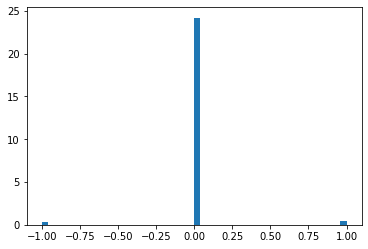

In [ ]:
plt.hist(label_ITE,bins=50,density=True)
plt.show()

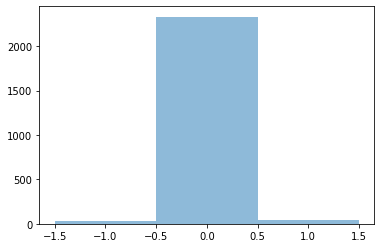

In [ ]:
catboost_X_test_T1_linalg = T1_X_test.copy(deep=True)
catboost_X_test_T0_linalg = T0_X_test.copy(deep=True)

catboost_X_test_T1_linalg = catboost_X_test_T1_linalg.fillna(0)
catboost_X_test_T0_linalg = catboost_X_test_T0_linalg.fillna(0)

catboost_X_test_T0_linalg["AF"] = (T0_y_test.values-1)*2+1
catboost_X_test_T1_linalg["AF"] = (T1_y_test.values-1)*2+1

catboost_X_test_T1_linalg = (catboost_X_test_T1_linalg - catboost_X_test_T1_linalg.mean()) / (catboost_X_test_T1_linalg.std()+0.001)
catboost_X_test_T0_linalg = (catboost_X_test_T0_linalg - catboost_X_test_T0_linalg.mean()) / (catboost_X_test_T0_linalg.std()+0.001)

catboost_X_test_T0_linalg["AF"] = (catboost_X_test_T0_linalg["AF"].values)
catboost_X_test_T1_linalg["AF"] = (catboost_X_test_T1_linalg["AF"].values)

arg_match = np.array([])
for el in catboost_X_test_T1_linalg.iterrows():
    arg_match = np.append(arg_match,np.argmin(np.linalg.norm(el[1].fillna(0).values-catboost_X_test_T0_linalg.fillna(0).values,axis=1)))
    
final_arr = (T1_CB_model.predict(T1_X_test)-T1_y_test) - (T0_CB_model.predict(T0_X_test.iloc[arg_match]) - T0_y_test.values[[int(el) for el in arg_match]])
ite_plot =  plt.hist(label_ITE,bins=np.arange(-1.5,1.9,1.0),density=False,alpha=0.5,label="ITE")[0] / len(label_ITE)

In [ ]:
T1_preDICT = classification_report(T1_y_test,T1_CB_model.predict(T1_X_test),target_names=["Survivor","Dead"],output_dict=True)
T0_preDICT = classification_report(T0_y_test,T0_CB_model.predict(T0_X_test),target_names=["Survivor","Dead"],output_dict=True)

label_zero_chance = 1-np.mean(np.append(T0_y_test,T1_y_test)) #0.5
label_one_chance = np.mean(np.append(T0_y_test,T1_y_test)) #0.5

t1_zero_predict = T1_preDICT["Survivor"]["recall"]*label_zero_chance + (1-T1_preDICT["Dead"]["recall"])*label_one_chance
t1_one_predict = (1-T1_preDICT["Survivor"]["recall"])*label_zero_chance + T1_preDICT["Dead"]["recall"]*label_one_chance
t0_zero_predict = T0_preDICT["Survivor"]["recall"]*label_zero_chance + (1-T0_preDICT["Dead"]["recall"])*label_one_chance
t0_one_predict = (1-T0_preDICT["Survivor"]["recall"])*label_zero_chance + T0_preDICT["Dead"]["recall"]*label_one_chance

ite_min_one = (T1_preDICT["Survivor"]["precision"] * T0_preDICT["Dead"]["precision"]  * ite_plot[0]
    + (1-T1_preDICT["Dead"]["precision"]) * T0_preDICT["Dead"]["precision"] * ite_plot[1] /2
    + T1_preDICT["Survivor"]["precision"] * (1-T0_preDICT["Survivor"]["precision"])  * ite_plot[1] /2
    + (1-T1_preDICT["Dead"]["precision"]) * (1-T0_preDICT["Survivor"]["precision"])  * ite_plot[2]
    )

ite_plus_one = (T1_preDICT["Dead"]["precision"] * T0_preDICT["Survivor"]["precision"]  * ite_plot[2]
    + (1-T1_preDICT["Survivor"]["precision"]) * T0_preDICT["Survivor"]["precision"]  * ite_plot[1]/2
    + T1_preDICT["Dead"]["precision"] * (1-T0_preDICT["Dead"]["precision"])  * ite_plot[1]/2
    + (1-T1_preDICT["Survivor"]["precision"]) * (1-T0_preDICT["Dead"]["precision"])  * ite_plot[0]
    )

ite_zero = (T1_preDICT["Survivor"]["precision"] * T0_preDICT["Survivor"]["precision"] * ite_plot[1]/2
    + T1_preDICT["Dead"]["precision"] * T0_preDICT["Dead"]["precision"]  * ite_plot[1]/2
    + (1-T1_preDICT["Survivor"]["precision"]) * (1-T0_preDICT["Survivor"]["precision"])  * ite_plot[1]/2
    + (1-T1_preDICT["Dead"]["precision"]) * (1-T0_preDICT["Dead"]["precision"])  * ite_plot[1]/2
    + T1_preDICT["Survivor"]["precision"] * (1-T0_preDICT["Dead"]["precision"])  * ite_plot[0]
    + (1-T1_preDICT["Survivor"]["precision"]) * T0_preDICT["Dead"]["precision"]  * ite_plot[0]
    + T1_preDICT["Dead"]["precision"] * (1-T0_preDICT["Survivor"]["precision"])  * ite_plot[2]
    + (1-T1_preDICT["Dead"]["precision"]) * T0_preDICT["Survivor"]["precision"]  * ite_plot[2]
    )

ite_plot_new = [ite_min_one,ite_zero,ite_plus_one]
# ite_plot_new = ite_plot_new/np.sum(ite_plot_new)
# plt.bar(np.arange(-0.85,1.2,1.0),ite_plot_new/np.sum(ite_plot_new),width=0.05,label="Adjusted ITE")
np.sum(ite_plot_new * np.array([-1,0,1]) )

-0.038819448076313684

### Adjusted ITE

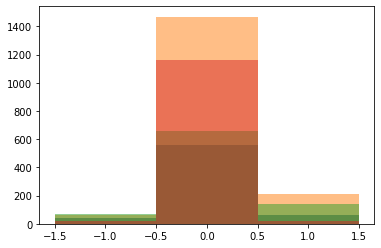

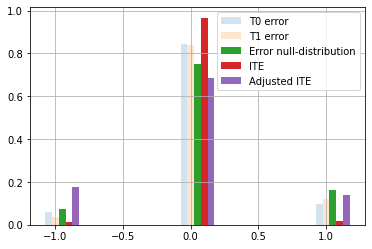

Normal ITE = 0.0049833887043189366
Adjusted ITE = -0.038819448076313684


In [ ]:
plt.figure()
t0_error = plt.hist(T0_CB_model.predict(T0_X_test)-T0_y_test,bins=np.arange(-1.5,1.9,1.0),density=False,label="T0 error")[0] / len(T0_X_test)
t1_error = plt.hist(T1_CB_model.predict(T1_X_test)-T1_y_test,bins=np.arange(-1.5,1.9,1.0),density=False,alpha=0.5,label="T1 error")[0] / len(T1_X_test)
null_error = plt.hist(final_arr,bins=np.arange(-1.5,1.9,1.0),density=False,label="Error null-distribution",alpha=0.5)[0] / len(final_arr)
ite_plot =  plt.hist(label_ITE,bins=np.arange(-1.5,1.9,1.0),density=False,alpha=0.5,label="ITE")[0] / len(label_ITE)


plt.figure()
plt.bar(np.arange(-1.05,1.2,1.0),t0_error,width=0.05,label="T0 error",alpha=0.2)
plt.bar(np.arange(-1.0,1.2,1.0),t1_error,width=0.05,label="T1 error",alpha=0.2)
plt.bar(np.arange(-0.95,1.2,1.0),null_error,width=0.05,label="Error null-distribution")
plt.bar(np.arange(-0.9,1.2,1.0),ite_plot,width=0.05,label="ITE")
plt.bar(np.arange(-0.85,1.2,1.0),ite_plot_new/np.sum(ite_plot_new),width=0.05,label="Adjusted ITE")


# plt.hist(CB_AF_T0.predict(catboost_X_test_T0)-y_test_T0,bins=3,density=True,label="T0")
# plt.hist(T1_CB_model.predict(T1_X_test)-y_test_T1,bins=3,density=True,alpha=0.5,label="T1")

plt.grid()
plt.legend()
plt.show()

print("Normal ITE = "+str(np.sum(ite_plot * np.array([-1,0,1]) )))
print("Adjusted ITE = "+str(np.sum(ite_plot_new * np.array([-1,0,1]) )))

In [ ]:
print("T0")
print(classification_report(T0_y_test,T0_CB_model.predict(T0_X_test),target_names=["Survivor","Dead"]))
print("T1")
print(classification_report(T0_y_test,T1_CB_model.predict(T0_X_test),target_names=["Survivor","Dead"]))

print(100*"=")
print("T0")
print(classification_report(T1_y_test,T0_CB_model.predict(T1_X_test),target_names=["Survivor","Dead"]))
print("T1")
print(classification_report(T1_y_test,T1_CB_model.predict(T1_X_test),target_names=["Survivor","Dead"]))


T0
              precision    recall  f1-score   support

    Survivor       0.92      0.87      0.89        90
        Dead       0.37      0.50      0.42        14

    accuracy                           0.82       104
   macro avg       0.64      0.68      0.66       104
weighted avg       0.84      0.82      0.83       104

T1
              precision    recall  f1-score   support

    Survivor       0.92      0.87      0.89        90
        Dead       0.37      0.50      0.42        14

    accuracy                           0.82       104
   macro avg       0.64      0.68      0.66       104
weighted avg       0.84      0.82      0.83       104

T0
              precision    recall  f1-score   support

    Survivor       0.94      0.86      0.90       494
        Dead       0.44      0.65      0.53        83

    accuracy                           0.83       577
   macro avg       0.69      0.76      0.71       577
weighted avg       0.87      0.83      0.84       577

T1
       

In [ ]:
T1_preDICT = classification_report(T1_y_test,T1_CB_model.predict(T1_X_test),target_names=["Survivor","Dead"],output_dict=True)
T0_preDICT = classification_report(T0_y_test,T0_CB_model.predict(T0_X_test),target_names=["Survivor","Dead"],output_dict=True)

label_zero_chance = 1-np.mean(np.append(T0_y_test,T1_y_test)) #0.5
label_one_chance = np.mean(np.append(T0_y_test,T1_y_test)) #0.5

t1_zero_predict = T1_preDICT["Survivor"]["recall"]*label_zero_chance + (1-T1_preDICT["Dead"]["recall"])*label_one_chance
t1_one_predict = (1-T1_preDICT["Survivor"]["recall"])*label_zero_chance + T1_preDICT["Dead"]["recall"]*label_one_chance
t0_zero_predict = T0_preDICT["Survivor"]["recall"]*label_zero_chance + (1-T0_preDICT["Dead"]["recall"])*label_one_chance
t0_one_predict = (1-T0_preDICT["Survivor"]["recall"])*label_zero_chance + T0_preDICT["Dead"]["recall"]*label_one_chance

ite_min_one = (T1_preDICT["Survivor"]["precision"] * T0_preDICT["Dead"]["precision"]  * ite_plot[0]
    + (1-T1_preDICT["Dead"]["precision"]) * T0_preDICT["Dead"]["precision"] * ite_plot[1] /2
    + T1_preDICT["Survivor"]["precision"] * (1-T0_preDICT["Survivor"]["precision"])  * ite_plot[1] /2
    + (1-T1_preDICT["Dead"]["precision"]) * (1-T0_preDICT["Survivor"]["precision"])  * ite_plot[2]
    )

ite_plus_one = (T1_preDICT["Dead"]["precision"] * T0_preDICT["Survivor"]["precision"]  * ite_plot[2]
    + (1-T1_preDICT["Survivor"]["precision"]) * T0_preDICT["Survivor"]["precision"]  * ite_plot[1]/2
    + T1_preDICT["Dead"]["precision"] * (1-T0_preDICT["Dead"]["precision"])  * ite_plot[1]/2
    + (1-T1_preDICT["Survivor"]["precision"]) * (1-T0_preDICT["Dead"]["precision"])  * ite_plot[0]
    )

ite_zero = (T1_preDICT["Survivor"]["precision"] * T0_preDICT["Survivor"]["precision"] * ite_plot[1]/2
    + T1_preDICT["Dead"]["precision"] * T0_preDICT["Dead"]["precision"]  * ite_plot[1]/2
    + (1-T1_preDICT["Survivor"]["precision"]) * (1-T0_preDICT["Survivor"]["precision"])  * ite_plot[1]/2
    + (1-T1_preDICT["Dead"]["precision"]) * (1-T0_preDICT["Dead"]["precision"])  * ite_plot[1]/2
    + T1_preDICT["Survivor"]["precision"] * (1-T0_preDICT["Dead"]["precision"])  * ite_plot[0]
    + (1-T1_preDICT["Survivor"]["precision"]) * T0_preDICT["Dead"]["precision"]  * ite_plot[0]
    + T1_preDICT["Dead"]["precision"] * (1-T0_preDICT["Survivor"]["precision"])  * ite_plot[2]
    + (1-T1_preDICT["Dead"]["precision"]) * T0_preDICT["Survivor"]["precision"]  * ite_plot[2]
    )

ite_plot_new = [ite_min_one,ite_zero,ite_plus_one]
# ite_plot_new = ite_plot_new/np.sum(ite_plot_new)
# plt.bar(np.arange(-0.85,1.2,1.0),ite_plot_new/np.sum(ite_plot_new),width=0.05,label="Adjusted ITE")
np.sum(ite_plot_new * np.array([-1,0,1]) )

-0.021927279681762724

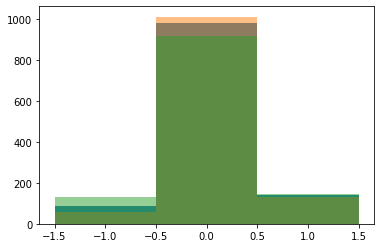

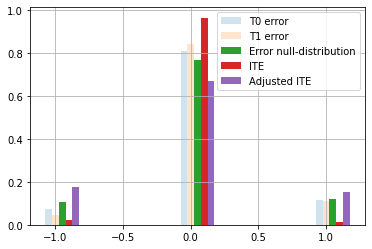

Normal ITE = -0.009547530095475302
Adjusted ITE = -0.021927279681762724


In [ ]:
plt.figure()
t0_error = plt.hist(T0_CB_model.predict(T0_X_test)-T0_y_test,bins=np.arange(-1.5,1.9,1.0),density=False,label="T0 error")[0] / len(T0_X_test)
t1_error = plt.hist(T1_CB_model.predict(T1_X_test)-T1_y_test,bins=np.arange(-1.5,1.9,1.0),density=False,alpha=0.5,label="T1 error")[0] / len(T1_X_test)
null_error = plt.hist(final_arr,bins=np.arange(-1.5,1.9,1.0),density=False,label="Error null-distribution",alpha=0.5)[0] / len(final_arr[[True if el in [-1,1,0] else False for el in final_arr]])
# ite_plot =  plt.hist(label_ITE,bins=np.arange(-1.5,1.9,1.0),density=False,alpha=0.5,label="ITE")[0] / len(label_ITE)

T1_preDICT = classification_report(T1_y_test,T1_CB_model.predict(T1_X_test),target_names=["Survivor","Dead"],output_dict=True)
T0_preDICT = classification_report(T0_y_test,T0_CB_model.predict(T0_X_test),target_names=["Survivor","Dead"],output_dict=True)

plt.figure()
plt.bar(np.arange(-1.05,1.2,1.0),t0_error,width=0.05,label="T0 error",alpha=0.2)
plt.bar(np.arange(-1.0,1.2,1.0),t1_error,width=0.05,label="T1 error",alpha=0.2)
plt.bar(np.arange(-0.95,1.2,1.0),null_error,width=0.05,label="Error null-distribution")
plt.bar(np.arange(-0.9,1.2,1.0),ite_plot,width=0.05,label="ITE")
plt.bar(np.arange(-0.85,1.2,1.0),ite_plot_new/np.sum(ite_plot_new),width=0.05,label="Adjusted ITE")

# plt.hist(CB_AF_T0.predict(catboost_X_test_T0)-y_test_T0,bins=3,density=True,label="T0")
# plt.hist(CB_AF_T1.predict(catboost_X_test_T1)-y_test_T1,bins=3,density=True,alpha=0.5,label="T1")

plt.grid()
plt.legend()
plt.show()

print("Normal ITE = "+str(np.sum(ite_plot * np.array([-1,0,1]) )))
print("Adjusted ITE = "+str(np.sum(ite_plot_new * np.array([-1,0,1]) )))

In [ ]:
# P(ITE = 1) = 1 - P(T1 = Dead)*P(T0 = Survivor) = T1_preDICT["Dead"]["precision"]*T0_preDICT["Dead"]["precision"] = 0.574
# P(ITE = -1) = 1 - P(T1 = Survivor)*P(T0 = Dead) = T1_preDICT["Survivor"]["precision"]*T0_preDICT["Survivor"]["precision"] = 0.535
# P(ITE = 0) = P(T1 = Survivor)*P(T0 = Survivor) - P(T1 = Dead)*P(T0 = Dead) = (T1_preDICT["Survivor"]["precision"]*T0_preDICT["Survivor"]["precision"] + T1_preDICT["Survivor"]["precision"]*T0_preDICT["Survivor"]["precision"])/2 = 0.81985

In [ ]:
print(25*"="+" T1 "+25*"=")
print(classification_report(T1_y_test,T1_CB_model.predict(T1_X_test),target_names=["Survivor","Dead"]))

print(25*"="+" T0 "+25*"=")
print(classification_report(T0_y_test,T0_CB_model.predict(T0_X_test),target_names=["Survivor","Dead"]))

========================= T1 =========================
              precision    recall  f1-score   support

    Survivor       0.95      0.88      0.91       473
        Dead       0.50      0.71      0.59        84

    accuracy                           0.85       557
   macro avg       0.72      0.79      0.75       557
weighted avg       0.88      0.85      0.86       557

========================= T0 =========================
              precision    recall  f1-score   support

    Survivor       0.91      0.87      0.89      1467
        Dead       0.59      0.68      0.63       385

    accuracy                           0.83      1852
   macro avg       0.75      0.78      0.76      1852
weighted avg       0.85      0.83      0.84      1852



In [ ]:
# add_nan_features = False
# verbose_bool = False
# selection_bias = False
# shap_prognost_predict = False
# combo = False #if set to True, we use a S-learner, if set to false we use T-learner
# pehes = []
# mean_ITEs = []
# std_ITEs = []
# train_pehes = []
# train_std_ITEs = []
# train_mean_ITEs = []
# bootstrap_iterations = 500#0
# test_test_size = 0.2
# val_test_size = 0.3
# shap_difs = np.array([])
# T0_shaps = np.array([])
# T0_shap_values_ar = np.array([])
# T1_shaps  = np.array([])
# T1_shap_values_ar = np.array([])
# T1_X_shap_ar = np.array([])
# T0_X_shap_ar = np.array([])

# for i in tqdm(range(bootstrap_iterations),ascii==True):
#     #print("\rRun "+str(i+1)+"/"+str(bootstrap_iterations),end="")
    
#     treatment_observation_arr = np.array([0]) 
#     while(np.mean(treatment_observation_arr)<0.2 or np.mean(treatment_observation_arr)>0.8): 
#         if not selection_bias:
#             treatment_observation_arr = np.random.randint(0,2,len(dataset))
#         else:
#             #ADD SELECTION BIAS
#             noise_level = 0.1
#             feat = ['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
#                    'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
#                    'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
#                    'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
#                    'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
#                    'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
#                    'data_year', 'nprevistq', 'dfageq', 'feduc6',
#                    'dlivord_min', 'dtotord_min',
#                    'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']
#             #feat=['gestat10', 'nprevistq', 'csex', 'hydra']
#             n_features = len(feat)
#             treatment_weights = np.random.uniform(-0.1,0.1,(n_features))
#             treatment_noise = np.random.normal(0,noise_level)
#             treatment_observation_arr = np.random.binomial(1,sigmoid(np.matmul(dataset[feat].fillna(0).values,treatment_weights)+treatment_noise))  

#     T0_train_dataset,T0_test_dataset = train_test_split(dataset[treatment_observation_arr==0],test_size=test_test_size,random_state=i)
#     T0_train_dataset,T0_val_dataset = train_test_split(T0_train_dataset,test_size=val_test_size,random_state=i)

#     T1_train_dataset,T1_test_dataset = train_test_split(dataset[treatment_observation_arr==1],test_size=test_test_size,random_state=i)
#     T1_train_dataset,T1_val_dataset = train_test_split(T1_train_dataset,test_size=val_test_size,random_state=i)

#     T0_X_train =  T0_train_dataset[lighter_columns]
#     T0_X_val =  T0_val_dataset[lighter_columns]
#     T0_X_test =  T0_test_dataset[lighter_columns]
#     T0_X_train = T0_X_train.rename(columns={'infant_id_0':'infant_id',  'bord_0':'bord'})
#     T0_X_val = T0_X_val.rename(columns={'infant_id_0':'infant_id',  'bord_0':'bord'})
#     T0_X_test = T0_X_test.rename(columns={'infant_id_0':'infant_id',  'bord_0':'bord'})

#     T0_y_train =  T0_train_dataset["mort_0"]
#     T0_y_val =  T0_val_dataset["mort_0"]
#     T0_y_test = T0_test_dataset["mort_0"]

#     T1_X_train = T1_train_dataset[heavier_columns]
#     T1_X_val = T1_val_dataset[heavier_columns]
#     T1_X_test = T1_test_dataset[heavier_columns]
#     T1_X_train = T1_X_train.rename(columns={'infant_id_1':'infant_id',  'bord_1':'bord'})
#     T1_X_val = T1_X_val.rename(columns={'infant_id_1':'infant_id',  'bord_1':'bord'})
#     T1_X_test = T1_X_test.rename(columns={'infant_id_1':'infant_id',  'bord_1':'bord'})

#     T1_y_train = T1_train_dataset["mort_1"]
#     T1_y_val = T1_val_dataset["mort_1"]
#     T1_y_test  = T1_test_dataset["mort_1"]
    
#     X_test_separate = pd.DataFrame(data=np.vstack((T0_X_test,T1_X_test)),columns=T0_X_test.columns)
#     X_train_separate = pd.DataFrame(data=np.vstack((T0_X_train,T1_X_train)),columns=T0_X_train.columns) 
    
#     if combo:
#         C_X_train = pd.DataFrame(data=np.vstack((np.hstack((T0_X_train,np.zeros((len(T0_X_train),1)))),np.hstack((T1_X_train,np.zeros((len(T1_X_train),1))+1)))),columns=np.append(T0_X_train.columns.values,"treatment"))
#         C_X_val = pd.DataFrame(data=np.vstack((np.hstack((T0_X_val,np.zeros((len(T0_X_val),1)))),np.hstack((T1_X_val,np.zeros((len(T1_X_val),1))+1)))),columns=np.append(T0_X_val.columns.values,"treatment"))
#         C_X_test_T0 = pd.DataFrame(data=np.hstack((X_test_separate,np.zeros((len(X_test_separate),1)))),columns=np.append(X_test_separate.columns.values,"treatment"))
#         C_X_test_T1 = pd.DataFrame(data=np.hstack((X_test_separate,np.zeros((len(X_test_separate),1))+1)),columns=np.append(X_test_separate.columns.values,"treatment"))
#         C_X_train_T0 = pd.DataFrame(data=np.hstack((X_train_separate,np.zeros((len(X_train_separate),1)))),columns=np.append(X_train_separate.columns.values,"treatment"))
#         C_X_train_T1 = pd.DataFrame(data=np.hstack((X_train_separate,np.zeros((len(X_train_separate),1))+1)),columns=np.append(X_train_separate.columns.values,"treatment"))
#         C_y_train = np.append(T0_y_train,T1_y_train)
#         C_y_val = np.append(T0_y_val,T1_y_val)
#         C_y_test = np.append(T0_y_test,T1_y_test)

#     if not combo:
#         T0_class_balance = [T0_y_train.sum()/len(T0_y_train),1-T0_y_train.sum()/len(T0_y_train)]
#         T0_CB_model = CatBoostClassifier(verbose=verbose_bool,iterations=100,class_weights=T0_class_balance,use_best_model=True)
#         T0_CB_model.fit(Pool(T0_X_train,T0_y_train),eval_set=(T0_X_val,T0_y_val))

#         T1_class_balance = [T1_y_train.sum()/len(T1_y_train),1-T1_y_train.sum()/len(T1_y_train)]
#         T1_CB_model = CatBoostClassifier(verbose=verbose_bool,iterations=100,class_weights=T1_class_balance,use_best_model=True)
#         T1_CB_model.fit(Pool(T1_X_train,T1_y_train),eval_set=(T1_X_val,T1_y_val))
        
#         label_ITE = T1_CB_model.predict_proba(X_test_separate)[:,1]-T0_CB_model.predict_proba(X_test_separate)[:,1]
#         train_label_ITE = T1_CB_model.predict_proba(X_train_separate)[:,1]-T0_CB_model.predict_proba(X_train_separate)[:,1]
        
#         T1_explainer = shap.TreeExplainer(T1_CB_model)
#         T1_shap_values = np.abs(T1_explainer.shap_values(X_test_separate))
#         T0_explainer = shap.TreeExplainer(T0_CB_model)
#         T0_shap_values = np.abs(T0_explainer.shap_values(X_test_separate))
#         shap_diff_ar = np.mean(T1_shap_values-T0_shap_values,axis=0)
#         if len(shap_difs)>0:
#             shap_difs = np.vstack([shap_difs,shap_diff_ar])
#             T0_shaps = np.vstack([T0_shaps,np.mean(T0_shap_values,axis=0)])
#             T1_shaps = np.vstack([T1_shaps,np.mean(T1_shap_values,axis=0)])
#         else:
#             shap_difs = shap_diff_ar
#             T0_shaps = np.mean(T0_shap_values,axis=0)
#             T1_shaps = np.mean(T1_shap_values,axis=0)

#     else:
#         C_class_balance = [C_y_train.sum()/len(C_y_train),1-C_y_train.sum()/len(C_y_train)]
#         C_CB_model = CatBoostClassifier(verbose=verbose_bool,iterations=100,class_weights=C_class_balance,use_best_model=True)
#         C_CB_model.fit(Pool(C_X_train,C_y_train),eval_set=(C_X_val,C_y_val))
        
#         label_ITE = C_CB_model.predict_proba(C_X_test_T1)[:,1]-C_CB_model.predict_proba(C_X_test_T0)[:,1]
#         train_label_ITE = C_CB_model.predict_proba(C_X_train_T1)[:,1]-C_CB_model.predict_proba(C_X_train_T0)[:,1]

#         C_explainer = shap.TreeExplainer(C_CB_model)
#         T1_shap_values = C_explainer.shap_values(C_X_test_T1)
#         T0_shap_values = C_explainer.shap_values(C_X_test_T0)
        
#         if len(T0_shap_values_ar)>0:
#             T0_shap_values_ar = np.vstack([T0_shap_values_ar,T0_shap_values])
#             T1_shap_values_ar = np.vstack([T1_shap_values_ar,T1_shap_values])
#             T1_X_shap_ar = np.vstack([T1_X_shap_ar,C_X_test_T1])
#             T0_X_shap_ar = np.vstack([T0_X_shap_ar,C_X_test_T0])
#         else:
#             T0_shap_values_ar = T0_shap_values
#             T1_shap_values_ar = T1_shap_values
#             T1_X_shap_ar = C_X_test_T1
#             T0_X_shap_ar = C_X_test_T0
        
#         T1_shap_values = np.abs(T1_shap_values)
#         T0_shap_values = np.abs(T0_shap_values)
        
#         shap_diff_ar = np.mean(T1_shap_values-T0_shap_values,axis=0)
#         if len(shap_difs)>0:
#             shap_difs = np.vstack([shap_difs,shap_diff_ar])
#             T0_shaps = np.vstack([T0_shaps,np.mean(T0_shap_values,axis=0)])
#             T1_shaps = np.vstack([T1_shaps,np.mean(T1_shap_values,axis=0)])
#         else:
#             shap_difs = shap_diff_ar
#             T0_shaps = np.mean(T0_shap_values,axis=0)
#             T1_shaps = np.mean(T1_shap_values,axis=0)
            


#     #print("")
#     #print(np.mean(label_ITE))
#     mean_ITEs.append(np.mean(label_ITE))
#     std_ITEs.append(np.std(label_ITE))
#     train_mean_ITEs.append(np.mean(train_label_ITE))
#     train_std_ITEs.append(np.std(train_label_ITE))
#     pehes_temp = sqrt_epsilon_PEHE(np.append(T0_test_dataset["mort_1"],T1_test_dataset["mort_1"]),np.append(T0_test_dataset["mort_0"],T1_test_dataset["mort_0"]),label_ITE)
#     train_pehes_temp = sqrt_epsilon_PEHE(np.append(T0_train_dataset["mort_1"],T1_train_dataset["mort_1"]),np.append(T0_train_dataset["mort_0"],T1_train_dataset["mort_0"]),train_label_ITE)
#     pehes.append(pehes_temp)
#     train_pehes.append(train_pehes_temp)
#     #print("SQRT(E_PEHE) = "+str(pehes_temp))

# #it does not matter which column array I pick, they all have the same
# if combo:
#     shap_difs_pd = pd.DataFrame(data=shap_difs,columns=np.append(T0_X_train.columns.values,"treatment"))
#     T0_shaps_pd = pd.DataFrame(data=T0_shaps,columns=np.append(T0_X_train.columns.values,"treatment"))
#     T1_shaps_pd = pd.DataFrame(data=T1_shaps,columns=np.append(T0_X_train.columns.values,"treatment"))
# else:
#     shap_difs_pd = pd.DataFrame(data=shap_difs,columns=T0_X_train.columns) 
#     T0_shaps_pd = pd.DataFrame(data=T0_shaps,columns=T0_X_train.columns) 
#     T1_shaps_pd = pd.DataFrame(data=T1_shaps,columns=T0_X_train.columns) 

# ########################################################################################################################################################   
# ## SHAP VALUE DIFFERENCE ANALYSIS
# p_values = []
# for i in range(len(shap_difs_pd.columns)):
#     quantile = p_values_null_coef(np.array(shap_difs_pd.values[:,i]))/100
#     if quantile > 0.5:
#         p_value = 1-quantile
#     else:
#         p_value = quantile
#     p_values.append(p_value)
    
# processed_shap_diff_pd = pd.DataFrame(data=np.hstack([np.reshape(shap_difs_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_absolute_shap","p_value"],index=shap_difs_pd.mean().index)
# processed_shap_diff_pd = processed_shap_diff_pd.reindex(processed_shap_diff_pd.mean_shap.abs().sort_values(ascending=False).index)

# ## SHAP VALUE DIFFERENCE ANALYSIS
# p_values = []
# for i in range(len(T0_shaps_pd.columns)):
#     if shap_prognost_predict:
#         mean_random_uniform = T0_shaps_pd["random_uniform_feature"].values.mean()
#         quantile = p_values_arg_coef(np.array(T0_shaps_pd.values[:,i]),mean_random_uniform)/100
#         p_value = quantile
#     else:
#         quantile = p_values_null_coef(np.array(T0_shaps_pd.values[:,i]))/100
#         if quantile > 0.5:
#             p_value = 1-quantile
#         else:
#             p_value = quantile
#     p_values.append(p_value)
    
# processed_T0_shaps_pd = pd.DataFrame(data=np.hstack([np.reshape(T0_shaps_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_absolute_shap","p_value"],index=T0_shaps_pd.mean().index)
# processed_T0_shaps_pd = processed_T0_shaps_pd.reindex(processed_T0_shaps_pd.mean_shap.abs().sort_values(ascending=False).index)

# ## SHAP VALUE DIFFERENCE ANALYSIS
# p_values = []
# for i in range(len(T1_shaps_pd.columns)):
#     if shap_prognost_predict:
#         mean_random_uniform = T1_shaps_pd["random_uniform_feature"].values.mean()
#         quantile = p_values_arg_coef(np.array(T1_shaps_pd.values[:,i]),mean_random_uniform)/100
#         p_value = quantile
#     else:
#         quantile = p_values_null_coef(np.array(T1_shaps_pd.values[:,i]))/100
#         if quantile > 0.5:
#             p_value = 1-quantile
#         else:
#             p_value = quantile
#     p_values.append(p_value)
    
# processed_T1_shaps_pd = pd.DataFrame(data=np.hstack([np.reshape(T1_shaps_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_absolute_shap","p_value"],index=T1_shaps_pd.mean().index)
# processed_T1_shaps_pd = processed_T1_shaps_pd.reindex(processed_T1_shaps_pd.mean_shap.abs().sort_values(ascending=False).index)
# ########################################################################################################################################################   

# ## RESULT PRINTING
# print("")       
# print("TRAINING SET")
# quantile = p_values_null_coef(np.array(train_mean_ITEs))/100
# if quantile > 0.5:
#     p_value = 1-quantile
# else:
#     p_value = quantile

# print(tabulate([[np.round(np.mean(train_pehes),5),str(np.round(np.mean(train_mean_ITEs),5))+" (+-"+str(np.round(np.std(train_mean_ITEs),5))+")",str(np.round(np.mean(train_std_ITEs),5))+" (+-"+str(np.round(np.std(train_std_ITEs),5))+")",p_value]], ["SQRT E PEHE","ATE (std)","STD ITE (std)","p-Value Treatment"], tablefmt="grid"))
    
# print("")       
# print("TEST SET")
# quantile = p_values_null_coef(np.array(mean_ITEs))/100
# if quantile > 0.5:
#     p_value = 1-quantile
# else:
#     p_value = quantile

# print(tabulate([[np.round(np.mean(pehes),5),str(np.round(np.mean(mean_ITEs),5))+" (+-"+str(np.round(np.std(mean_ITEs),5))+")",str(np.round(np.mean(std_ITEs),5))+" (+-"+str(np.round(np.std(std_ITEs),5))+")",p_value]], ["SQRT E PEHE","ATE (std)","STD ITE (std)","p-Value Treatment"], tablefmt="grid"))

In [ ]:
processed_T1_shaps_pd[processed_T1_shaps_pd.p_value<0.05]

mean_shap  p_value
gestat10    1.313800    0.000
nprevistq   0.212441    0.000
csex        0.121755    0.004
treatment   0.102638    0.014
hydra       0.074052    0.002
data_year   0.059552    0.048

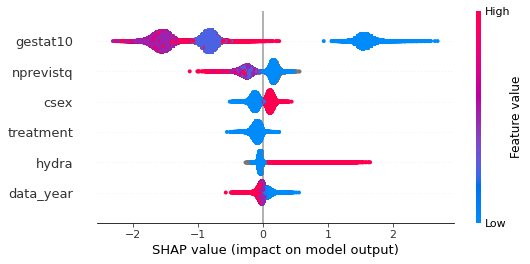

In [ ]:
idx = np.where(np.isin(C_X_test_T1.columns.values,processed_T1_shaps_pd[processed_T1_shaps_pd.p_value<0.05].index.values))
shap.summary_plot(T1_shap_values_ar[:,list(idx[0])],pd.DataFrame(data=T1_X_shap_ar[:,list(idx[0])],columns=C_X_test_T1.columns[idx]))

In [ ]:
processed_T0_shaps_pd[processed_T0_shaps_pd.p_value<0.05]

mean_shap  p_value
gestat10    1.274192    0.000
nprevistq   0.204924    0.000
csex        0.118234    0.006
treatment   0.091912    0.024
hydra       0.074803    0.002

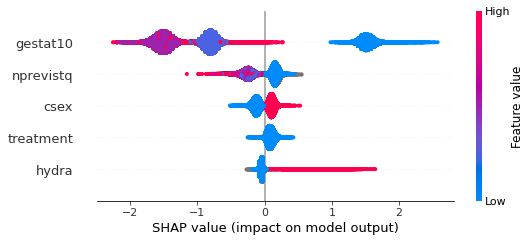

In [ ]:
idx = np.where(np.isin(C_X_test_T0.columns.values,processed_T0_shaps_pd[processed_T0_shaps_pd.p_value<0.05].index.values))
shap.summary_plot(T0_shap_values_ar[:,list(idx[0])],pd.DataFrame(data=T0_X_shap_ar[:,list(idx[0])],columns=C_X_test_T0.columns[idx]))

In [ ]:
processed_shap_diff_pd[processed_shap_diff_pd.p_value<0.05]

mean_shap  p_value
gestat10    0.039608    0.008
treatment   0.010725    0.000

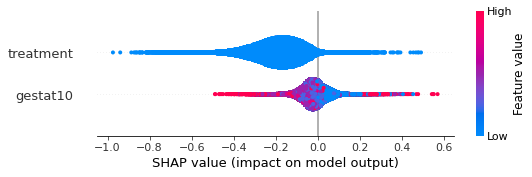

In [ ]:
idx = np.where(np.isin(C_X_test_T0.columns.values,processed_shap_diff_pd[processed_shap_diff_pd.p_value<0.05].index.values))
shap.summary_plot(T1_shap_values_ar[:,list(idx[0])]-T0_shap_values_ar[:,list(idx[0])],pd.DataFrame(data=T0_X_shap_ar[:,list(idx[0])],columns=C_X_test_T0.columns[idx]))

- T1 - T0 
- Mortality = 1, survival = 0  
- -> negative: T0_mortality > T1_mortality 
- high shap value (>0) -> more chance for mortality 
- lower shap value (<0) -> less chance for mortality 
- positive shap difference -> feature influences predicton adding more mortality in T1 compared to T0 
- negative shap difference -> feature influences predicton adding more mortality in T0 compared to T1

# IHDP DATASET

In [ ]:
dataset= pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv", header = None)
dataset.head()

0         1         2         3         4         5         6         7   \
0   1  5.599916  4.318780  3.268256  6.854457 -0.528603 -0.343455  1.128554   
1   0  6.875856  7.856495  6.636059  7.562718 -1.736945 -1.802002  0.383828   
2   0  2.996273  6.633952  1.570536  6.121617 -0.807451 -0.202946 -0.360898   
3   0  1.366206  5.697239  1.244738  5.889125  0.390083  0.596582 -1.850350   
4   0  1.963538  6.202582  1.685048  6.191994 -1.045229 -0.602710  0.011465   

         8         9         10  11  12  13  14  15  16  17  18  19  20  21  \
0  0.161703 -0.316603  1.295216   1   0   1   0   0   0   0   1   0   1   1   
1  2.244320 -0.629189  1.295216   0   0   0   1   0   0   1   1   1   1   1   
2 -0.879606  0.808706 -0.526556   0   0   0   1   0   0   0   2   0   1   0   
3 -0.879606 -0.004017 -0.857787   0   0   0   0   0   1   1   2   0   1   0   
4  0.161703  0.683672 -0.360940   1   0   0   0   0   1   1   1   0   1   1   

   22  23  24  25  26  27  28  29  
0   1   1   0   0   0   0   0   0  
1   1   1   0   0   0   0   0   0  
2   1   1   0   0   0   0   0   0  
3   1   1   0   0   0   0   0   0  
4   1   1   0   0   0   0   0   0

In [ ]:
col =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1" ,]

for i in range(1,26):
    col.append("x"+str(i))
dataset.columns = col

dataset["y_1_outcome"]=0
dataset["y_0_outcome"]=0
dataset.loc[dataset.treatment==1,"y_1_outcome"]=dataset[dataset.treatment==1].y_factual
dataset.loc[dataset.treatment==1,"y_0_outcome"]=dataset[dataset.treatment==1].y_cfactual

dataset.loc[dataset.treatment==0,"y_0_outcome"]=dataset[dataset.treatment==0].y_factual
dataset.loc[dataset.treatment==0,"y_1_outcome"]=dataset[dataset.treatment==0].y_cfactual

dataset.head()

treatment  y_factual  y_cfactual       mu0       mu1        x1        x2  \
0          1   5.599916    4.318780  3.268256  6.854457 -0.528603 -0.343455   
1          0   6.875856    7.856495  6.636059  7.562718 -1.736945 -1.802002   
2          0   2.996273    6.633952  1.570536  6.121617 -0.807451 -0.202946   
3          0   1.366206    5.697239  1.244738  5.889125  0.390083  0.596582   
4          0   1.963538    6.202582  1.685048  6.191994 -1.045229 -0.602710   

         x3        x4        x5        x6  x7  x8  x9  x10  x11  x12  x13  \
0  1.128554  0.161703 -0.316603  1.295216   1   0   1    0    0    0    0   
1  0.383828  2.244320 -0.629189  1.295216   0   0   0    1    0    0    1   
2 -0.360898 -0.879606  0.808706 -0.526556   0   0   0    1    0    0    0   
3 -1.850350 -0.879606 -0.004017 -0.857787   0   0   0    0    0    1    1   
4  0.011465  0.161703  0.683672 -0.360940   1   0   0    0    0    1    1   

   x14  x15  x16  x17  x18  x19  x20  x21  x22  x23  x24  x25  y_1_outcome  \
0    1    0    1    1    1    1    0    0    0    0    0    0     5.599916   
1    1    1    1    1    1    1    0    0    0    0    0    0     7.856495   
2    2    0    1    0    1    1    0    0    0    0    0    0     6.633952   
3    2    0    1    0    1    1    0    0    0    0    0    0     5.697239   
4    1    0    1    1    1    1    0    0    0    0    0    0     6.202582   

   y_0_outcome  
0     4.318780  
1     6.875856  
2     2.996273  
3     1.366206  
4     1.963538

In [ ]:
feature_cols = ['x1',
             'x2',
             'x3',
             'x4',
             'x5',
             'x6',
             'x7',
             'x8',
             'x9',
             'x10',
             'x11',
             'x12',
             'x13',
             'x14',
             'x15',
             'x16',
             'x17',
             'x18',
             'x19',
             'x20',
             'x21',
             'x22',
             'x23',
             'x24',
             'x25']

#fixing some outliers 
for col in feature_cols:
    dataset.loc[(dataset[col].values>dataset[~dataset[col].isna()][col].quantile(0.99))
                            |(dataset[col].values<dataset[~dataset[col].isna()][col].quantile(0.01)),col]=np.NaN
    
dataset = dataset.fillna(dataset.mean())

MEAN FACTUAL : 3.1595375238575967
MEAN COUNTERFACTUAL : 5.69610655030994
ATE 4.0296612252169
ITE STD 1.5997122212409884
Treatment selection of T1: 0.18607764390896922


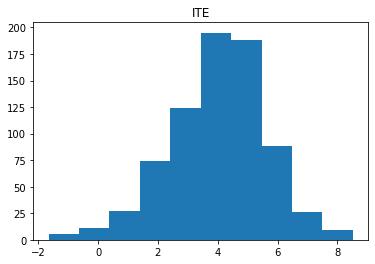

In [ ]:
print("MEAN FACTUAL : "+str(np.mean(dataset["y_factual"])))
print("MEAN COUNTERFACTUAL : "+str(np.mean(dataset["y_cfactual"])))
print("ATE", np.mean(dataset["y_1_outcome"])- np.mean(dataset["y_0_outcome"]))
print("ITE STD", np.std(dataset["y_1_outcome"]- dataset["y_0_outcome"]))
plt.hist(dataset["y_1_outcome"]-dataset["y_0_outcome"])
plt.title("ITE")

if not selection_bias:
    #treatment_observation_arr = dataset["treatment"]#np.random.randint(0,2,len(dataset))
    treatment_observation_arr = np.random.randint(0,2,len(dataset))
else:
    #ADD SELECTION BIAS
    #noise_level = 0.1
    #feat = feature_cols
    #n_features = len(feat)
    #treatment_weights = np.random.uniform(-0.1,0.1,(n_features))
    #treatment_noise = np.random.normal(0,noise_level)
    treatment_observation_arr = dataset["treatment"]#np.random.binomial(1,sigmoid(np.matmul(dataset[feat].fillna(0).values,treatment_weights)+treatment_noise))  
    
dataset["treatment"]=treatment_observation_arr
print("Treatment selection of T1: "+str(sum(treatment_observation_arr)/len(treatment_observation_arr)))

In [ ]:
add_nan_features = False
verbose_bool = False
combo = True
pehes = []
mean_ITEs = []
std_ITEs = []
train_pehes = []
train_std_ITEs = []
train_mean_ITEs = []
bootstrap_iterations = 100#00
test_test_size = 0.2
val_test_size = 0.2
shap_difs = np.array([])

for i in tqdm(range(bootstrap_iterations),ascii==True):
    #print("\rRun "+str(i+1)+"/"+str(bootstrap_iterations),end="")

    T0_train_dataset,T0_test_dataset = train_test_split(dataset[dataset.treatment==0],test_size=test_test_size,random_state=i)
    T0_train_dataset,T0_val_dataset = train_test_split(T0_train_dataset,test_size=val_test_size,random_state=i)

    T1_train_dataset,T1_test_dataset = train_test_split(dataset[dataset.treatment==1],test_size=test_test_size,random_state=i)
    T1_train_dataset,T1_val_dataset = train_test_split(T1_train_dataset,test_size=val_test_size,random_state=i)

    T0_X_train =  T0_train_dataset[feature_cols]
    T0_X_val =  T0_val_dataset[feature_cols]
    T0_X_test =  T0_test_dataset[feature_cols]

    T0_y_train =  T0_train_dataset["y_0_outcome"]
    T0_y_val =  T0_val_dataset["y_0_outcome"]
    T0_y_test = T0_test_dataset["y_0_outcome"]

    T1_X_train = T1_train_dataset[feature_cols]
    T1_X_val = T1_val_dataset[feature_cols]
    T1_X_test = T1_test_dataset[feature_cols]
    
    T1_y_train = T1_train_dataset["y_1_outcome"]
    T1_y_val = T1_val_dataset["y_1_outcome"]
    T1_y_test  = T1_test_dataset["y_1_outcome"]
    
    X_test_separate = pd.DataFrame(data=np.vstack((T0_X_test,T1_X_test)),columns=T0_X_test.columns)
    X_train_separate = pd.DataFrame(data=np.vstack((T0_X_train,T1_X_train)),columns=T0_X_train.columns) 
    
    if combo:
        C_X_train = pd.DataFrame(data=np.vstack((np.hstack((T0_X_train,np.zeros((len(T0_X_train),1)))),np.hstack((T1_X_train,np.zeros((len(T1_X_train),1))+1)))),columns=np.append(T0_X_train.columns.values,"treatment"))
        C_X_val = pd.DataFrame(data=np.vstack((np.hstack((T0_X_val,np.zeros((len(T0_X_val),1)))),np.hstack((T1_X_val,np.zeros((len(T1_X_val),1))+1)))),columns=np.append(T0_X_val.columns.values,"treatment"))
        C_X_test_T0 = pd.DataFrame(data=np.hstack((X_test_separate,np.zeros((len(X_test_separate),1)))),columns=np.append(X_test_separate.columns.values,"treatment"))
        C_X_test_T1 = pd.DataFrame(data=np.hstack((X_test_separate,np.zeros((len(X_test_separate),1))+1)),columns=np.append(X_test_separate.columns.values,"treatment"))
        C_X_train_T0 = pd.DataFrame(data=np.hstack((X_train_separate,np.zeros((len(X_train_separate),1)))),columns=np.append(X_train_separate.columns.values,"treatment"))
        C_X_train_T1 = pd.DataFrame(data=np.hstack((X_train_separate,np.zeros((len(X_train_separate),1))+1)),columns=np.append(X_train_separate.columns.values,"treatment"))
        C_y_train = np.append(T0_y_train,T1_y_train)
        C_y_val = np.append(T0_y_val,T1_y_val)
        C_y_test = np.append(T0_y_test,T1_y_test)

    if not combo:
        T0_CB_model = CatBoostRegressor(verbose=verbose_bool,iterations=100,use_best_model=True)
        T0_CB_model.fit(Pool(T0_X_train,T0_y_train),eval_set=(T0_X_val,T0_y_val))

        T1_class_balance = [T1_y_train.sum()/len(T1_y_train),1-T1_y_train.sum()/len(T1_y_train)]
        T1_CB_model = CatBoostRegressor(verbose=verbose_bool,iterations=100,use_best_model=True)
        T1_CB_model.fit(Pool(T1_X_train,T1_y_train),eval_set=(T1_X_val,T1_y_val))
        
        label_ITE = T1_CB_model.predict(X_test_separate)-T0_CB_model.predict(X_test_separate)
        train_label_ITE = T1_CB_model.predict(X_train_separate)-T0_CB_model.predict(X_train_separate)
        
        T1_explainer = shap.TreeExplainer(T1_CB_model)
        T1_shap_values = T1_explainer.shap_values(X_test_separate)
        T0_explainer = shap.TreeExplainer(T0_CB_model)
        T0_shap_values = T0_explainer.shap_values(X_test_separate)
        shap_diff_ar = np.mean(T1_shap_values-T0_shap_values,axis=0)
        if len(shap_difs)>0:
            shap_difs = np.vstack([shap_difs,shap_diff_ar])
        else:
            shap_difs = shap_diff_ar

    else:
        C_CB_model = CatBoostRegressor(verbose=verbose_bool,iterations=100,use_best_model=True)
        C_CB_model.fit(Pool(C_X_train,C_y_train),eval_set=(C_X_val,C_y_val))
        
        label_ITE = C_CB_model.predict(C_X_test_T1)-C_CB_model.predict(C_X_test_T0)
        train_label_ITE = C_CB_model.predict(C_X_train_T1)-C_CB_model.predict(C_X_train_T0)

        C_explainer = shap.TreeExplainer(C_CB_model)
        T1_shap_values = C_explainer.shap_values(C_X_test_T1)
        T0_shap_values = C_explainer.shap_values(C_X_test_T0)
        shap_diff_ar = np.mean(T1_shap_values-T0_shap_values,axis=0)
        if len(shap_difs)>0:
            shap_difs = np.vstack([shap_difs,shap_diff_ar])
        else:
            shap_difs = shap_diff_ar
            


    #print("")
    #print(np.mean(label_ITE))
    mean_ITEs.append(np.mean(label_ITE))
    std_ITEs.append(np.std(label_ITE))
    train_mean_ITEs.append(np.mean(train_label_ITE))
    train_std_ITEs.append(np.std(train_label_ITE))
    pehes_temp = epsilon_PEHE(np.append(T0_test_dataset["y_1_outcome"],T1_test_dataset["y_1_outcome"]),np.append(T0_test_dataset["y_0_outcome"],T1_test_dataset["y_0_outcome"]),label_ITE)
    train_pehes_temp = epsilon_PEHE(np.append(T0_train_dataset["y_1_outcome"],T1_train_dataset["y_1_outcome"]),np.append(T0_train_dataset["y_0_outcome"],T1_train_dataset["y_0_outcome"]),train_label_ITE)
    pehes.append(pehes_temp)
    train_pehes.append(train_pehes_temp)
    #print("SQRT(E_PEHE) = "+str(pehes_temp))

#it does not matter which column array I pick, they all have the same
if combo:
    shap_difs_pd = pd.DataFrame(data=shap_difs,columns=np.append(T0_X_train.columns.values,"treatment"))
else:
    shap_difs_pd = pd.DataFrame(data=shap_difs,columns=T0_X_train.columns) 
    
## SHAP VALUE DIFFERENCE ANALYSIS
p_values = []
for i in range(len(shap_difs_pd.columns)):
    quantile = p_values_null_coef(np.array(shap_difs_pd.values[:,i]))/100
    if quantile > 0.5:
        p_value = 1-quantile
    else:
        p_value = quantile
    p_values.append(p_value)
    
processed_shap_diff_pd = pd.DataFrame(data=np.hstack([np.reshape(shap_difs_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_shap","p_value"],index=shap_difs_pd.mean().index)
processed_shap_diff_pd = processed_shap_diff_pd.reindex(processed_shap_diff_pd.mean_shap.abs().sort_values(ascending=False).index)
    
## RESULT PRINTING
print("")       
print("TRAINING SET")
quantile = p_values_null_coef(np.array(train_mean_ITEs))/100
if quantile > 0.5:
    p_value = 1-quantile
else:
    p_value = quantile

print(tabulate([[np.round(np.mean(train_pehes),5),str(np.round(np.mean(train_mean_ITEs),5))+" (+-"+str(np.round(np.std(train_mean_ITEs),5))+")",str(np.round(np.mean(train_std_ITEs),5))+" (+-"+str(np.round(np.std(train_std_ITEs),5))+")",p_value]], ["E PEHE","ATE (std)","STD ITE (std)","p-Value Treatment"], tablefmt="grid"))
    
print("")       
print("TEST SET")
quantile = p_values_null_coef(np.array(mean_ITEs))/100
if quantile > 0.5:
    p_value = 1-quantile
else:
    p_value = quantile

print(tabulate([[np.round(np.mean(pehes),5),str(np.round(np.mean(mean_ITEs),5))+" (+-"+str(np.round(np.std(mean_ITEs),5))+")",str(np.round(np.mean(std_ITEs),5))+" (+-"+str(np.round(np.std(std_ITEs),5))+")",p_value]], ["E PEHE","ATE (std)","STD ITE (std)","p-Value Treatment"], tablefmt="grid"))

print(processed_shap_diff_pd)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.79it/s]


TRAINING SET
+----------+---------------------+---------------------+---------------------+
|   E PEHE | ATE (std)           | STD ITE (std)       |   p-Value Treatment |
+==========+=====================+=====================+=====================+
|  2.21965 | 3.62292 (+-0.09454) | 0.91933 (+-0.06409) |                   0 |
+----------+---------------------+---------------------+---------------------+

TEST SET
+----------+---------------------+---------------------+---------------------+
|   E PEHE | ATE (std)           | STD ITE (std)       |   p-Value Treatment |
+==========+=====================+=====================+=====================+
|  2.53815 | 3.61443 (+-0.11531) | 0.86702 (+-0.08252) |                   0 |
+----------+---------------------+---------------------+---------------------+
           mean_shap  p_value
treatment   3.624184    0.000
x6         -0.008494    0.340
x15        -0.003230    0.430
x3          0.001680    0.390
x1         -0.001372    0.370
x2    

# Prognostic vs Predictive
Based on paper: "On Discovering Treatment-Effect  Modifiers Using Virtual Twins  and Causal Forest ML in the Presence  of Prognostic Biomarkers"

In [4]:
ground_truth_pred_features = []
ground_truth_informative_features = []

def M1(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features =['x6', 'x7','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x6','x7']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 6] > 0).astype(int)*(x_features[:, 7] > 0).astype(int))+epsilon


def M2(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 0] > 0).astype(int))+epsilon


def M3(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features =['x19','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x19']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 19] > 0).astype(int))+epsilon 


def M4(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = []
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+epsilon


def M5(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x9', 'x10', 'x11', 'x12', 'x13', 'x14','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x9', 'x10', 'x11', 'x12', 'x13', 'x14']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*(x_features[:, 9]+x_features[:, 10]+x_features[:, 11]+x_features[:, 12]+x_features[:, 13]+x_features[:, 14])+epsilon


def M6(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x4','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+3*((x_features[:, 0] > 0).astype(int)+(x_features[:, 1] > 0).astype(int)+(x_features[:, 2] > 0).astype(int)+(x_features[:, 3] > 0).astype(int)+(x_features[:, 4] > 0).astype(int))+T*((x_features[:, 4] > 0).astype(int))+epsilon


def M7(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x19','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9','x19']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4]+x_features[:, 5]+x_features[:, 6]+x_features[:, 7]+x_features[:, 8]+x_features[:, 9])+T*((x_features[:, 19] > 0).astype(int))+epsilon


def M8(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4]+x_features[:, 5]+x_features[:, 6]+x_features[:, 7]+x_features[:, 8]+x_features[:, 9])+T*((x_features[:, 0] > 0).astype(int))+epsilon


def M9(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*np.sin(x_features[:, 0])+epsilon


def M10(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+10*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 0] > 0).astype(int))+epsilon


def M11(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])**3+T*((x_features[:, 0])**3)+epsilon


def M12(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*(x_features[:, 0])+epsilon


def M13(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x19','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x19']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*(x_features[:, 19])+epsilon


def M14(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x6','x7','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x6','x7']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+50*T*((x_features[:, 6] > 0).astype(int)*(x_features[:, 7] > 0).astype(int))+epsilon


def M15(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+50*T*((x_features[:, 0] > 0).astype(int))+epsilon


def M16(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0', 'x1', 'x7','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x7']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 0] > 0).astype(int)+10*(x_features[:, 1] > 0).astype(int)+5*(x_features[:, 7] > 0).astype(int))+epsilon

def M17(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x5','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x5']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+10*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 5] > 0).astype(int))+epsilon


def M18(T, x_features, N, npRandomState):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x5','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x5']

    epsilon = npRandomState.normal(0, 1, N)
    return -1+(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])**3+T*((x_features[:, 5])**3)+epsilon

def M_DGP(T, x_features, x_columns, N, npRandomState,d_pred,d_prog,thresh,w_pred):
    global ground_truth_pred_features, ground_truth_informative_features, alpha_pred, alpha_prog

    epsilon = npRandomState.normal(0, 1, N)
    alpha_prog = npRandomState.uniform(-1,1,len(x_columns))
    alpha_pred = npRandomState.uniform(-1,1,len(x_columns))

    pred_above_threshold = np.where(np.abs(alpha_pred) > thresh)[0]
    prog_above_threshold = np.where(np.abs(alpha_prog) > thresh)[0]

    pred_features_alpha = np.sort(npRandomState.choice(pred_above_threshold,d_pred,replace=False))
    prog_features_alpha = np.sort(npRandomState.choice(prog_above_threshold,d_prog,replace=False))

    for i in range(len(x_columns)):
        if i not in pred_features_alpha:
            alpha_pred[i] = 0
        if i not in prog_features_alpha:
            alpha_prog[i] = 0

    ground_truth_pred_features = list(x_columns[pred_features_alpha])+['T']
    ground_truth_informative_features = list(set(list(x_columns[prog_features_alpha]) + list(x_columns[pred_features_alpha])))

    mu_prog = np.sum(alpha_prog * x_features,axis=1)
    mu_pred = np.sum(alpha_pred * x_features,axis=1)

    return mu_prog + T * w_pred * mu_pred + epsilon

def T0(x_features, N, npRandomState):
    return npRandomState.randint(0, 2, N)

def T1(x_features, N, npRandomState):
    logit_t1 = 0.1+0.5*x_features[:, 1]-0.25*(2+x_features[:, 2])

    return npRandomState.binomial(1, np.exp(logit_t1)/(1+np.exp(logit_t1)), N)


def T2(x_features, N, npRandomState):
    logit_t1 = 0.1+1.5*(1+x_features[:, 1])-0.25*x_features[:, 2]

    return npRandomState.binomial(1, np.exp(logit_t1)/(1+np.exp(logit_t1)), N)


# def T3(x_features, N, npRandomState):
#     logit_t1 = 0.1+1.5*x_features[:, 1]-0.25*x_features[:, 2]

#     return npRandomState.binomial(1, np.exp(logit_t1)/(1+np.exp(logit_t1)), N)


#### CATBOOST

In [3]:
# plot_bins = 20

# colum_features = ["tested_col_"+str(i) for i in range(plot_bins-1)] + ["random_col_"+str(i) for i in range(plot_bins-1)]+ ["T1_col_"+str(i) for i in range(plot_bins-1)] + ["T0_col_"+str(i) for i in range(plot_bins-1)] + ["tested_mean","tested_std","tested_skew","tested_kurtosis"]+ ["random_mean","random_std","random_skew","random_kurtosis"]+ ["T1_mean","T1_std","T1__skew","T1_kurtosis"]+ ["T0_mean","T0_std","T0_skew","T0_kurtosis"]+ ["label"]
# hist_dataset_df = pd.DataFrame(None,columns=colum_features)

In [5]:
#The covariates data has 46 features
x = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/TWINS/twin_pairs_X_3years_samesex.csv")

In [6]:
DGP_df = x[['pldel', 'birattnd', 'brstate',
       'stoccfipb', 'mager8', 'ormoth', 'mrace', 'meduc6', 'dmar',
       'mplbir', 'mpre5', 'adequacy', 'orfath', 'frace', 'birmon',
       'gestat10', 'csex', 'anemia', 'cardiac', 'lung', 'diabetes',
       'herpes', 'hydra', 'hemo', 'chyper', 'phyper', 'eclamp',
       'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
       'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
       'data_year', 'nprevistq', 'dfageq', 'feduc6', 'dlivord_min', 'dtotord_min', 
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']].copy(deep=True)

DGP_df = DGP_df.fillna(0)

In [7]:
threshold_value = 0.02
keep_cols = []

for col in DGP_df.columns.values:
    percentage_diff_values = DGP_df[col].value_counts().reset_index(drop=True)[1:].sum() / len(DGP_df)
    if percentage_diff_values >= threshold_value:
        keep_cols.append(col)

DGP_df = DGP_df[keep_cols]

i = 0
for col in keep_cols:
    DGP_df = DGP_df.rename(columns={col:"x"+str(i)})
    i += 1 

DGP_df

x0  x1  x2  x3   x4  x5   x6  x7    x8   x9  x10  x11  x12  x13  x14  \
0      1.0   1   1   3  0.0   1  0.0   1  31.0  1.0  1.0  0.0  1.0    1    9   
1      1.0   1   1   3  0.0   2  3.0   0   1.0  1.0  1.0  0.0  0.0    1    6   
2      1.0   1   1   5  0.0   1  5.0   1  59.0  1.0  1.0  0.0  1.0    1    4   
3      1.0   1   1   4  0.0   2  1.0   1   1.0  2.0  2.0  0.0  2.0    1    6   
4      1.0   1   1   5  0.0   2  4.0   0   1.0  1.0  1.0  0.0  0.0    1    6   
...    ...  ..  ..  ..  ...  ..  ...  ..   ...  ...  ...  ...  ...  ...  ...   
71340  1.0  51  56   4  0.0   3  4.0   0  51.0  1.0  1.0  0.0  3.0   11    6   
71341  1.0  51  56   4  0.0   3  3.0   0  51.0  3.0  3.0  0.0  3.0   11    6   
71342  1.0  51  56   2  0.0   1  2.0   1  38.0  1.0  2.0  0.0  1.0   11    4   
71343  1.0  51  56   5  0.0   1  5.0   1   6.0  1.0  1.0  0.0  1.0   12    4   
71344  1.0  51  56   5  0.0   1  3.0   1  51.0  1.0  1.0  0.0  1.0   12    6   

       x15  x16  x17  x18  x19  x20  x21  x22  x23  x24  x25  x26  x27  x28  \
0        1  0.0  0.0  0.0  0.0  0.0  0.0    1   89  4.0  0.0  0.0  0.0  0.0   
1        1  0.0  0.0  1.0  0.0  0.0  0.0    2   89  3.0  0.0  0.0  2.0  3.0   
2        0  0.0  0.0  0.0  0.0  0.0  0.0    1   89  1.0  6.0  3.0  0.0  0.0   
3        0  0.0  0.0  0.0  0.0  0.0  0.0    2   89  1.0  6.0  1.0  4.0  4.0   
4        0  0.0  0.0  0.0  0.0  0.0  0.0    2   89  2.0  0.0  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
71340    1  0.0  0.0  0.0  0.0  1.0  2.0    3   91  1.0  0.0  3.0  5.0  5.0   
71341    1  0.0  0.0  0.0  0.0  1.0  1.0    3   91  0.0  5.0  2.0  6.0  7.0   
71342    1  0.0  0.0  0.0  0.0  0.0  0.0    1   91  0.0  0.0  2.0  1.0  1.0   
71343    1  0.0  0.0  0.0  1.0  0.0  0.0    1   91  1.0  4.0  5.0  3.0  3.0   
71344    0  0.0  0.0  0.0  0.0  0.0  0.0    1   91  3.0  5.0  4.0  0.0  0.0   

       x29  x30  x31  
0        5    5  1.0  
1        5    5  5.0  
2        5    5  1.0  
3        5    5  5.0  
4        5    5  5.0  
...    ...  ...  ...  
71340    7    7  7.0  
71341    7    7  7.0  
71342    7    7  8.0  
71343    7    7  7.0  
71344    7    7  7.0  

[71345 rows x 32 columns]

In [8]:
def cumsum_kstest(A,B):
    A = np.sort(A)
    B = np.sort(B)
    na = A.shape[0]
    nb = B.shape[0]

    data_all = np.sort(np.concatenate([A,B]))

    cdf1 = np.searchsorted(A, data_all, side='right') / na

    cdf2 = np.searchsorted(B, data_all, side='right') / nb
    
    cddiffs = cdf1 - cdf2

    return data_all, cdf1, cdf2, cddiffs

def equisample_array_target(sample_array,reduce_array,N_bins = 5000):
    pseudo_array = np.arange(np.min(sample_array),np.max(sample_array),(np.max(sample_array) - np.min(sample_array))/N_bins)
    reduce_array_return = []

    for i in range(N_bins):
        sample_element = pseudo_array[i]
        idx = np.max(np.where(sample_array <= sample_element))
        new_element_reduce = reduce_array[idx]
        reduce_array_return.append(new_element_reduce)

    return np.array(reduce_array_return),pseudo_array

def s(X):
    return np.sqrt(1/len(X) * np.sum((X-np.mean(X))**2))

def compensated_welchs_ttest(A,B,R_A,R_B):

    t = (np.mean(A)-np.mean(B))/(np.sqrt((s(A) /np.sqrt(len(A)))**2+(s(B)/np.sqrt(len(B)))**2))

    t_random = (np.mean(R_A)-np.mean(R_B))/(np.sqrt((s(R_A) /np.sqrt(len(R_A)))**2+(s(R_B)/np.sqrt(len(R_B)))**2))

    df_A = len(A)-1
    df_B = len(B)-1

    deg_free = (s(A)**2+s(B)**2)**2 / (1/df_A * s(A)**4 + 1/df_B * s(B)**4)

    p_value_comp = (np.min([st.t.cdf(t - t_random,df=deg_free),1-st.t.cdf(t - t_random,df=deg_free)]))*2

    return t-t_random, p_value_comp

In [240]:
# causalteshap_synthetic_columns = [
#                 "synthetic_N",
#                 "random_seed",
#                 "CASE",
#                 "CONF_CASE",
#                 "alpha",
#                 "True_pred",
#                 "Found_pred",
#                 "Found_candidate_pred",
# ]

# causalteshap_synthetic_df = pd.DataFrame(None,columns=causalteshap_synthetic_columns)

causalteshap_semi_synthetic_columns = [
                "random_seed",
                "w_pred",
                "N_prog",
                "N_pred",
                "alpha",
                "True_pred",
                "Found_pred",
                "Found_candidate_pred",
]

causalteshap_synthetic_df = pd.DataFrame(None,columns=causalteshap_semi_synthetic_columns)


In [241]:
import tqdm 
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBClassifier,XGBRegressor
from lightgbm import LGBMClassifier,LGBMRegressor
import scipy.stats as st
from powershap import PowerShap
import statsmodels.stats.power as stp

prediction_array = np.array([])
candidate_array = np.array([])
true_array = np.array([])

S_learner_bool = True
DGP_bool = True
second_correlation = False
print_bool_causalteshap = False
save_df = True

if DGP_bool:
    DGP_pred_choices = [1,4,9,16]
    DGP_prog_choices = [3,8,13,21]
    # DGP_prog = 21#3
    # DGP_pred = 9#8
    w_pred_choices = [0.1,0.3,0.5,1.0] #0.25 #1#0.01
    synthetic_N_cases = [5000]#100,250,500,1000,2500,5000,10000]

    treatment_loop_cases = [T0]
    outcome_loop_cases = [M1]
    synthetic_results_path = "causalteshap_semi_synthetic_results.csv"
    max_seed_loop = 20

else:
    DGP_pred_choices = [1]
    DGP_prog_choices = [1]
    w_pred_choices = [1.0] #0.25 #1#0.01
    synthetic_N_cases = [100,250,500,1000,2500,5000,10000]

    treatment_loop_cases = [T0,T1,T2]
    outcome_loop_cases = [M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M13,M14,M15,M16,M17,M18] 
    synthetic_results_path = "causalteshap_synthetic_results.csv"
    max_seed_loop = 10


alpha_possible = np.arange(0.01,0.20,0.01)
# significance_factor = 0.05#0.02


for synthetic_N in synthetic_N_cases:
    for w_pred in w_pred_choices:
        for DGP_prog in DGP_prog_choices:
            for DGP_pred in DGP_pred_choices:
                print("")
                if DGP_bool:
                    print("N Prog: "+str(DGP_prog))
                    print("N DGP_pred: "+str(DGP_pred))
                    print("w_pred = "+str(w_pred))
                    
                else:
                    print("Sythetic N = "+str(synthetic_N))

                for seed_n in range(max_seed_loop):
                    
                    # print("")
                    seed = 42 + seed_n #42
                    # print("")
                    print("seed iteration: " +str(seed_n)+"/"+str(max_seed_loop))

                    print_idx = 0

                    for treatment_numb in treatment_loop_cases:
                        for m_function in outcome_loop_cases: 
                            N = len(DGP_df) if DGP_bool else synthetic_N #5000 #5000 # 5000 or 800
                            p = len(DGP_df.columns.values) if DGP_bool else 20 #number of candidate biomarkers
                            
                            if DGP_bool:
                                case = M_DGP
                            else:
                                case = m_function #9
                                print(10*"="+" CONF = "+str(treatment_numb.__name__)+" "+10*"="+" CASE = "+str(m_function.__name__)+" "+10*"=")

                            treatment_case = treatment_numb#T0#T1

                            columns_list = []
                            for i in range(p):
                                columns_list.append("x"+str(i))
                                
                            npRandomState = RandomState(1)
                            npRandomState_or = RandomState(seed)

                            normal_mean = 0 #npRandomState_or.uniform(-1,1,1) #1#0 #np.pi
                            normal_std = 1 #1

                            if DGP_bool:
                                x_features = DGP_df.copy(deep=True).values
                            else:
                                x_features = np.array([])
                                for i in range(p):
                                    if len(x_features)>0:
                                        x_features = np.vstack([x_features,npRandomState_or.normal(normal_mean,normal_std,N)])
                                    else:
                                        x_features = npRandomState_or.normal(normal_mean,normal_std,N)

                                x_features = np.transpose(x_features)

                            treatment_assignment = treatment_case(x_features,N,npRandomState)

                            if DGP_bool:
                                npRandomState_or = RandomState(seed)
                                y = case(treatment_assignment,x_features,DGP_df.columns.values,N,npRandomState_or, DGP_pred, DGP_prog, 0.1, w_pred)
                                npRandomState_or = RandomState(seed)
                                y_0 = case(np.zeros(N),x_features,DGP_df.columns.values,N,npRandomState_or, DGP_pred, DGP_prog, 0.1, w_pred)
                                npRandomState_or = RandomState(seed)
                                y_1 = case(np.zeros(N)+1,x_features,DGP_df.columns.values,N,npRandomState_or, DGP_pred, DGP_prog, 0.1, w_pred)
                            else:
                                npRandomState_or = RandomState(seed)
                                y = case(treatment_assignment,x_features,N,npRandomState_or)
                                npRandomState_or = RandomState(seed)
                                y_0 = case(np.zeros(N),x_features,N,npRandomState_or)
                                npRandomState_or = RandomState(seed)
                                y_1 = case(np.zeros(N)+1,x_features,N,npRandomState_or)

                            X_df = pd.DataFrame(data=x_features,columns=columns_list)
                            X_df = X_df.reset_index(drop=True)
                            X_df["y"]=y
                            X_df["y_0"]=y_0
                            X_df["y_1"]=y_1
                            X_df["T"]=treatment_assignment

                            if print_bool_causalteshap:
                                print("ATE = "+str(np.round(np.mean(np.abs(y_1 - y_0))/np.mean(np.abs(y_0))*100,3))+ " %")

                            selected_columns_list = list(np.sort(ground_truth_informative_features))

                            ITE_mean_abs_array = []
                            causal_label = "T"

                            X_causal_ITE = X_df.copy(deep=True)
                            median_arr_list = []
                            subtr_list = []
                            pred_matrix_list = []
                            prog_matrix_list = []
                            T1_matrix_list = []

                            npRandomState_ran_feature = RandomState(45)

                            for i in range(1):

                                X_causal_ITE['random_uniform'] = 0
                                X_causal_ITE.loc[:,"random_uniform"] = npRandomState_ran_feature.uniform(-1,1,len(X_causal_ITE))

                                X_causal_ITE_train, X_causal_ITE_test = train_test_split(X_causal_ITE,test_size=0.3,random_state=42)

                                X_causal_ITE_bootstrap = X_causal_ITE_train.copy()

                                if S_learner_bool:
                                    feature_set_pred = selected_columns_list+[causal_label]+['random_uniform']
                                else:
                                    feature_set_pred = selected_columns_list+['random_uniform']

                                if S_learner_bool:
                                    predictive_CB = CatBoostRegressor(iterations=1000, verbose=0,use_best_model=True)
                                    predictive_CB.fit(X_causal_ITE_bootstrap[feature_set_pred],X_causal_ITE_bootstrap['y'].values,eval_set=(X_causal_ITE_test[feature_set_pred],X_causal_ITE_test['y'].values))
                                
                                else:
                                    CB_T0 = CatBoostRegressor(iterations=500, verbose=0,use_best_model=True)

                                    CB_T0.fit(
                                        X_causal_ITE_bootstrap[X_causal_ITE_bootstrap[causal_label]==0][feature_set_pred],
                                        X_causal_ITE_bootstrap[X_causal_ITE_bootstrap[causal_label]==0]['y'].values,
                                        eval_set=(X_causal_ITE_test[X_causal_ITE_test[causal_label]==0][feature_set_pred],X_causal_ITE_test[X_causal_ITE_test[causal_label]==0]['y'].values)
                                            )

                                    CB_T1 = CatBoostRegressor(iterations=500, verbose=0,use_best_model=True)

                                    CB_T1.fit(
                                        X_causal_ITE_bootstrap[X_causal_ITE_bootstrap[causal_label]==1][feature_set_pred],
                                        X_causal_ITE_bootstrap[X_causal_ITE_bootstrap[causal_label]==1]['y'].values,
                                        eval_set=(X_causal_ITE_test[X_causal_ITE_test[causal_label]==1][feature_set_pred],X_causal_ITE_test[X_causal_ITE_test[causal_label]==1]['y'].values)
                                            )

                                X_causal_ITE_do0 = X_causal_ITE_bootstrap.copy(deep=True)
                                X_causal_ITE_do0.loc[:,causal_label] = 0
                                X_causal_ITE_do0.loc[:,"random_uniform"] = npRandomState_ran_feature.uniform(-1,1,len(X_causal_ITE_do0))

                                X_causal_ITE_do1 = X_causal_ITE_bootstrap.copy(deep=True)
                                X_causal_ITE_do1.loc[:,causal_label] = 1
                                X_causal_ITE_do1.loc[:,"random_uniform"] = npRandomState_ran_feature.uniform(-1,1,len(X_causal_ITE_do1))

                                if S_learner_bool:
                                    explainer = shap.TreeExplainer(model=predictive_CB)
                                else:
                                    explainer = shap.TreeExplainer(model=CB_T1)
                                shap_values_do1 = explainer.shap_values(X_causal_ITE_do1[feature_set_pred])

                                if S_learner_bool:
                                    explainer = shap.TreeExplainer(model=predictive_CB)
                                else:
                                    explainer = shap.TreeExplainer(model=CB_T0)
                                shap_values_do0 = explainer.shap_values(X_causal_ITE_do0[feature_set_pred])

                                shap_values_predictive = np.abs(shap_values_do1) - np.abs(shap_values_do0)
                                shap_values_prognostic = shap_values_do0
                                
                                if i == 0:
                                    pred_matrix_list = shap_values_predictive
                                    prog_matrix_list = shap_values_prognostic
                                    T1_matrix_list = shap_values_do1
                                else:
                                    pred_matrix_list = np.vstack([pred_matrix_list,shap_values_predictive])
                                    prog_matrix_list = np.vstack([prog_matrix_list,shap_values_prognostic])
                                    T1_matrix_list = np.vstack([T1_matrix_list,shap_values_do1]) 

                            predictive_vars = []
                            candidate_vars = []

                            # mean_diff_random = np.mean(np.abs(T1_matrix_list[:,-1]) - np.abs(prog_matrix_list[:,-1]))
                            # print(mean_diff_random)
                            # print(10*"^")

                            for significance_factor in alpha_possible:

                                # print("alpha = "+str(significance_factor))

                                for i in range(len(feature_set_pred)-2):
                                    if print_bool_causalteshap:
                                        print("Feature = "+feature_set_pred[i])

                                    p_value_is_not_greater = np.round(
                                        st.kstest(  
                                            np.abs(pred_matrix_list[:-1,i])-np.abs(pred_matrix_list[:-1,-1]),
                                            np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1]),
                                            alternative='greater'
                                        )[1],3
                                    )

                                    data_all, cdf1, cdf2, cddiffs = cumsum_kstest(
                                        np.abs(pred_matrix_list[:-1,i])-np.abs(pred_matrix_list[:-1,-1]),
                                        np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1]),
                                    )

                                    calculated_D_ks = np.max(np.abs((cdf1 - cdf2)[cdf1 - cdf2 >= 0 ]))
                                    n_samples = len(np.abs(pred_matrix_list[:-1,i]))
                                    comp_D_ks = np.sqrt(n_samples)*calculated_D_ks
                                    condition = np.sqrt(-0.5*np.log(1-significance_factor))

                                    p_value_ttest = np.round(
                                        st.ttest_ind(
                                            np.abs(T1_matrix_list[:,i]),
                                            np.abs(prog_matrix_list[:,i]),
                                            alternative='two-sided',
                                            equal_var = False
                                        )[1],3
                                        )
                                    ttest_res = st.ttest_ind(
                                            np.abs(T1_matrix_list[:,i]),
                                            np.abs(prog_matrix_list[:,i]),
                                            alternative='two-sided',
                                            equal_var = False
                                        )

                                    # true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])
                                    
                                    if feature_set_pred[i] == causal_label:
                                        if comp_D_ks < condition:
                                            true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                            predictive_vars.append(feature_set_pred[i])
                                            prediction_array = np.append(prediction_array,np.array([1]))
                                            candidate_array = np.append(candidate_array,np.array([1]))
                                        else:
                                            true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                            prediction_array = np.append(prediction_array,np.array([0]))
                                            candidate_array = np.append(candidate_array,np.array([0]))
                                    else:
                                        if (
                                            comp_D_ks < condition
                                            and p_value_ttest <= significance_factor
                                            ):
                                            predictive_vars.append(feature_set_pred[i])

                                            if feature_set_pred[i] not in ground_truth_pred_features:
                                                if second_correlation and len(np.abs(X_causal_ITE_train[ground_truth_pred_features+[feature_set_pred[i]]].corr("spearman")[feature_set_pred[i]]).sort_values(ascending=False)) > 1:
                                                    second_max_abs_correlation_value = np.abs(X_causal_ITE_train[ground_truth_pred_features+[feature_set_pred[i]]].corr("spearman")[feature_set_pred[i]]).sort_values(ascending=False).iloc[1]
                                                    if not second_max_abs_correlation_value > 0.1:
                                                        true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                                        candidate_array = np.append(candidate_array,np.array([1]))
                                                        prediction_array = np.append(prediction_array,np.array([1]))
                                                    
                                                else:
                                                    true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                                    candidate_array = np.append(candidate_array,np.array([1]))
                                                    prediction_array = np.append(prediction_array,np.array([1]))

                                            else:
                                                true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                                candidate_array = np.append(candidate_array,np.array([1]))
                                                prediction_array = np.append(prediction_array,np.array([1]))

                                        elif p_value_ttest <= significance_factor:

                                            candidate_vars.append(feature_set_pred[i])

                                            if feature_set_pred[i] not in ground_truth_pred_features:
                                                if second_correlation and len(np.abs(X_causal_ITE_train[ground_truth_pred_features+[feature_set_pred[i]]].corr("spearman")[feature_set_pred[i]]).sort_values(ascending=False)) > 1:
                                                    second_max_abs_correlation_value = np.abs(X_causal_ITE_train[ground_truth_pred_features+[feature_set_pred[i]]].corr("spearman")[feature_set_pred[i]]).sort_values(ascending=False).iloc[1]
                                                    if not second_max_abs_correlation_value > 0.1:
                                                        true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                                        candidate_array = np.append(candidate_array,np.array([1]))
                                                        prediction_array = np.append(prediction_array,np.array([0]))

                                                else:
                                                    true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                                    candidate_array = np.append(candidate_array,np.array([1]))
                                                    prediction_array = np.append(prediction_array,np.array([0]))
                                            else:
                                                true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                                candidate_array = np.append(candidate_array,np.array([1]))
                                                prediction_array = np.append(prediction_array,np.array([0]))
                                            
                                        else:
                                            true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                            prediction_array = np.append(prediction_array,np.array([0]))
                                            candidate_array = np.append(candidate_array,np.array([0]))

                                        if DGP_bool:
                                            weight_i_feature = w_pred*alpha_pred[int(feature_set_pred[i].replace('x',''))]
                                            true_mean_effect = np.round(np.mean(weight_i_feature * X_causal_ITE_test[feature_set_pred[i]]) / np.mean(np.abs(y_0))*100,5)
                                            true_std_effect = np.round(np.std(weight_i_feature * X_causal_ITE_test[feature_set_pred[i]]) / np.mean(np.abs(y_0))*100,5)

                                            if print_bool_causalteshap:
                                                print("Mean (std) true effect of feature: "+str(true_mean_effect)+" % (+-"+str(true_std_effect)+")")

                                    if print_bool_causalteshap:
                                        print("KS greater statistic (< condition): "+str(np.round(comp_D_ks,3))+ " > "+str(np.round(condition,3))+" ?")
                                        print("p-value (ks greater): "+str(p_value_is_not_greater))
                                        print("p-value (current ttest): "+str(p_value_ttest))
                                        print("p-value (normal ttest): "+str(ttest_res.pvalue))

                                        print(10*"-")

                                if print_bool_causalteshap:
                                    print("Found predictive vars: " +str(predictive_vars))
                                    print("Found candidate vars: "+str(candidate_vars))
                                if S_learner_bool:
                                    if print_bool_causalteshap:
                                        print("True predictive vars: " +str(ground_truth_pred_features))
                                else:
                                    if 'T' in ground_truth_pred_features:
                                        ground_truth_pred_features_df = ground_truth_pred_features[:-1]
                                        if print_bool_causalteshap:
                                            print("True predictive vars: " +str(ground_truth_pred_features[:-1]))
                                    else:
                                        ground_truth_pred_features_df = ground_truth_pred_features
                                        if print_bool_causalteshap:
                                            print("True predictive vars: " +str(ground_truth_pred_features))

                                false_positive_predictive_features = []
                                for el in predictive_vars:
                                    if el not in ground_truth_pred_features:
                                        false_positive_predictive_features.append(el)

                                false_positive_candidate_features = []
                                for el in candidate_vars:
                                    if el not in ground_truth_pred_features:
                                        false_positive_candidate_features.append(el)

                                if print_bool_causalteshap:
                                    print("false positive predictive vars: "+str(false_positive_predictive_features))
                                    print("false positive candidate vars: "+str(false_positive_candidate_features))

                                    print(30*"=")
                                    print("PREDICTIVE VARS FALSE POSITIVES")
                                    print(30*"=")
                                    for el in false_positive_predictive_features:
                                        if second_correlation and len(np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False)) > 1:
                                            second_max_abs_correlation_value = np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False).iloc[1]
                                            second_max_abs_correlation_feature = np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False).index.values[1]
                                            print("FP feature : "+str(el))
                                            print("corr value = "+str(np.round(second_max_abs_correlation_value,3))+" | feature = "+str(second_max_abs_correlation_feature))
                                            print(15*"-")

                                    print("")
                                    print(30*"=")
                                    print("CANDIDATE VARS FALSE POSITIVES")
                                    print(30*"=")
                                    for el in false_positive_candidate_features:
                                        if second_correlation and len(np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False)) > 1:
                                            second_max_abs_correlation_value = np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False).iloc[1]
                                            second_max_abs_correlation_feature = np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False).index.values[1]
                                            print("FP feature : "+str(el))
                                            print("corr value = "+str(np.round(second_max_abs_correlation_value,3))+" | feature = "+str(second_max_abs_correlation_feature))
                                            print(15*"-")

                                if save_df:
                                    if DGP_bool:

                                        save_df_synthetic_df = pd.DataFrame(data=[[seed_n,w_pred,DGP_prog,DGP_pred,significance_factor,
                                        [1 if feature_set_pred[l] in ground_truth_pred_features else 0 for l in range(len(feature_set_pred)-2)],
                                        [1 if feature_set_pred[l] in predictive_vars else 0 for l in range(len(feature_set_pred)-2)],
                                        [1 if feature_set_pred[l] in candidate_vars else 0 for l in range(len(feature_set_pred)-2)]]],columns=causalteshap_semi_synthetic_columns)

                                        causalteshap_synthetic_df = pd.concat([causalteshap_synthetic_df,save_df_synthetic_df])
                                        
                                        if os.path.exists(synthetic_results_path):
                                            save_df_synthetic_df.to_csv(synthetic_results_path,mode='a',index=False, header=False)
                                        else:
                                            save_df_synthetic_df.to_csv(synthetic_results_path,index=False)

                                    else:
                                        save_df_synthetic_df = pd.DataFrame(data=[[synthetic_N,seed_n,m_function.__name__,treatment_numb.__name__,significance_factor,
                                        [1 if feature_set_pred[l] in ground_truth_pred_features else 0 for l in range(len(feature_set_pred)-2)],
                                        [1 if feature_set_pred[l] in predictive_vars else 0 for l in range(len(feature_set_pred)-2)],
                                        [1 if feature_set_pred[l] in candidate_vars else 0 for l in range(len(feature_set_pred)-2)]]],columns=causalteshap_synthetic_columns)

                                        causalteshap_synthetic_df = pd.concat([causalteshap_synthetic_df,save_df_synthetic_df])
                                        
                                        if os.path.exists(synthetic_results_path):
                                            save_df_synthetic_df.to_csv(synthetic_results_path,mode='a',index=False, header=False)
                                        else:
                                            save_df_synthetic_df.to_csv(synthetic_results_path,index=False)

                                print_idx = print_idx+1

print("Predictive vs True")
print(classification_report(true_array,prediction_array))

print("Candidates vs True")
print(classification_report(true_array,candidate_array))


N Prog: 3
N DGP_pred: 1
w_pred = 0.1
seed iteration: 0/20
seed iteration: 1/20
seed iteration: 2/20
seed iteration: 3/20
seed iteration: 4/20
seed iteration: 5/20
seed iteration: 6/20
seed iteration: 7/20
seed iteration: 8/20
seed iteration: 9/20
seed iteration: 10/20
seed iteration: 11/20
seed iteration: 12/20
seed iteration: 13/20
seed iteration: 14/20
seed iteration: 15/20
seed iteration: 16/20
seed iteration: 17/20
seed iteration: 18/20
seed iteration: 19/20

N Prog: 3
N DGP_pred: 4
w_pred = 0.1
seed iteration: 0/20
seed iteration: 1/20
seed iteration: 2/20
seed iteration: 3/20
seed iteration: 4/20
seed iteration: 5/20
seed iteration: 6/20
seed iteration: 7/20
seed iteration: 8/20
seed iteration: 9/20
seed iteration: 10/20
seed iteration: 11/20
seed iteration: 12/20
seed iteration: 13/20
seed iteration: 14/20
seed iteration: 15/20
seed iteration: 16/20
seed iteration: 17/20
seed iteration: 18/20
seed iteration: 19/20

N Prog: 3
N DGP_pred: 9
w_pred = 0.1
seed iteration: 0/20
seed 

In [135]:
# causalteshap_synthetic_df = pd.read_csv("causalteshap_synthetic_results.csv")
causalteshap_synthetic_df.head(5)

random_seed  w_pred N_prog N_pred  \
0           0     0.1     21      9   
0           1     0.1     21      9   
0           0     0.3     21      9   
0           1     0.3     21      9   
0           0     0.5     21      9   

                                           True_pred  \
0  [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ...   
0  [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
0  [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ...   
0  [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
0  [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ...   

                                          Found_pred  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
0  [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...   
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   
0  [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...   
0  [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, ...   

                                Found_candidate_pred  
0  [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, ...  
0  [1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...  
0  [0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, ...  
0  [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...  
0  [0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...

In [250]:
semi_synthetic_bool = DGP_bool

In [254]:
if semi_synthetic_bool: 
    causalteshap_semi_synthetic_df = pd.read_csv("causalteshap_semi_synthetic_results.csv")

    plot_semi_synthetic_columns = [
                    "w_pred",
                    "random_seed",
                    'N_prog',
                    'N_pred',
                    'alpha',
                    "Class",
                    "Precision",
                    "Recall",
    ]

    plot_synthetic_df = pd.DataFrame(None,columns=plot_semi_synthetic_columns)
    for alpha in causalteshap_synthetic_df.alpha.unique():
        for w_pred in causalteshap_semi_synthetic_df.w_pred.unique():
            for seed in causalteshap_semi_synthetic_df.random_seed.unique():
                for n_prog in causalteshap_semi_synthetic_df.N_prog.unique():
                    for n_pred in causalteshap_semi_synthetic_df.N_pred.unique():

                        tempblub_true = []
                        tempblub_pred = []
                        tempblub_cand = []

                        local_df_synthetic = causalteshap_semi_synthetic_df[(causalteshap_semi_synthetic_df.w_pred == w_pred)&(causalteshap_semi_synthetic_df.alpha == alpha)&(causalteshap_semi_synthetic_df.random_seed == seed)&(causalteshap_semi_synthetic_df.N_prog == n_prog)&(causalteshap_semi_synthetic_df.N_pred == n_pred)].copy(deep=True)

                        for el in local_df_synthetic["True_pred"].values:
                            for part in np.array(ast.literal_eval(el)):
                                tempblub_true.append(part)

                        for el in local_df_synthetic["Found_pred"].values:
                            for part in np.array(ast.literal_eval(el)):
                                tempblub_pred.append(part)
                                
                        for el in local_df_synthetic["Found_candidate_pred"].values:
                            for part in np.array(ast.literal_eval(el)):
                                tempblub_cand.append(part)

                        tempblub_cand_full = []

                        for i in range(len(tempblub_cand)):
                            if tempblub_cand[i] == 1 or tempblub_pred[i] == 1:
                                tempblub_cand_full.append(1)
                            else:
                                tempblub_cand_full.append(0)

                        if np.any(1-np.array(tempblub_true)) and np.any(np.array(tempblub_true)):

                            class_dict = classification_report(np.array(tempblub_true),np.array(tempblub_pred),output_dict=True,zero_division=True)

                            plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[w_pred,seed,n_prog,n_pred,alpha,"PROG",class_dict['0']['precision'],class_dict['0']['recall']]],columns=plot_semi_synthetic_columns)])
                            plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[w_pred,seed,n_prog,n_pred,alpha,"PRED",class_dict['1']['precision'],class_dict['1']['recall']]],columns=plot_semi_synthetic_columns)])

                            # plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[w_pred,n_prog,n_pred,"PROG",class_dict['0']['precision'],class_dict['0']['recall']]],columns=plot_semi_synthetic_columns)])
                            # plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[w_pred,n_prog,n_pred,"PRED",class_dict['1']['precision'],class_dict['1']['recall']]],columns=plot_semi_synthetic_columns)])


                            class_dict = classification_report(np.array(tempblub_true),np.array(tempblub_cand_full),output_dict=True,zero_division=True)

                            plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[w_pred,seed,n_prog,n_pred,alpha,"CANDPRED",class_dict['1']['precision'],class_dict['1']['recall']]],columns=plot_semi_synthetic_columns)])
                            # plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[w_pred,n_prog,n_pred,"CANDPRED",class_dict['1']['precision'],class_dict['1']['recall']]],columns=plot_semi_synthetic_columns)])
                        # else:
                        #     print(n_prog)
                        #     print(n_pred)
                        #     print(w_pred)
                        #     print(seed)
                        #     print(10*"=")

else:     
    causalteshap_synthetic_df = pd.read_csv("causalteshap_synthetic_results.csv")    

    plot_synthetic_columns = [
                "synthetic_N",
                "random_seed",
                "CONF_CASE",
                "alpha",
                "Class",
                "Precision",
                "Recall",
    ]

    plot_synthetic_df = pd.DataFrame(None,columns=plot_synthetic_columns)
    for alpha in causalteshap_synthetic_df.alpha.unique():
        for synthetic_N in synthetic_N_cases:
            for seed in causalteshap_synthetic_df.random_seed.unique():
                for conf_case in ["T0","T1","T2"]:

                    tempblub_true = []
                    tempblub_pred = []
                    tempblub_cand = []

                    for el in causalteshap_synthetic_df[(causalteshap_synthetic_df.synthetic_N == synthetic_N)&(causalteshap_synthetic_df.alpha == alpha)&(causalteshap_synthetic_df.random_seed == seed)&(causalteshap_synthetic_df.CONF_CASE == conf_case)]["True_pred"].values:
                        for part in np.array(ast.literal_eval(el)):
                            tempblub_true.append(part)

                    for el in causalteshap_synthetic_df[(causalteshap_synthetic_df.synthetic_N == synthetic_N)&(causalteshap_synthetic_df.alpha == alpha)&(causalteshap_synthetic_df.random_seed == seed)&(causalteshap_synthetic_df.CONF_CASE == conf_case)]["Found_pred"].values:
                        for part in np.array(ast.literal_eval(el)):
                            tempblub_pred.append(part)
                            
                    for el in causalteshap_synthetic_df[(causalteshap_synthetic_df.synthetic_N == synthetic_N)&(causalteshap_synthetic_df.alpha == alpha)&(causalteshap_synthetic_df.random_seed == seed)&(causalteshap_synthetic_df.CONF_CASE == conf_case)]["Found_candidate_pred"].values:
                        for part in np.array(ast.literal_eval(el)):
                            tempblub_cand.append(part)

                    tempblub_cand_full = []

                    for i in range(len(tempblub_cand)):
                        if tempblub_cand[i] == 1 or tempblub_pred[i] == 1:
                            tempblub_cand_full.append(1)
                        else:
                            tempblub_cand_full.append(0)

                    class_dict = classification_report(np.array(tempblub_true),np.array(tempblub_pred),output_dict=True,zero_division=True)

                    plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[synthetic_N,seed,conf_case,alpha,"PROG",class_dict['0']['precision'],class_dict['0']['recall']]],columns=plot_synthetic_columns)])
                    plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[synthetic_N,seed,conf_case,alpha,"PRED",class_dict['1']['precision'],class_dict['1']['recall']]],columns=plot_synthetic_columns)])

                    class_dict = classification_report(np.array(tempblub_true),np.array(tempblub_cand_full),output_dict=True,zero_division=True)

                    plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[synthetic_N,seed,conf_case,alpha,"CANDPRED",class_dict['1']['precision'],class_dict['1']['recall']]],columns=plot_synthetic_columns)])

In [256]:
plot_synthetic_df

w_pred random_seed N_prog N_pred  alpha     Class  Precision    Recall
0      0.1           0      3      1   0.01      PROG   1.000000  0.666667
0      0.1           0      3      1   0.01      PRED   0.500000  1.000000
0      0.1           0      3      1   0.01  CANDPRED   0.500000  1.000000
0      0.1           0      3      4   0.01      PROG   0.500000  0.500000
0      0.1           0      3      4   0.01      PRED   0.750000  0.750000
..     ...         ...    ...    ...    ...       ...        ...       ...
0      1.0          19     21      9   0.19      PRED   0.888889  0.888889
0      1.0          19     21      9   0.19  CANDPRED   0.562500  1.000000
0      1.0          19     21     16   0.19      PROG   0.666667  0.888889
0      1.0          19     21     16   0.19      PRED   0.923077  0.750000
0      1.0          19     21     16   0.19  CANDPRED   0.789474  0.937500

[64260 rows x 8 columns]

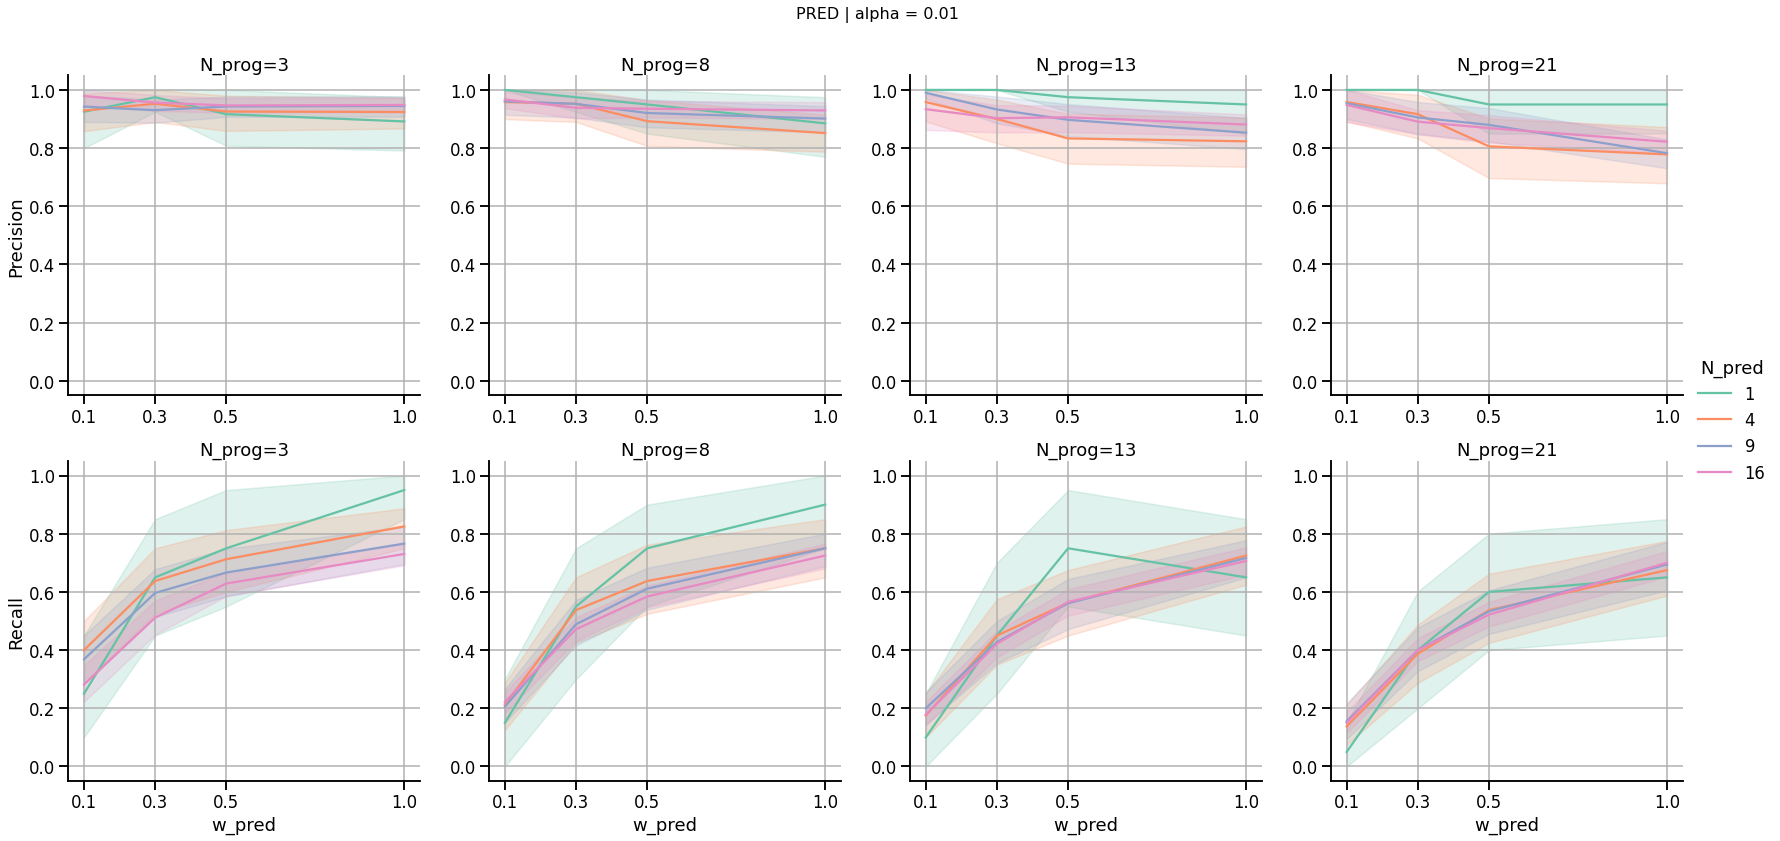

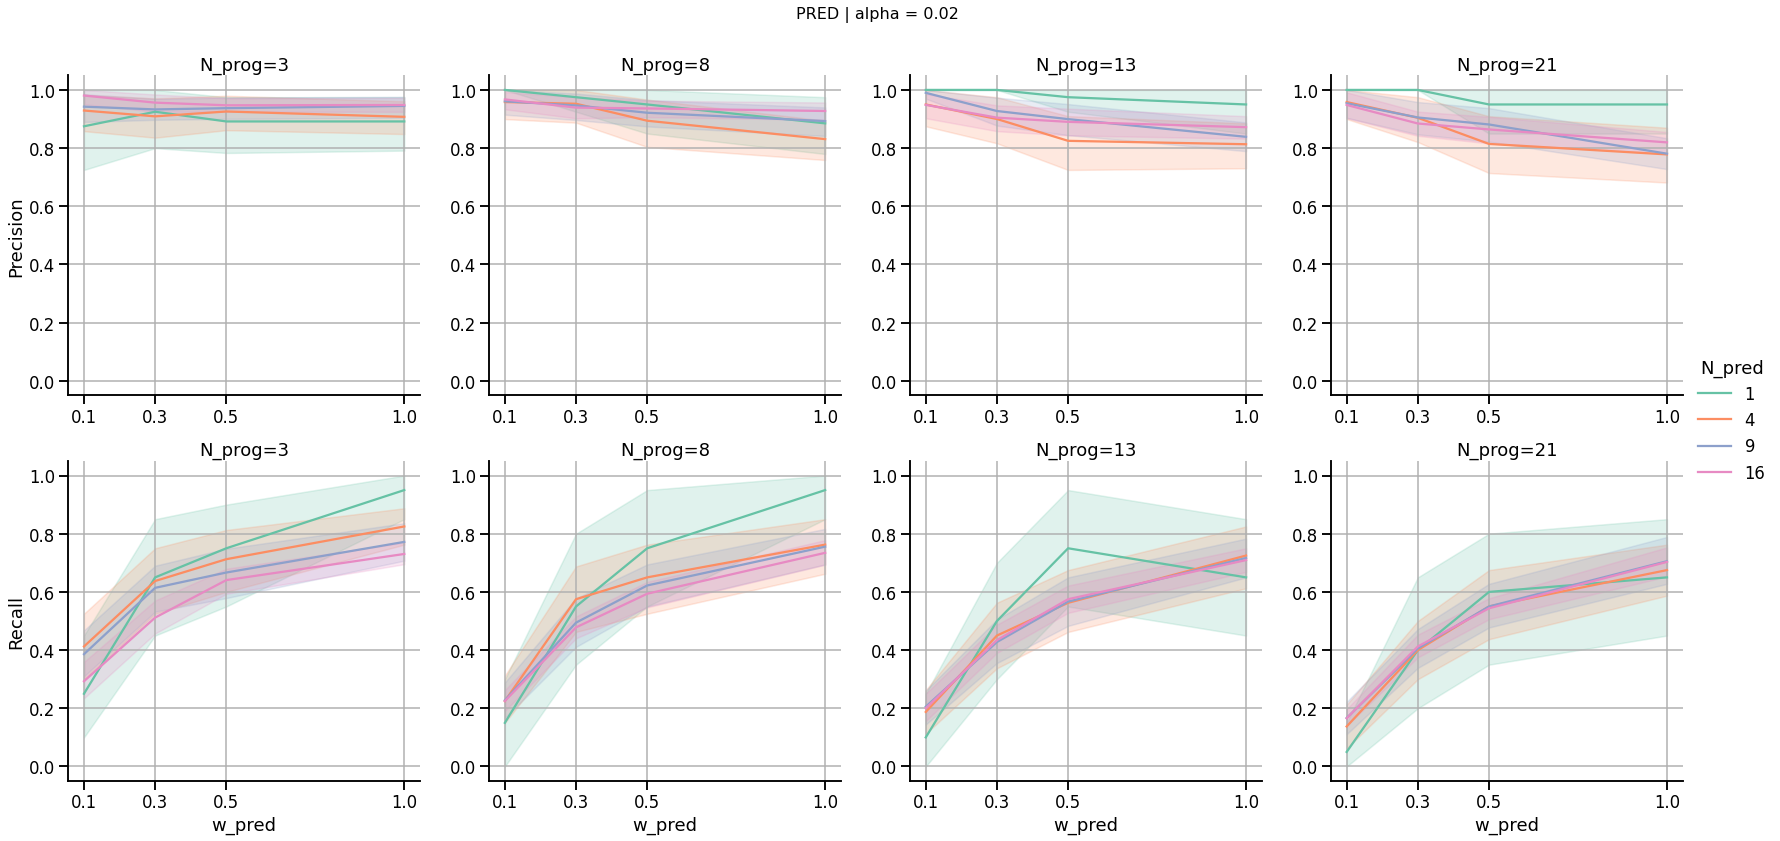

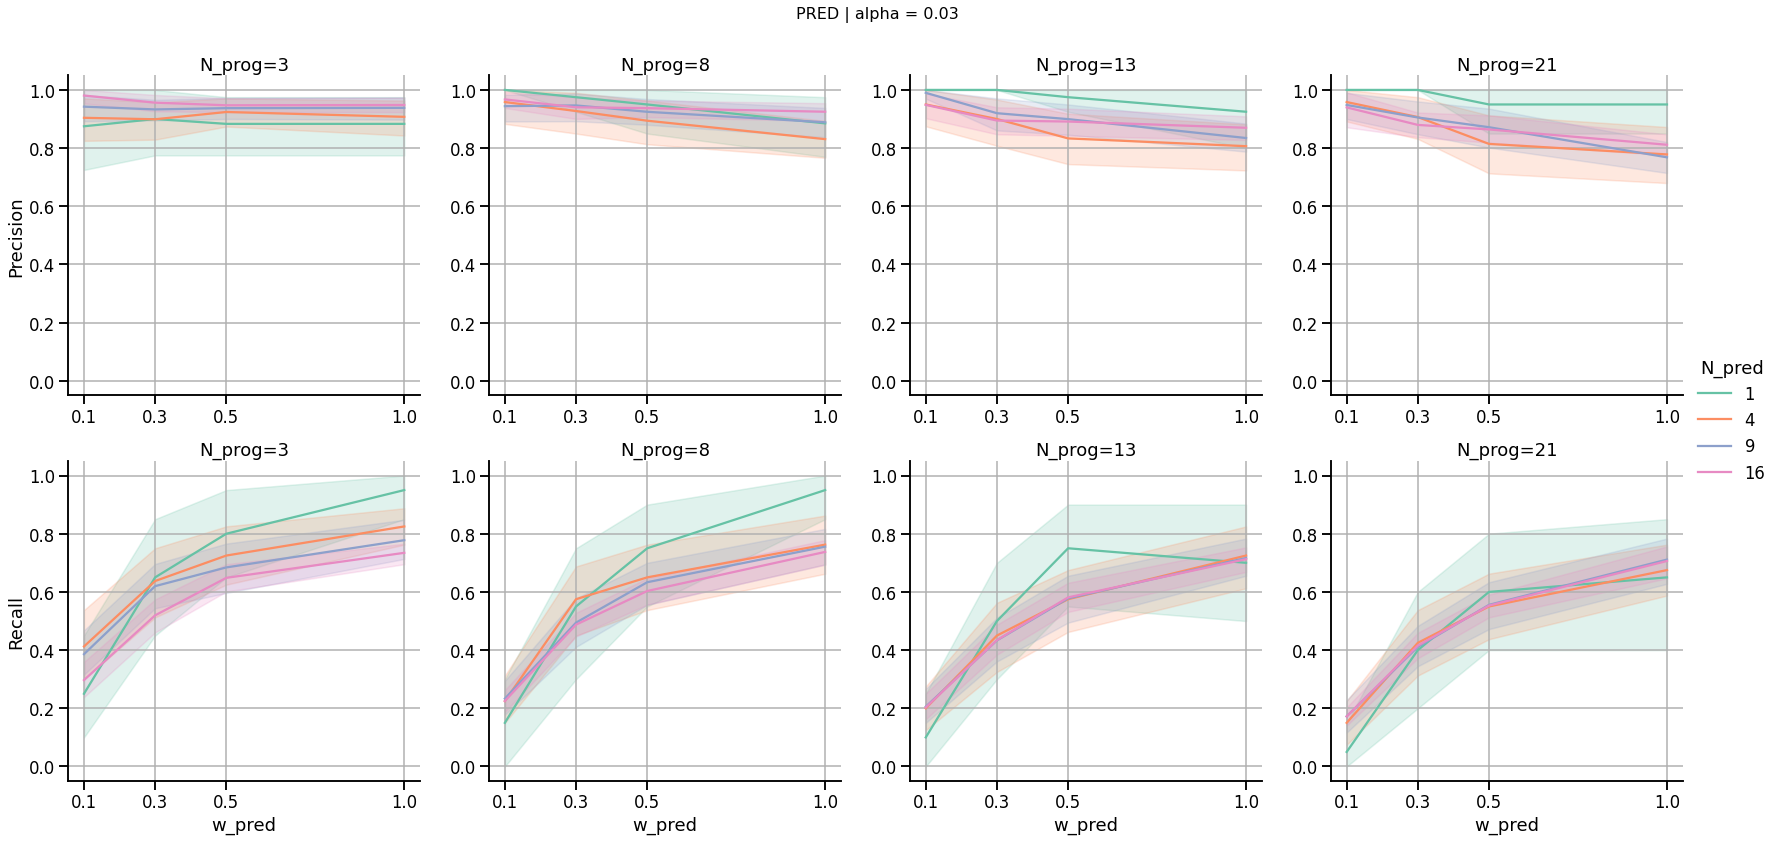

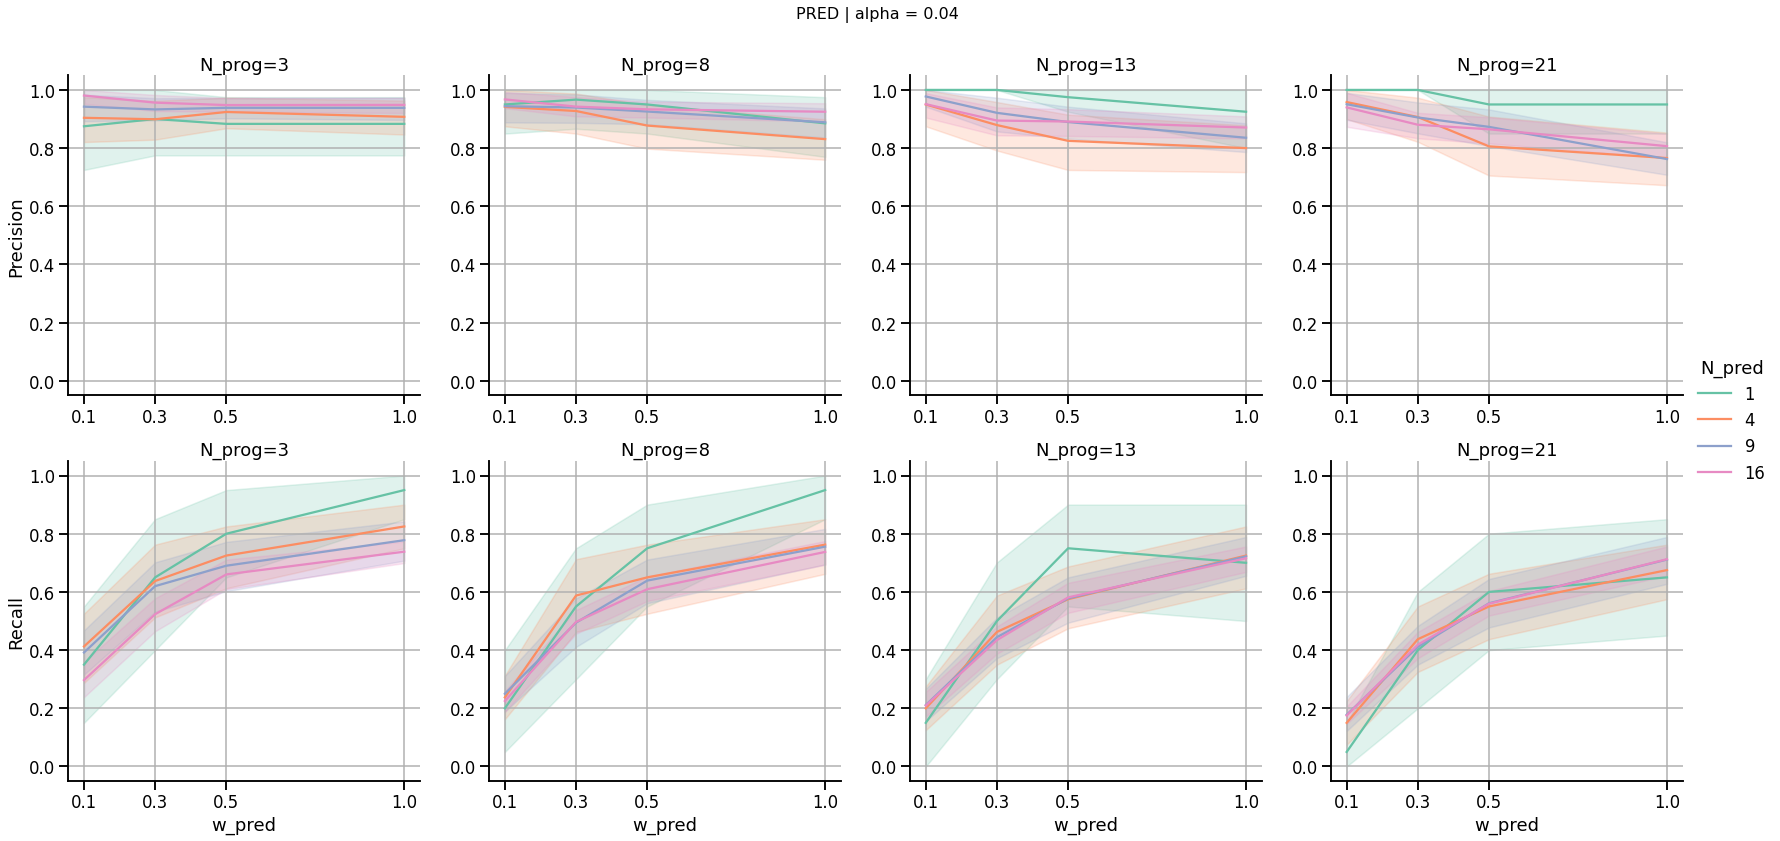

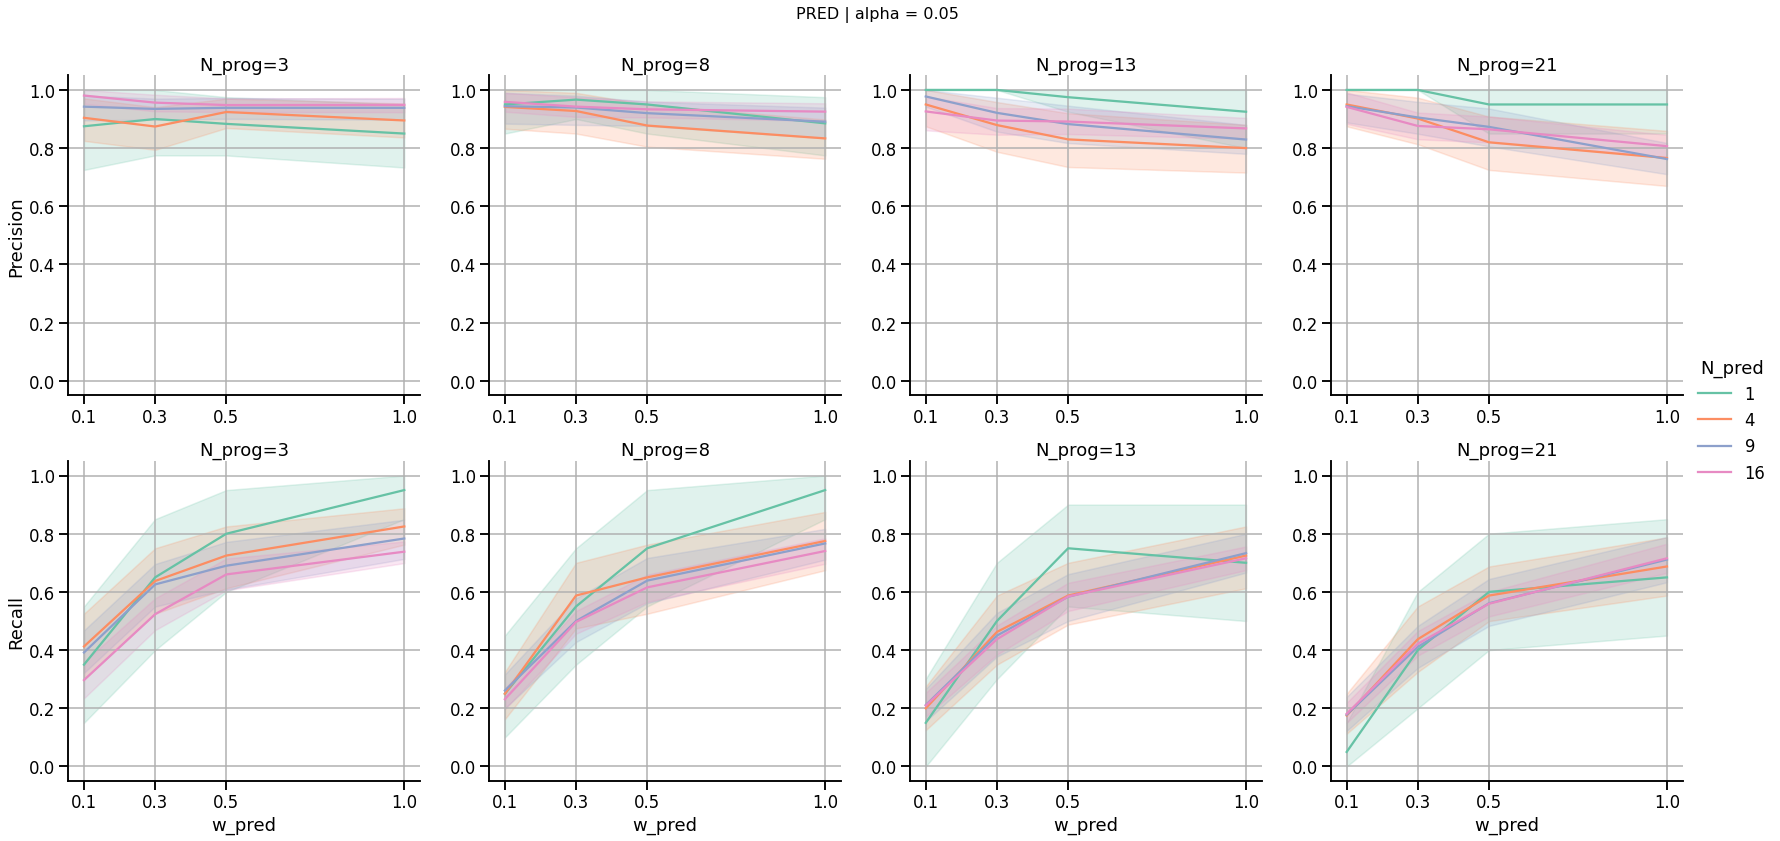

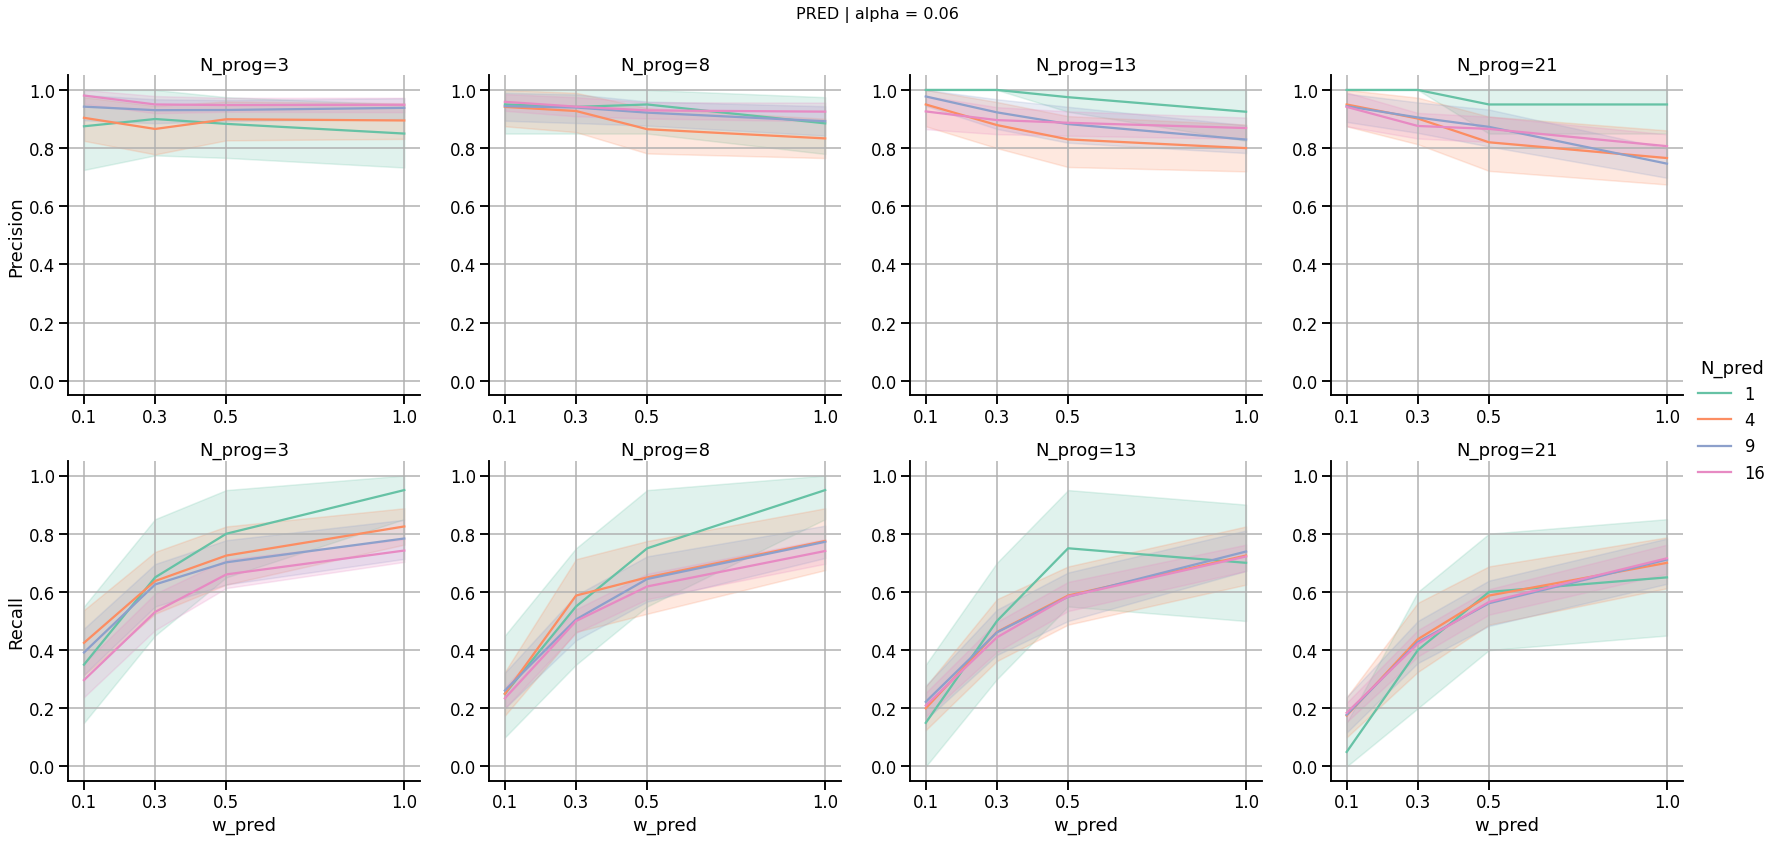

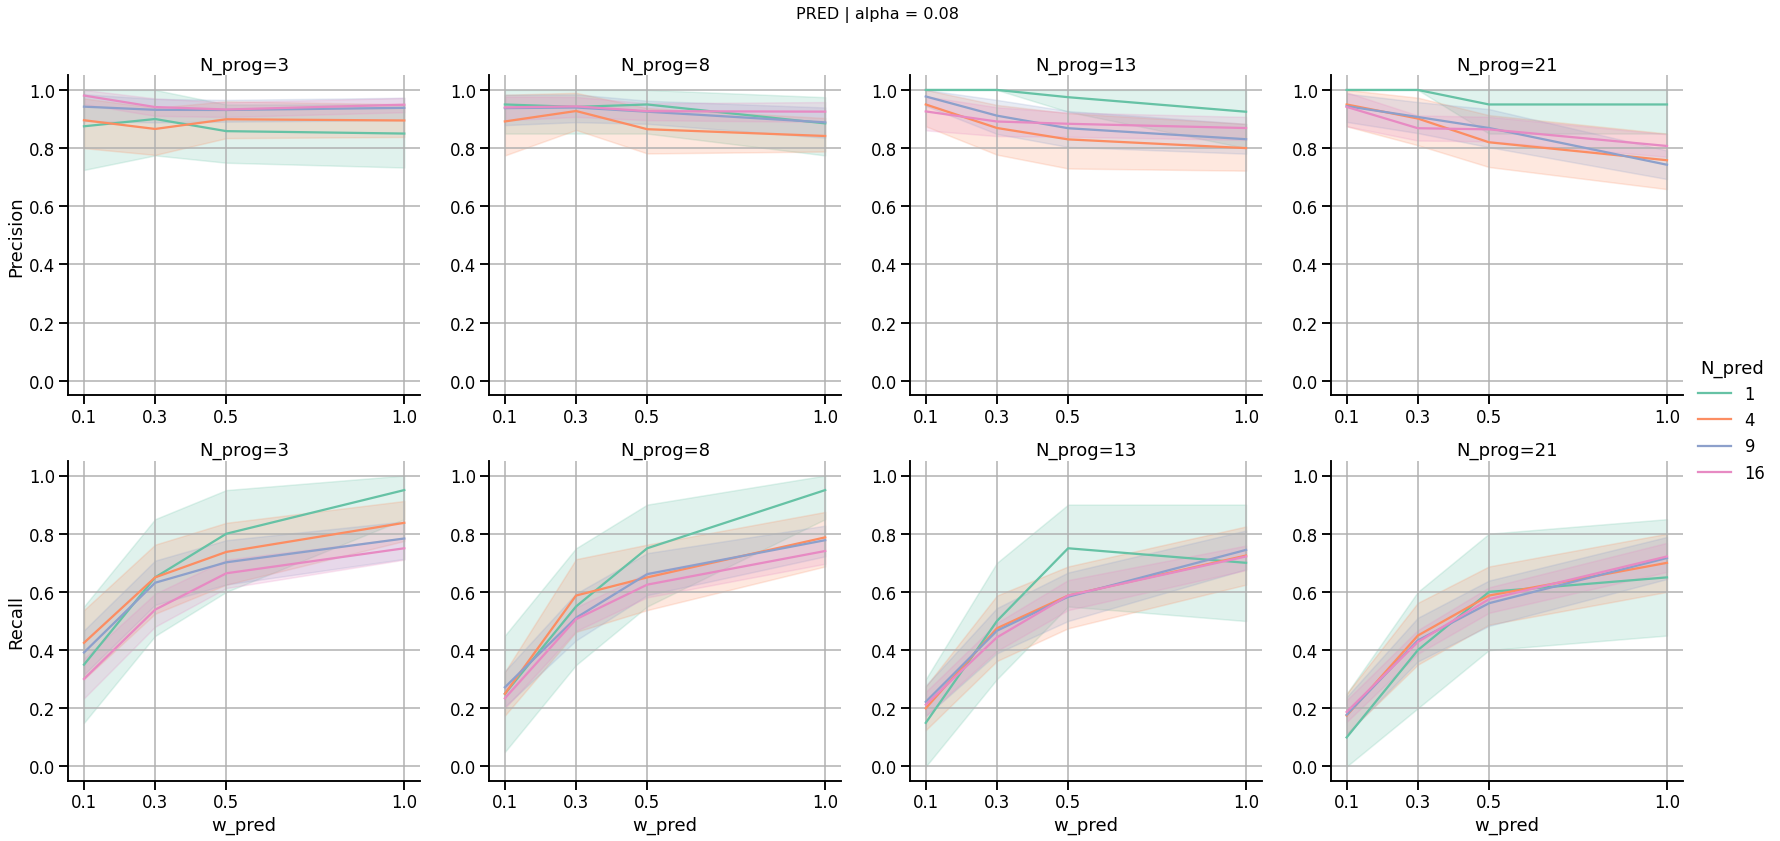

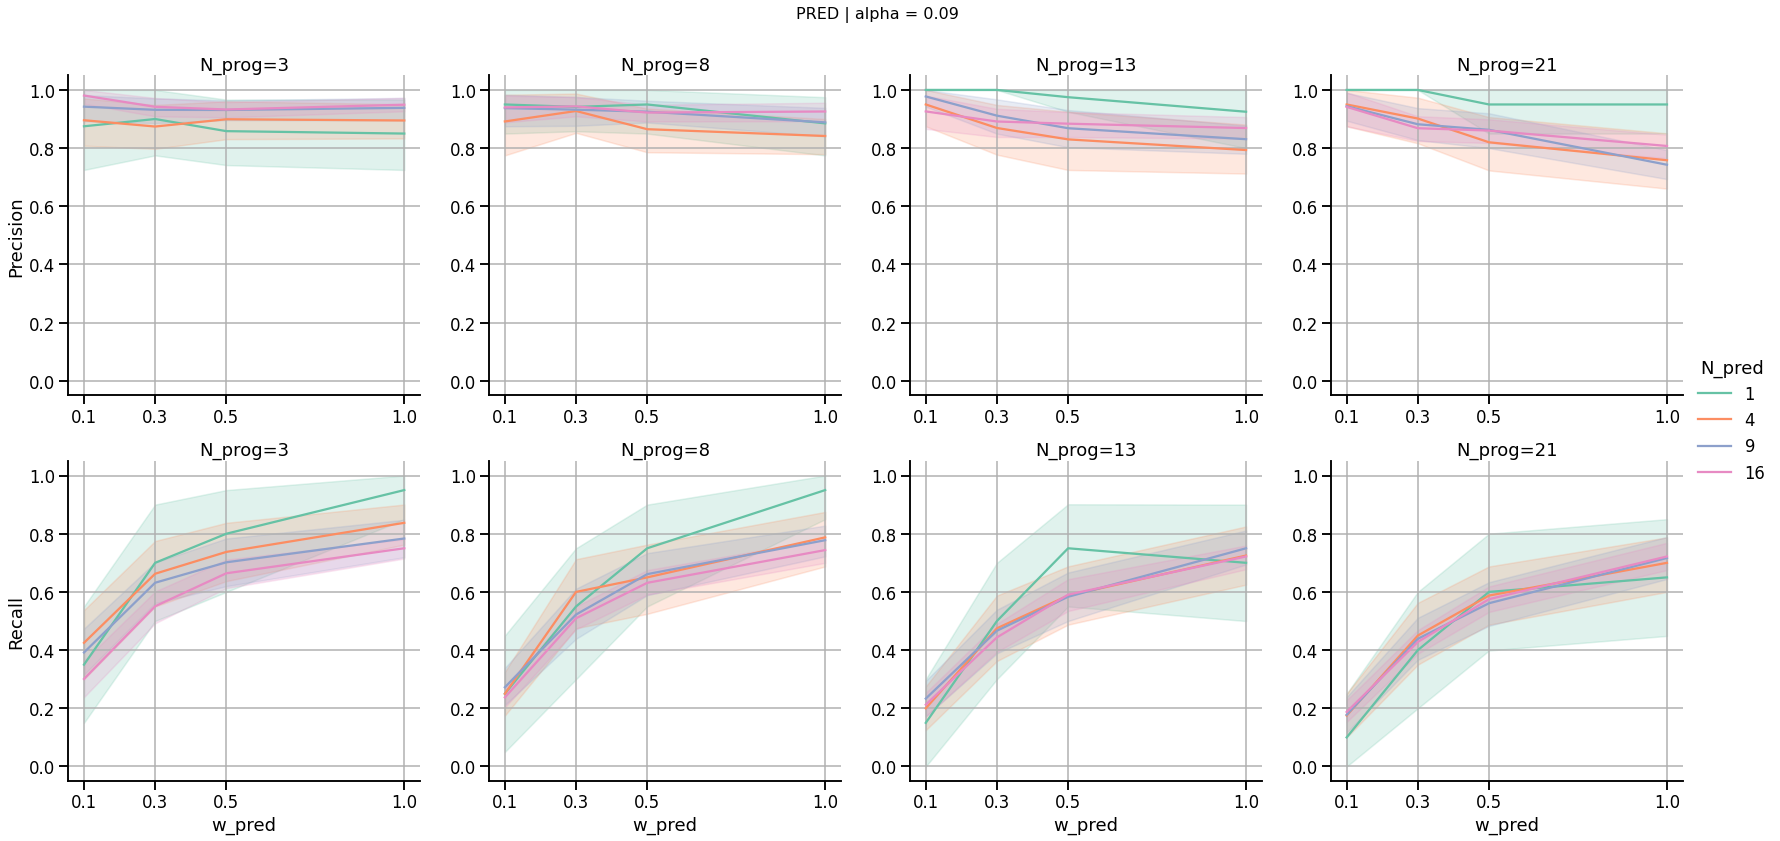

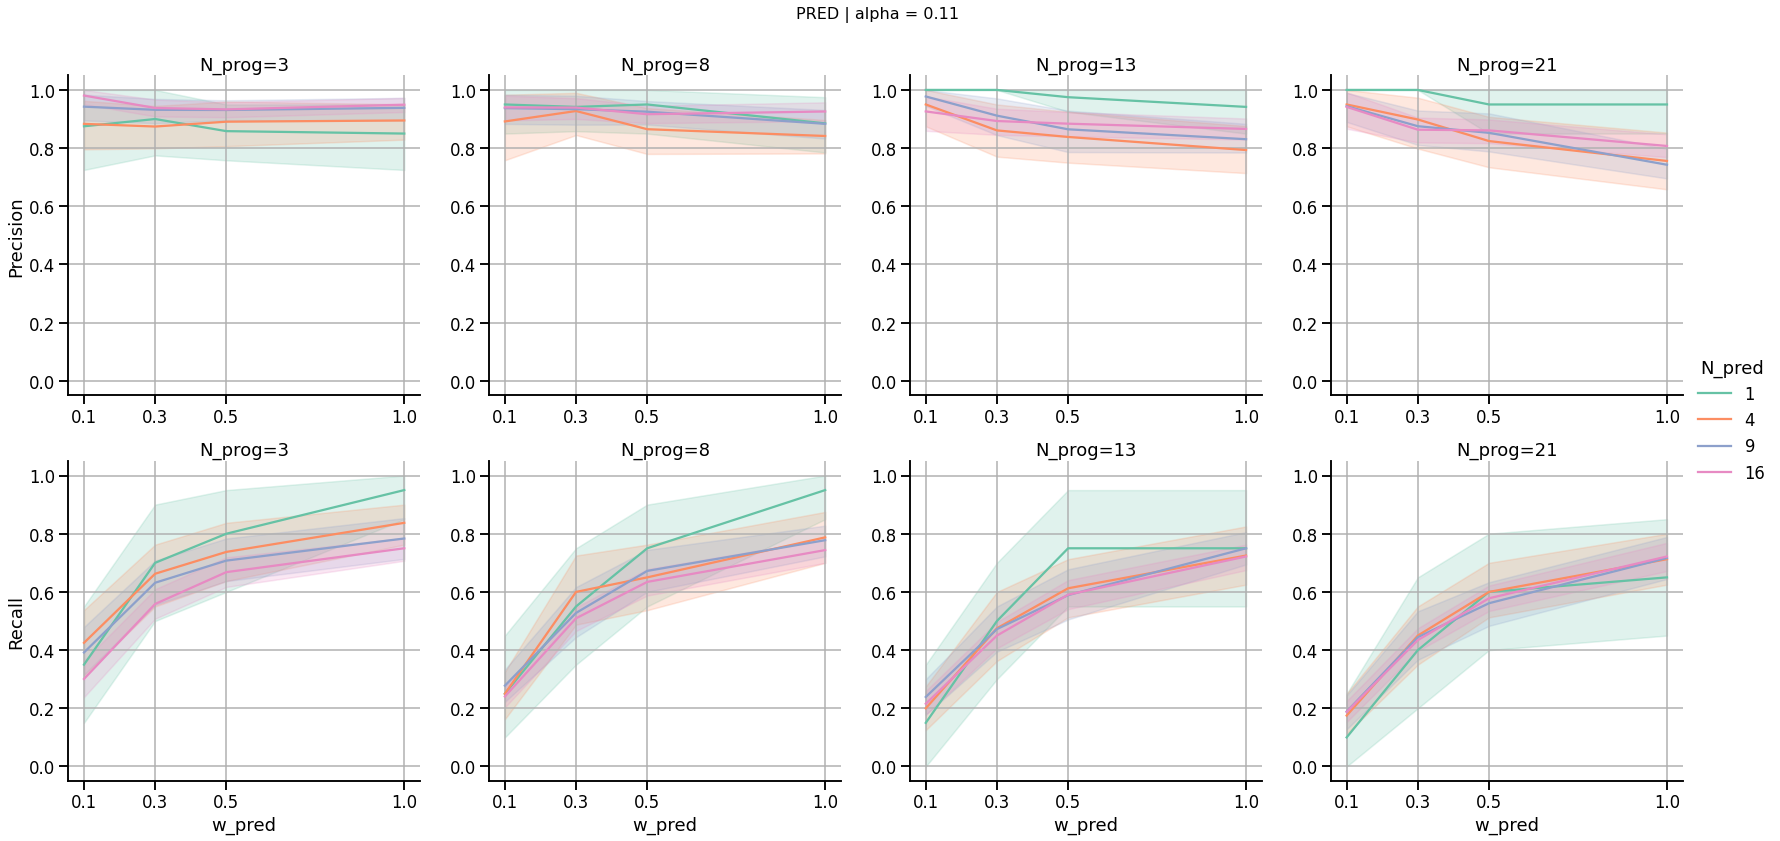

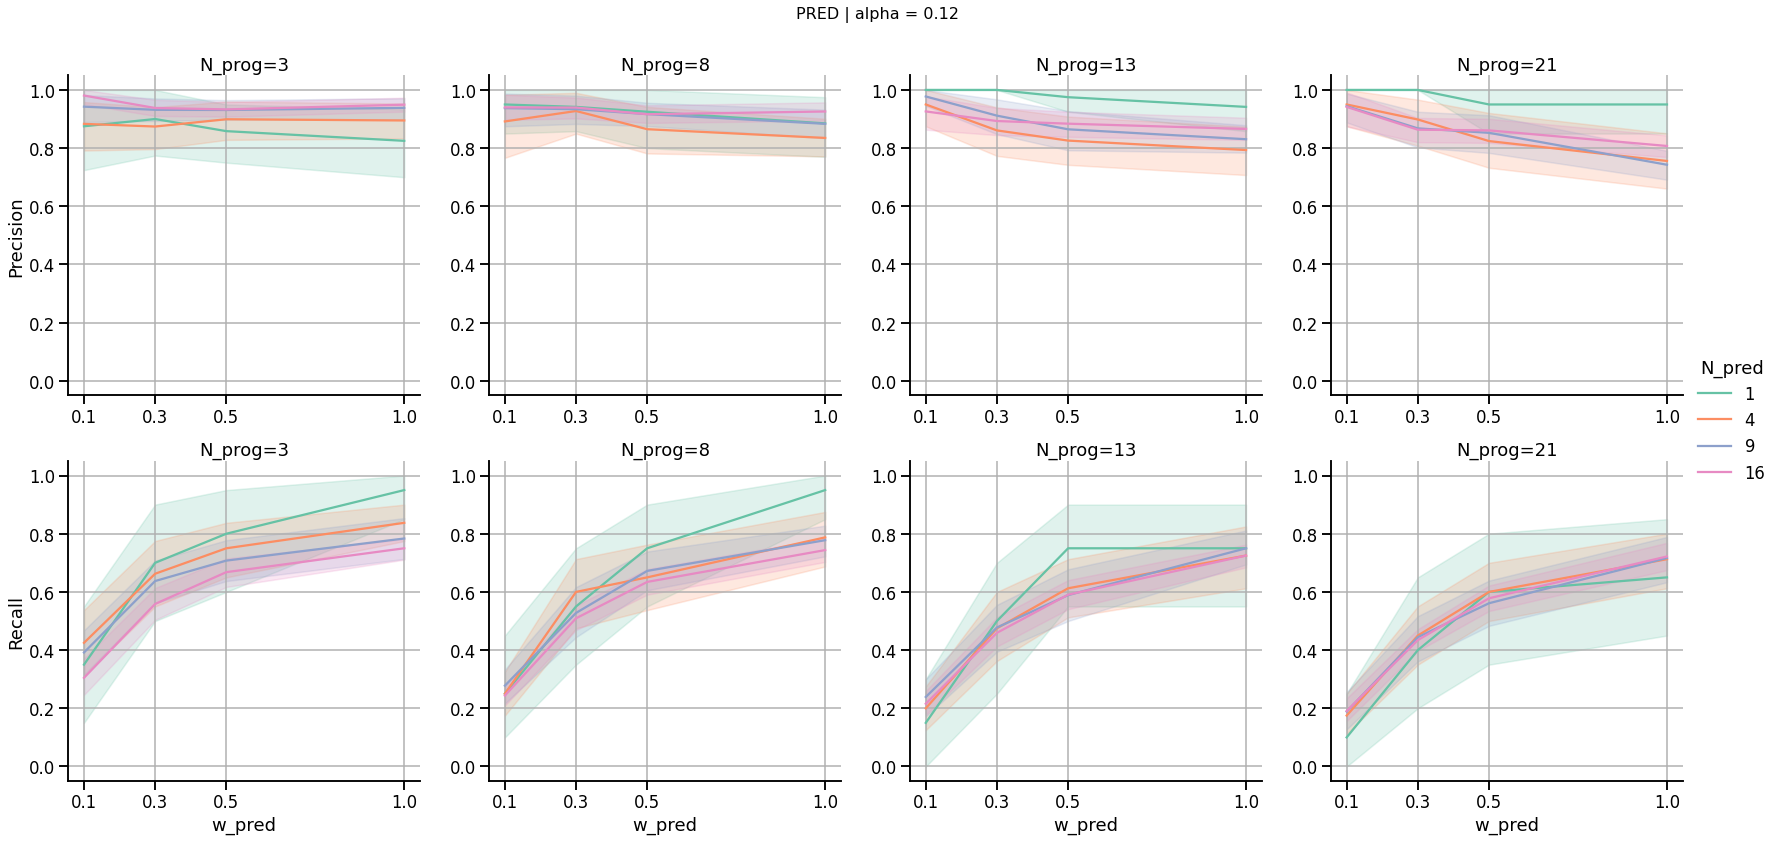

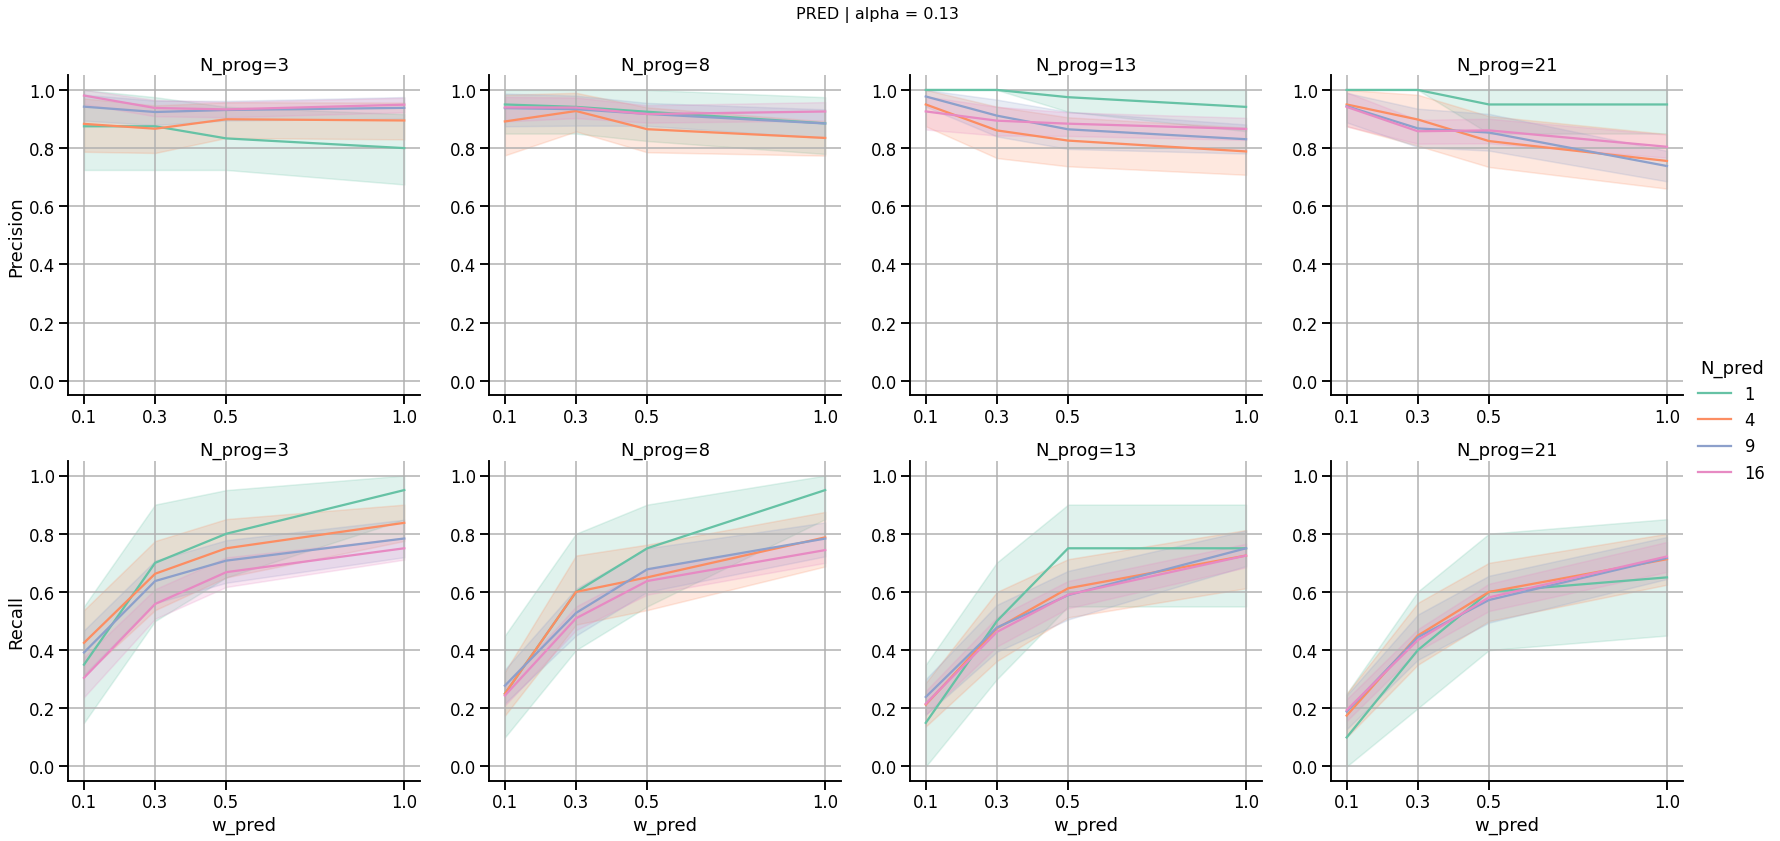

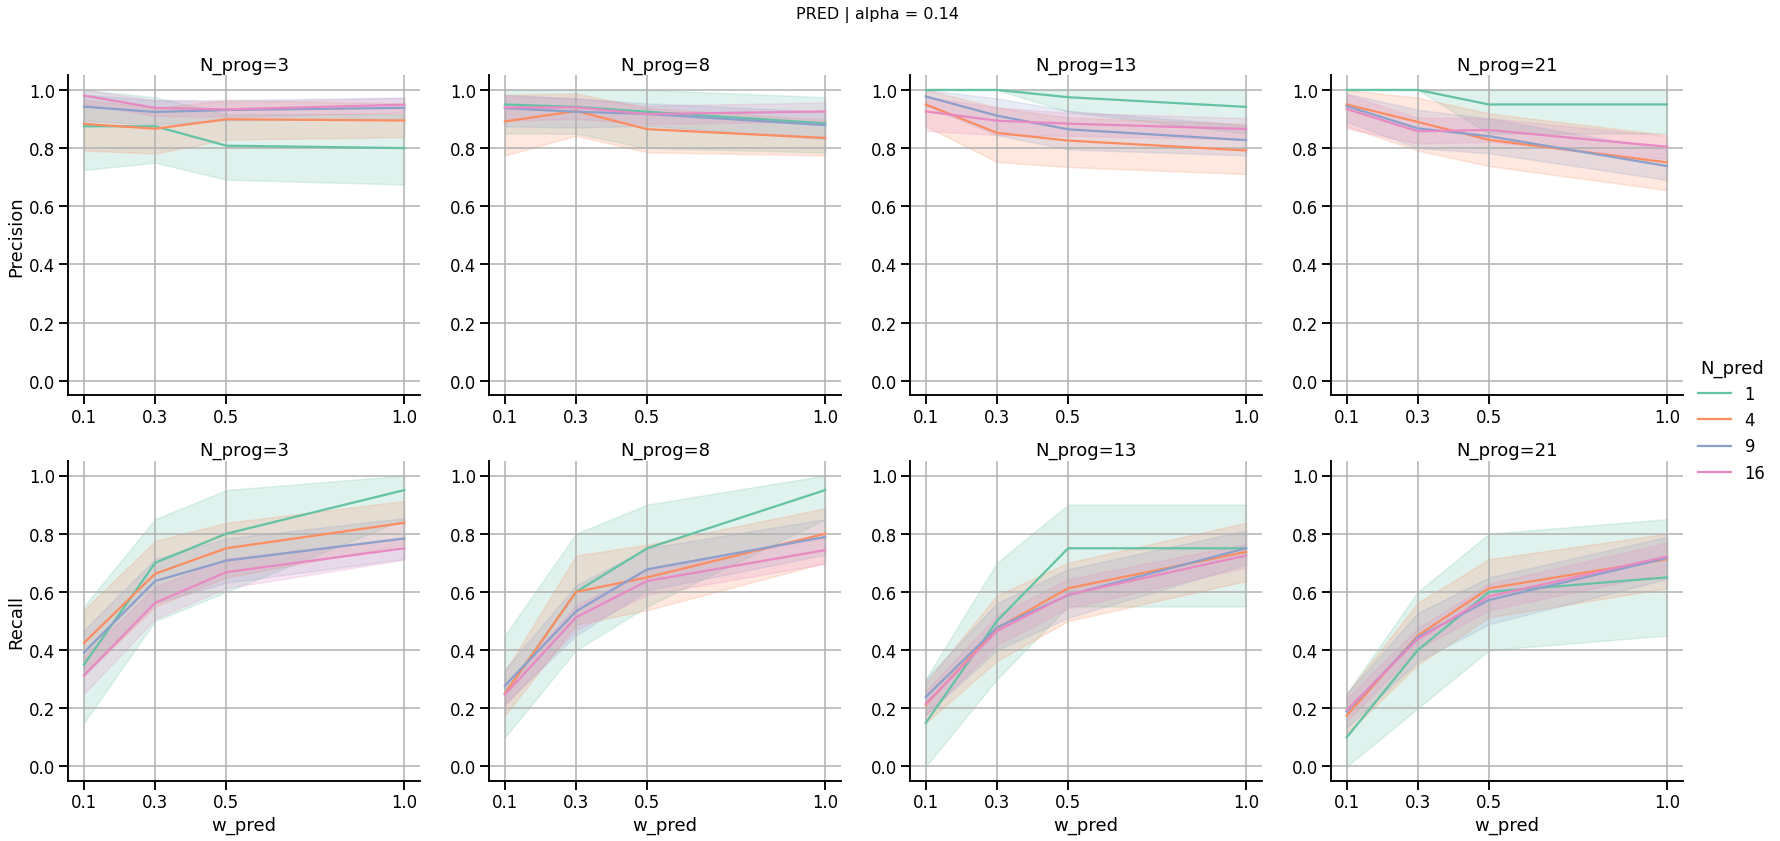

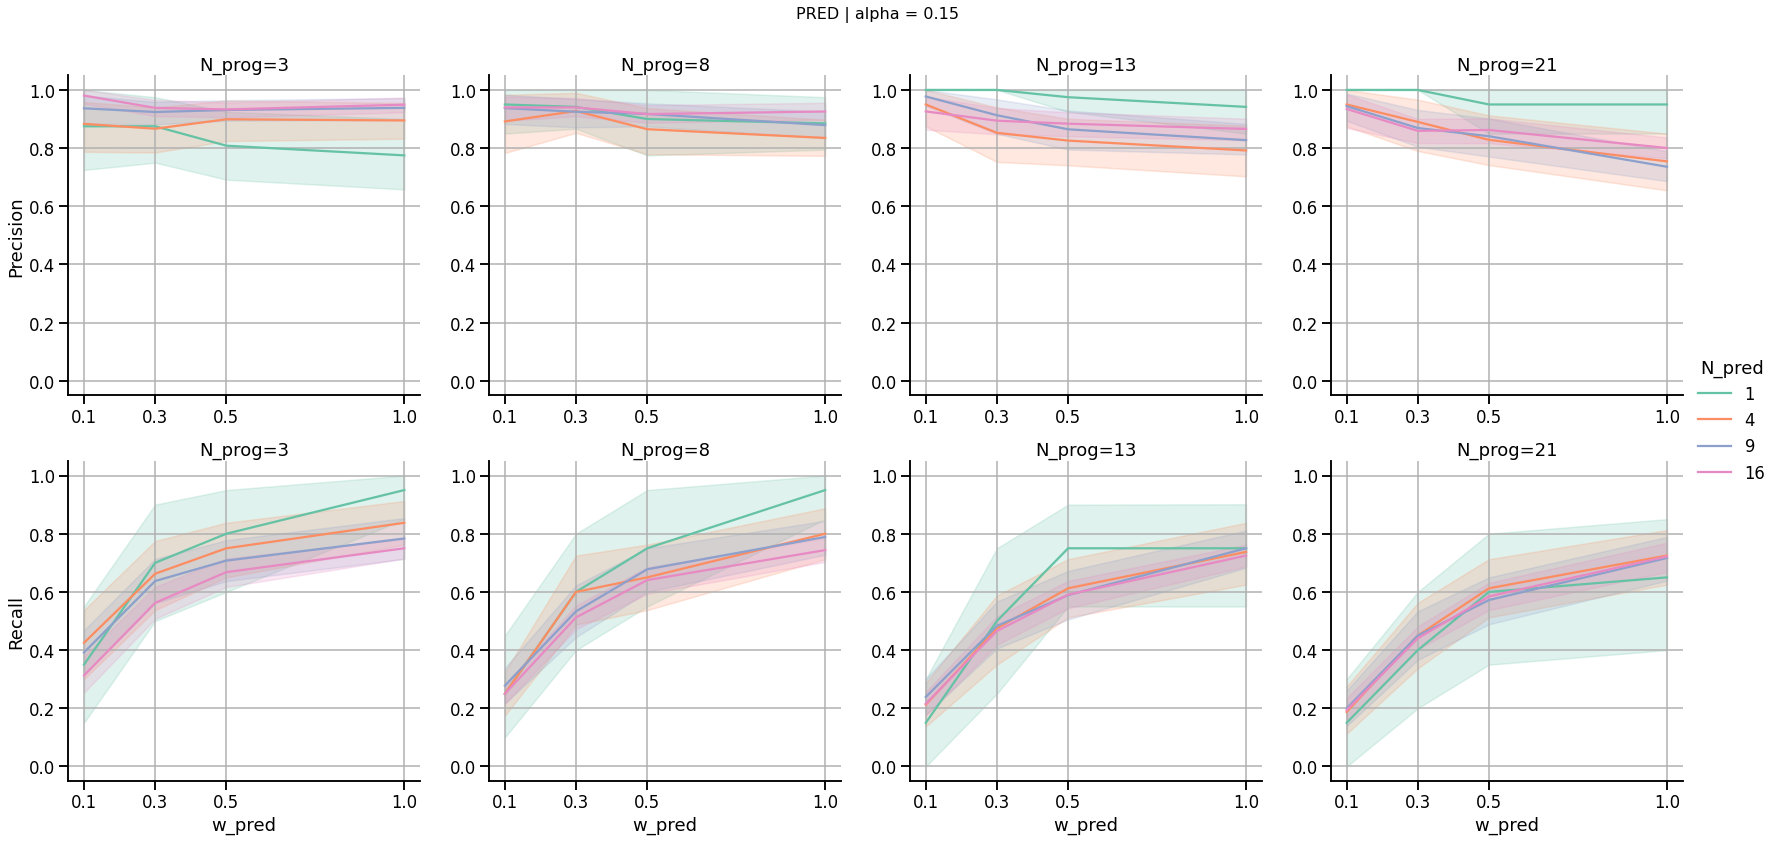

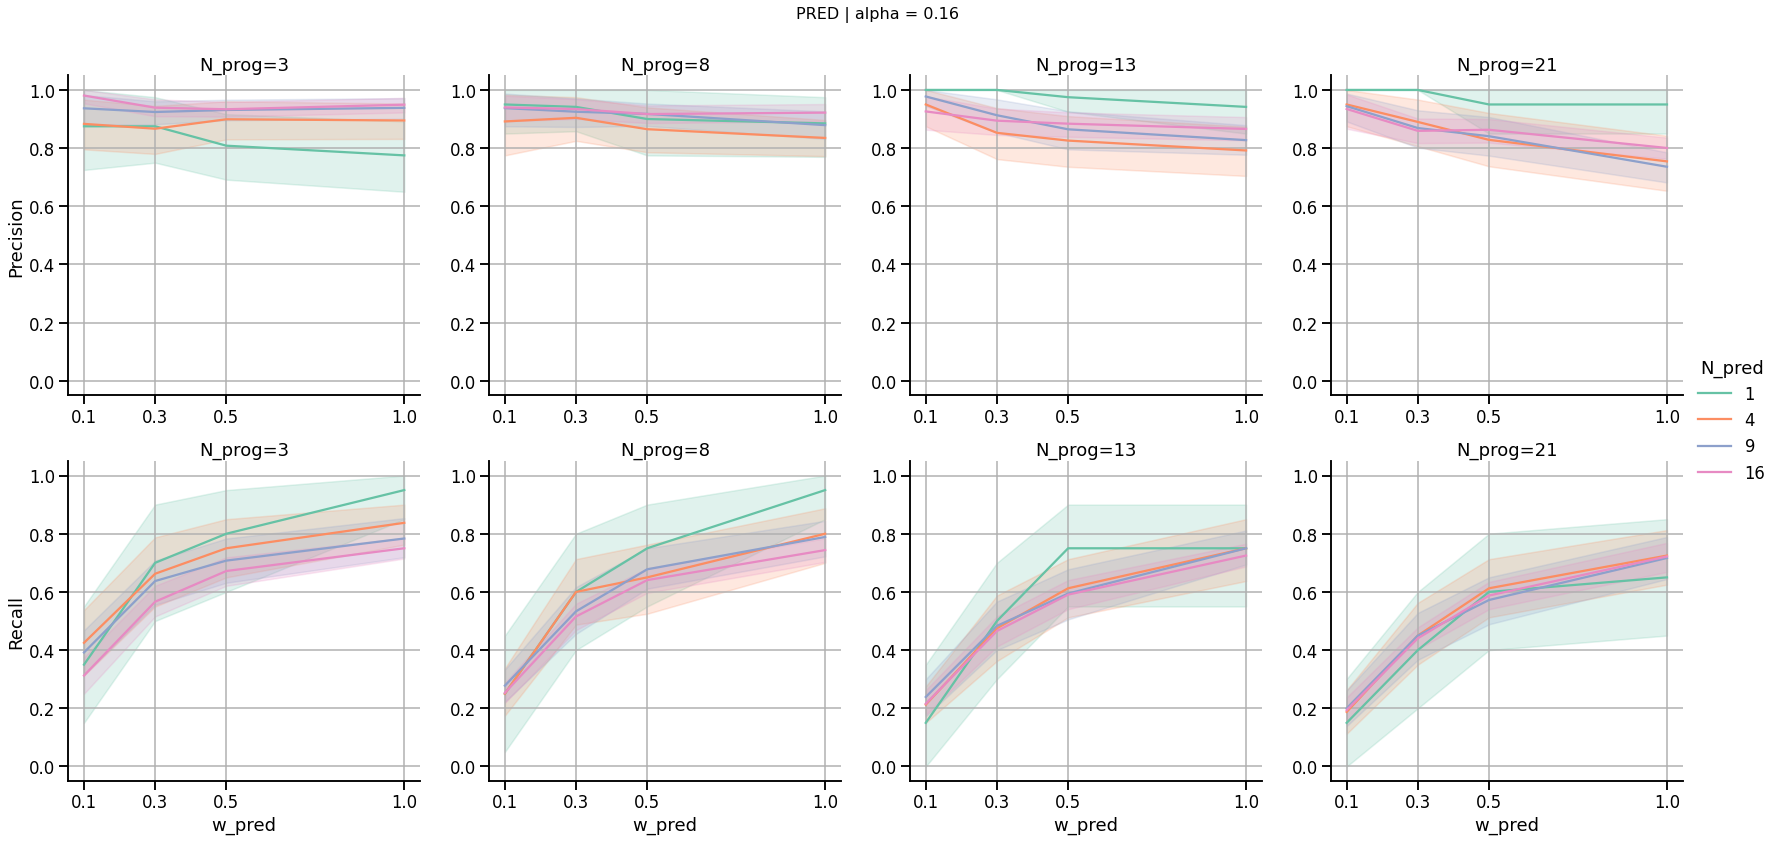

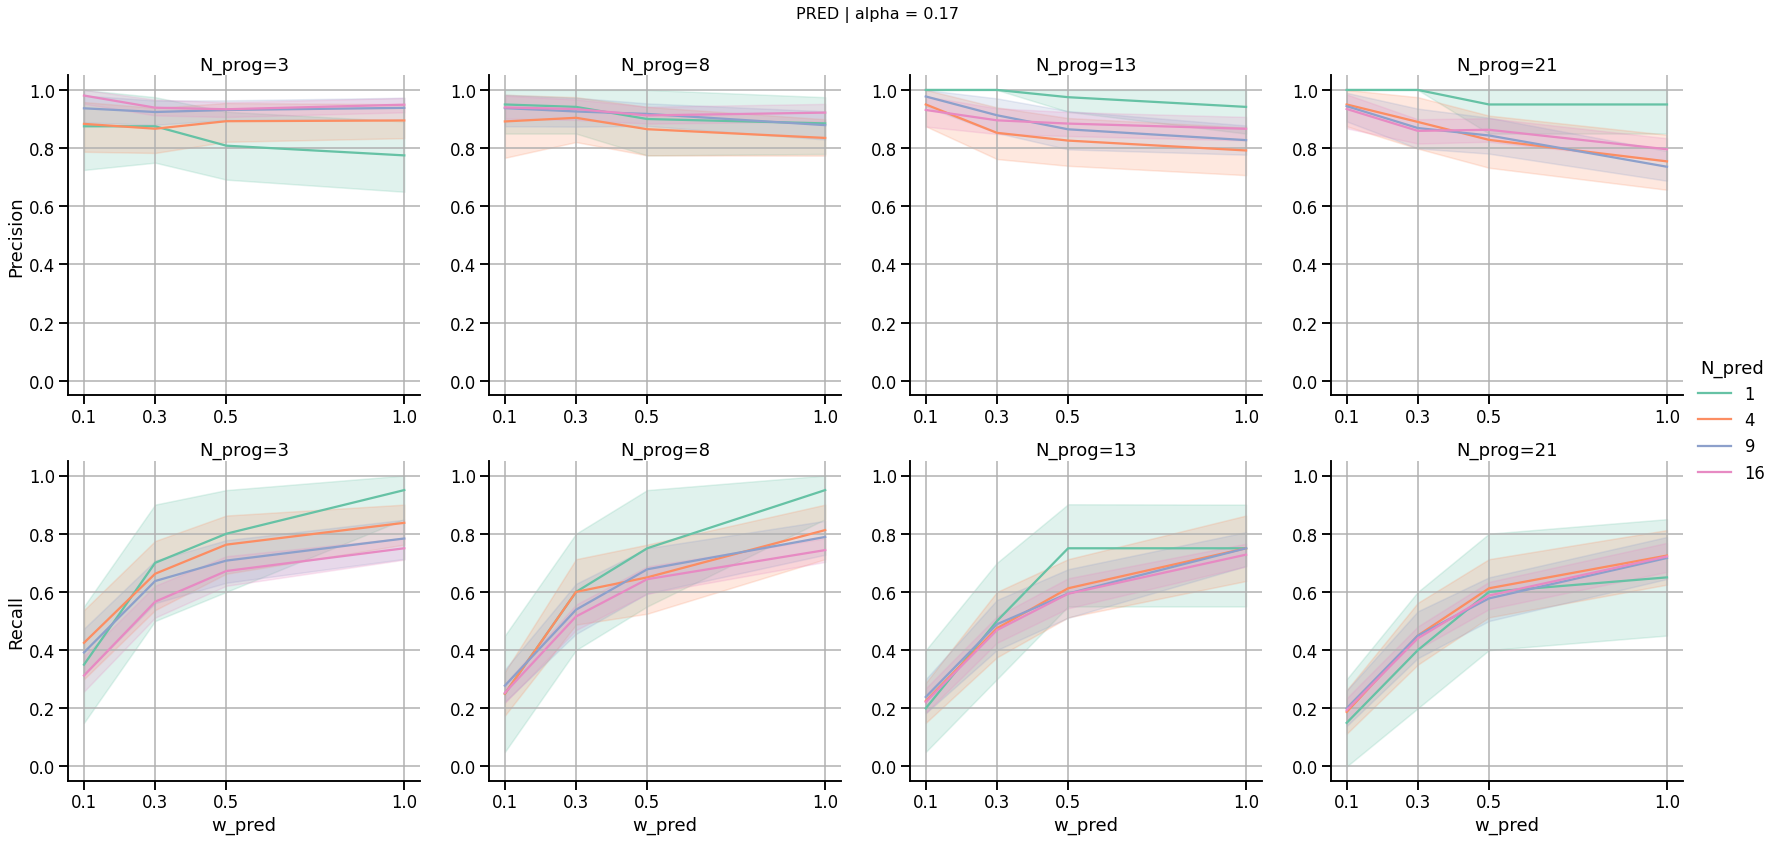

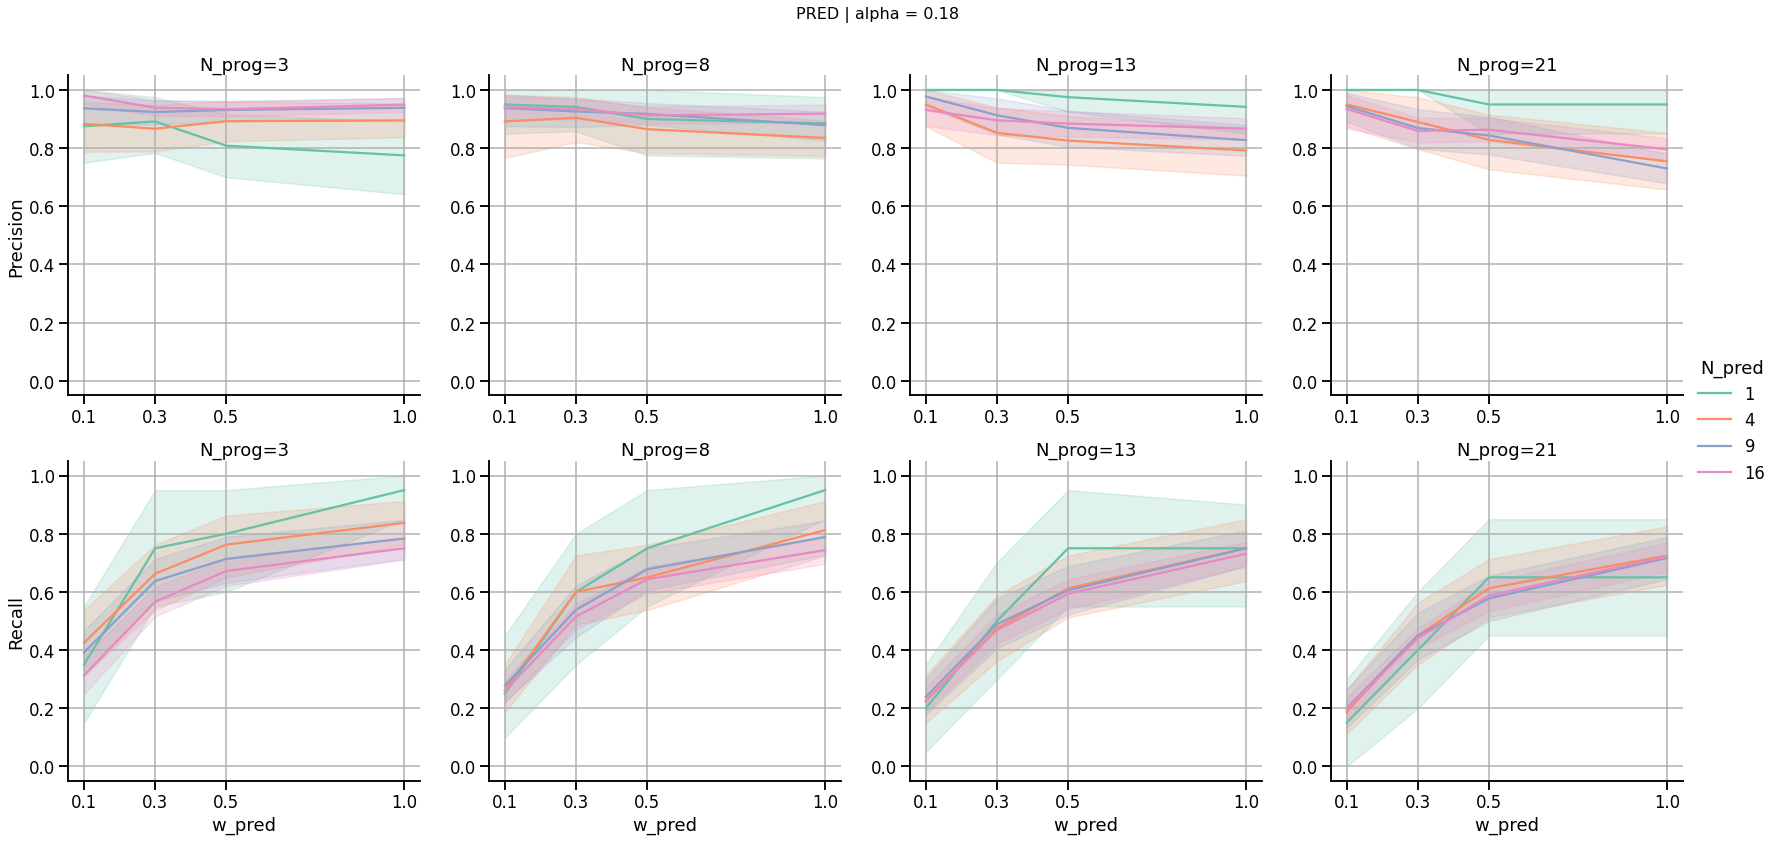

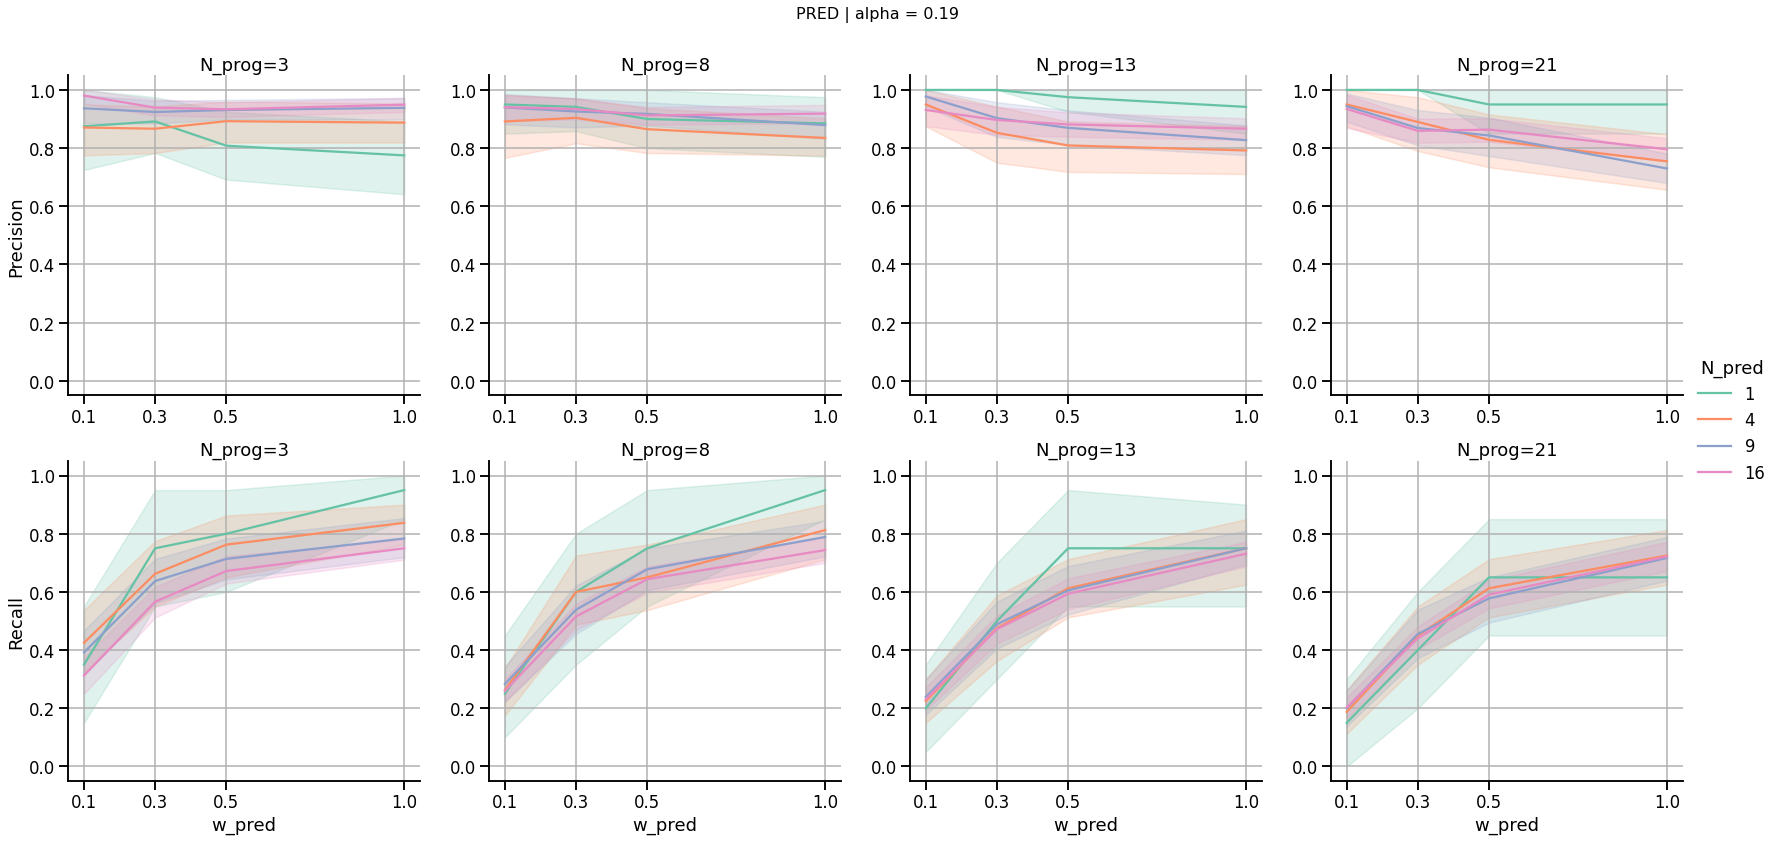

In [262]:
if semi_synthetic_bool:
    # for class_pred in plot_synthetic_df.Class.unique():
    class_pred = "PRED"
    for alpha in plot_synthetic_df.alpha.unique():
        sns.set_context("talk")
        row_order = ["Precision", "Recall"]
        row_names = ["Precision", "Recall"]
        #df["n_samples"] = df["n_samples"].map(lambda x: f"{x:,}")
        g = sns.relplot(
            data=plot_synthetic_df[(plot_synthetic_df.Class==class_pred)&(plot_synthetic_df.alpha==alpha)].melt(
            # data=plot_synthetic_df.melt(
                id_vars=["w_pred","N_pred","N_prog","Class"]
            ),
            kind="line",
            hue="N_pred",
            x="w_pred",
            y="value",
            col="N_prog",
            row="variable",
            palette="Set2",
            row_order=row_order,
            facet_kws={"sharey": False,"sharex":False},
            height=6,
        )

        axis_all = g.axes

        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle(str(class_pred) + " | alpha = "+str(alpha), fontsize=16)

        for axs_row in axis_all:  
            for axs in axs_row:
                axs.set_ylim([-0.05,1.05])
            
        g.set_titles("{col_var}={col_name}")
        for row_axs, row_name in zip(g.axes, row_names):
            row_axs[0].set_ylabel(row_name)

            for rows in row_axs:
                rows.grid()
                # rows.set_xscale("log")
                rows.set_xticks(ticks=[0.1,0.3,0.5,1.0])
                rows.set_xticklabels([0.1,0.3,0.5,1.0])
            
        # plt.savefig("results/semi_synthetic_all_results.jpg", bbox_inches="tight")
        # plt.savefig("results/semi_synthetic_all_results.pdf", bbox_inches="tight")
        # plt.savefig("results/semi_synthetic_all_results.png", bbox_inches="tight")

else:
    for alpha in plot_synthetic_df.alpha.unique():
        sns.set_context("talk")
        row_order = ["Precision", "Recall"]
        row_names = ["Precision", "Recall"]
        #df["n_samples"] = df["n_samples"].map(lambda x: f"{x:,}")
        g = sns.relplot(
            data=plot_synthetic_df[plot_synthetic_df.alpha==alpha].melt(
                id_vars=["synthetic_N","CONF_CASE","Class"]
            ),
            kind="line",
            hue="Class",
            x="synthetic_N",
            y="value",
            col="CONF_CASE",
            row="variable",
            palette="Set2",
            row_order=row_order,
            facet_kws={"sharey": False,"sharex":False},
            height=6,
        )

        axis_all = g.axes

        for axs_row in axis_all:  
            for axs in axs_row:
                axs.set_ylim([-0.05,1.05])
            
        g.set_titles("{col_var}={col_name}")

        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle(alpha, fontsize=16)

        for row_axs, row_name in zip(g.axes, row_names):
            row_axs[0].set_ylabel(row_name)

            for rows in row_axs:
                rows.grid()
                rows.set_xscale("log")
                rows.set_xticks(ticks=[100,250,500,1000,2500,5000,10000])
                rows.set_xticklabels([100,250,500,1000,2500,"5k","10k"])
            
        # plt.savefig("results/full_synthetic_all_results.jpg", bbox_inches="tight")
        # plt.savefig("results/full_synthetic_all_results.pdf", bbox_inches="tight")
        # plt.savefig("results/full_synthetic_all_results.png", bbox_inches="tight")

In [43]:
def Q_kstest(alpha):
    return np.sqrt(-0.5*np.log(1-alpha))

Q_kstest(0.02)

0.10050549068961225

In [ ]:
print("True predictive vars: " +str(ground_truth_pred_features))
print("Found predictive vars: " +str(predictive_vars))
print("Found candidate vars: " +str(candidate_vars))

for i in range(len(feature_set_pred)-1):

    data_all, cdf1, cdf2, cddiffs = cumsum_kstest(
        np.abs(pred_matrix_list[:-1,i])-np.abs(pred_matrix_list[:-1,-1]),
        np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1]),
    )

    # data_all, cdf1, cdf2, cddiffs = cumsum_kstest(
    #     np.abs(T1_matrix_list[:,i]),
    #     np.abs(prog_matrix_list[:,i]),
    # )

    print(st.kstest(  
                        np.abs(pred_matrix_list[:-1,i])-np.abs(pred_matrix_list[:-1,-1]),
                        np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1]),
                        alternative='greater'
                    ))
    
    p_value_print = st.kstest(  
                        np.abs(pred_matrix_list[:-1,i])-np.abs(pred_matrix_list[:-1,-1]),
                        np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1]),
                        alternative='greater'
                    )[1]

    calculated_D_ks = np.max(np.abs((cdf1 - cdf2)[cdf1 - cdf2 >= 0 ]))
    n_samples = len(np.abs(pred_matrix_list[:-1,i]))
    comp_D_ks = np.sqrt(n_samples)*calculated_D_ks
    alpha_ks = 0.02
    print("D statistic condition: "+str(np.sqrt(-0.5*np.log(1-alpha_ks))))
    print("D statistic: "+str(comp_D_ks))

    # print(r2_score(np.abs(prog_matrix_list[:,i]),np.abs(T1_matrix_list[:,i])))

    fig, axs = plt.subplots(1,2,figsize=(20,6))

    axs[0].plot(data_all,cdf1,label="tested feature")
    axs[0].plot(data_all,cdf2,label="random feature")
    axs[0].grid()
    # axs[0].set_xlim(data_all[np.sum(cdf2 < 0.001)-1],data_all[np.sum(cdf2 < 0.999)+1])
    axs[0].legend()
    axs[0].set_title("CDF functions : "+feature_set_pred[i] + " - predictive: "+str(True if feature_set_pred[i] in ground_truth_pred_features else False) + " - Found: " + str(True if feature_set_pred[i] in predictive_vars else False))


    axs[1].plot(data_all,cdf1 - cdf2)
    axs[1].grid()
    # axs[1].set_title("Difference above 0: " +str(np.mean(cdf1 - cdf2 > 0 )))
    axs[1].set_title("Difference (max) " +str(np.max(np.abs((cdf1 - cdf2)[cdf1 - cdf2 >= 0 ]))))

    plt.show()

In [ ]:
temp_df = pd.DataFrame(pred_matrix_list / np.mean(np.abs(prog_matrix_list),axis=0),columns=feature_set_pred).mean().abs().reset_index().rename(columns={0:'mean'})#.sort()
# temp_df = pd.DataFrame(np.abs(T1_matrix_list) - np.abs(prog_matrix_list),columns=feature_set_pred).mean().abs().reset_index().rename(columns={0:'mean'})#.sort()

temp_df["candidate_var"] = False
temp_df["predictive_var"] = False
temp_df["TRUE_predictive_var"] = False

for el in temp_df['index'].values:
    if el in candidate_vars:
        temp_df.loc[temp_df['index']==el,"candidate_var"] = True

    if el in predictive_vars:
        temp_df.loc[temp_df['index']==el,"predictive_var"] = True
        temp_df.loc[temp_df['index']==el,"candidate_var"] = True

    if el in ground_truth_pred_features:
        temp_df.loc[temp_df['index']==el,"TRUE_predictive_var"] = True

temp_df.sort_values("mean",ascending=False)

In [ ]:
informative_features = []
for i in range(len(alpha_prog)):
    if np.abs(alpha_prog[i]) > 0:
        informative_features.append('x'+str(i))

overlap_features = []
for el in ground_truth_pred_features:
    if el in informative_features:
        overlap_features.append(el)

false_positive_predictive_features = []
for el in predictive_vars:
    if el not in ground_truth_pred_features:
        false_positive_predictive_features.append(el)

false_positive_candidate_features = []
for el in candidate_vars:
    if el not in ground_truth_pred_features:
        false_positive_candidate_features.append(el)

print("Ground truth pred features" + str(ground_truth_pred_features))
print("informative features: "+ str(informative_features))
print("pred and prog features: "+str(overlap_features))
print("candidate vars: "+str(candidate_vars))
print("predictive vars: "+str(predictive_vars))
print("false positive predictive vars: "+str(false_positive_predictive_features))
print("false positive candidate vars: "+str(false_positive_candidate_features))

In [ ]:
for i in range(p):
    pred_alpha_string = "0.0"
    prog_alpha_string = "0.0"
    print_bool_features = False

    if np.abs(alpha_pred[i]) > 0:
        pred_alpha_string = str(np.round(w_pred*alpha_pred[i],4))
        print_bool_features = True
    if np.abs(alpha_prog[i]) > 0:
        prog_alpha_string = str(np.round(alpha_prog[i],4))
        print_bool_features = True

    if print_bool_features:
        print("x"+str(i) + " \t alpha_prog = "+prog_alpha_string + "\t alpha_pred = "+pred_alpha_string)



In [ ]:
print(30*"=")
print("PREDICTIVE VARS FALSE POSITIVES")
print(30*"=")
for el in false_positive_predictive_features:
    second_max_abs_correlation_value = np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False).iloc[1]
    second_max_abs_correlation_feature = np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False).index.values[1]
    print("FP feature : "+str(el))
    print("corr value = "+str(np.round(second_max_abs_correlation_value,3))+" | feature = "+str(second_max_abs_correlation_feature))
    print(15*"-")

print("")
print(30*"=")
print("CANDIDATE VARS FALSE POSITIVES")
print(30*"=")
for el in false_positive_candidate_features:
    second_max_abs_correlation_value = np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False).iloc[1]
    second_max_abs_correlation_feature = np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False).index.values[1]
    print("FP feature : "+str(el))
    print("corr value = "+str(np.round(second_max_abs_correlation_value,3))+" | feature = "+str(second_max_abs_correlation_feature))
    print(15*"-")

In [ ]:
if S_learner_bool:
    explainer = shap.TreeExplainer(model=predictive_CB)
else:
    explainer = shap.TreeExplainer(model=CB_T0)
shap_values_do0 = explainer.shap_values(X_causal_ITE_do0[feature_set_pred])
shap.summary_plot(shap_values_do0,X_causal_ITE_do0[feature_set_pred])

In [ ]:
if S_learner_bool:
    explainer = shap.TreeExplainer(model=predictive_CB)
else:
    explainer = shap.TreeExplainer(model=CB_T1)
shap_values_do1 = explainer.shap_values(X_causal_ITE_do1[feature_set_pred])
shap.summary_plot(shap_values_do1,X_causal_ITE_do1[feature_set_pred])

In [82]:
from statsmodels.stats.weightstats import ttost_ind,ttost_paired

True predictive vars: ['x4', 'x5', 'x9', 'x11', 'x20', 'x21', 'x26', 'x27', 'x28', 'T']
Found predictive vars: ['x10', 'x11', 'x26', 'x27', 'x28', 'x9']
Found candidate vars: ['x12', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x3', 'x4', 'x5', 'x6', 'x7']
-0.0022380311323480367
-0.0023548798852193013
old
Ttest_indResult(statistic=-1.1705633317254065, pvalue=0.24177713707969206)
new
Ttest_indResult(statistic=0.06111571170390657, pvalue=0.9512671787209053)


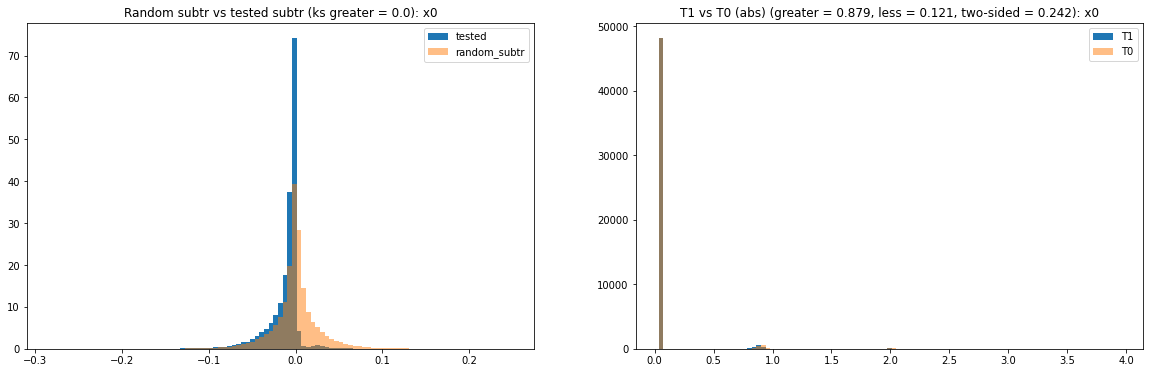

-0.027280098289602067
-0.0023548798852193013
old
Ttest_indResult(statistic=-21.528630424596564, pvalue=1.4472073015370504e-102)
new
Ttest_indResult(statistic=-19.670230274970784, pvalue=5.6727453934721804e-86)


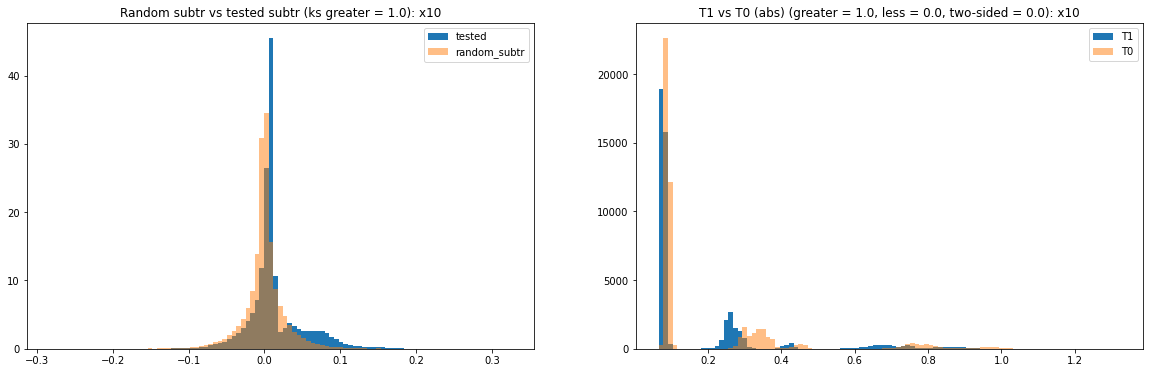

0.05890214370669594
-0.0023548798852193013
old
Ttest_indResult(statistic=73.47039908627595, pvalue=0.0)
new
Ttest_indResult(statistic=76.40771094081268, pvalue=0.0)


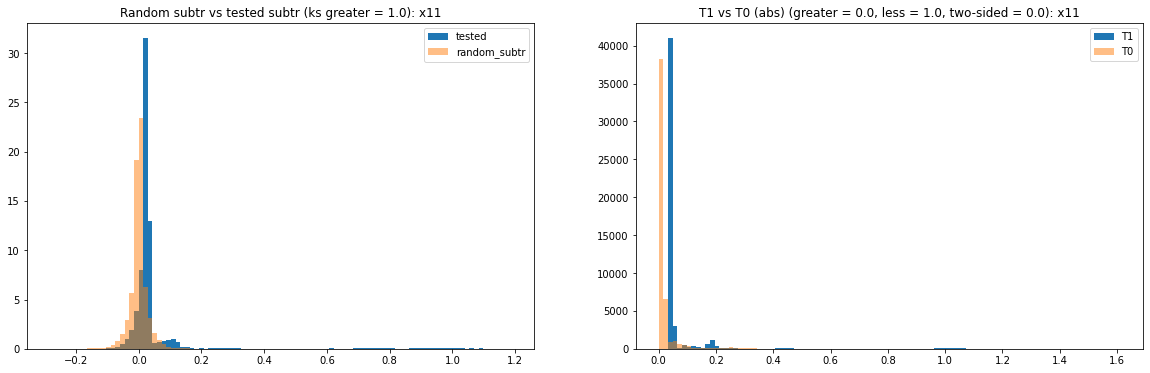

-0.00920012365901042
-0.0023548798852193013
old
Ttest_indResult(statistic=-13.743026228064236, pvalue=6.138119131449328e-43)
new
Ttest_indResult(statistic=-10.225336985396924, pvalue=1.5701924550942518e-24)


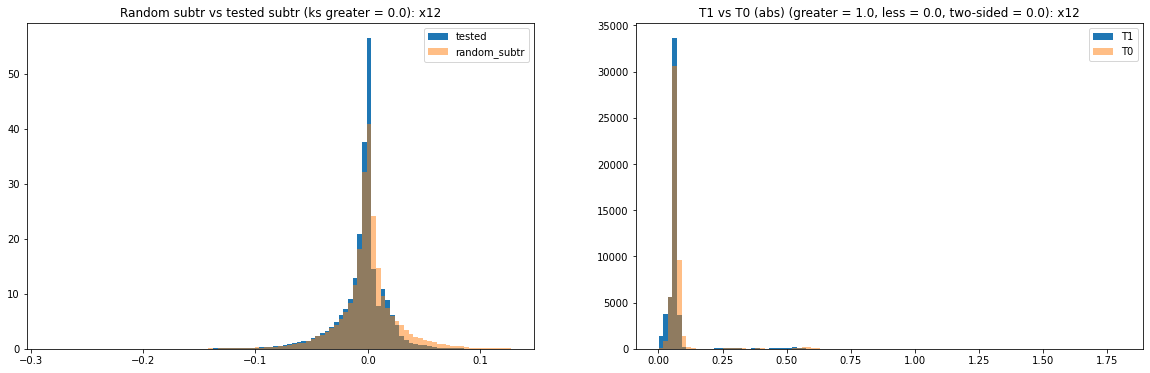

0.0005542665547927372
-0.0023548798852193013
old
Ttest_indResult(statistic=0.23840021187520358, pvalue=0.8115711921826838)
new
Ttest_indResult(statistic=1.251277244996747, pvalue=0.2108362751682229)


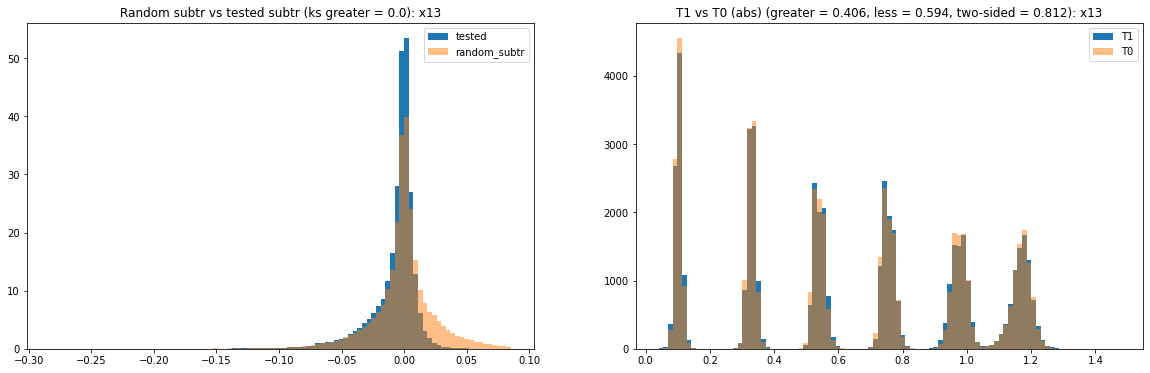

-0.004444191461099978
-0.0023548798852193013
old
Ttest_indResult(statistic=-1.1630952340543412, pvalue=0.24479364431618475)
new
Ttest_indResult(statistic=-0.5467965000229525, pvalue=0.5845197694497692)


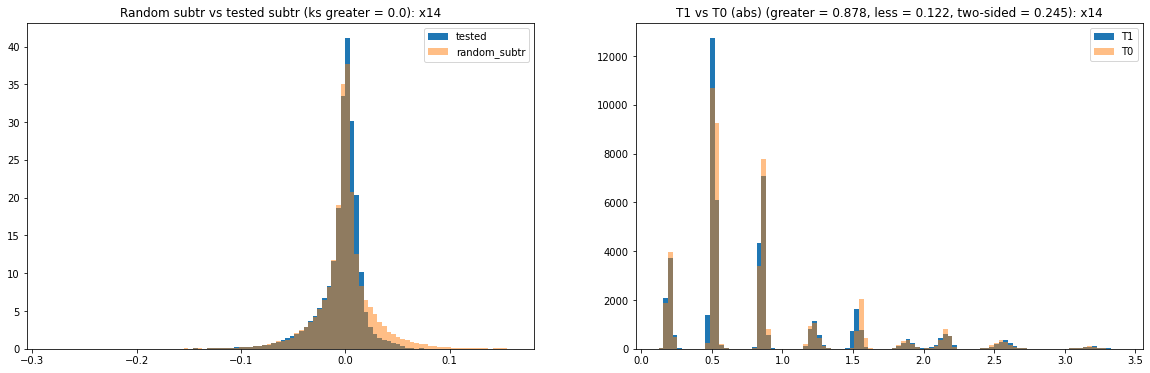

0.00023089469553951372
-0.0023548798852193013
old
Ttest_indResult(statistic=0.6383789937400149, pvalue=0.523228465370824)
new
Ttest_indResult(statistic=7.149164561993278, pvalue=8.790244905441529e-13)


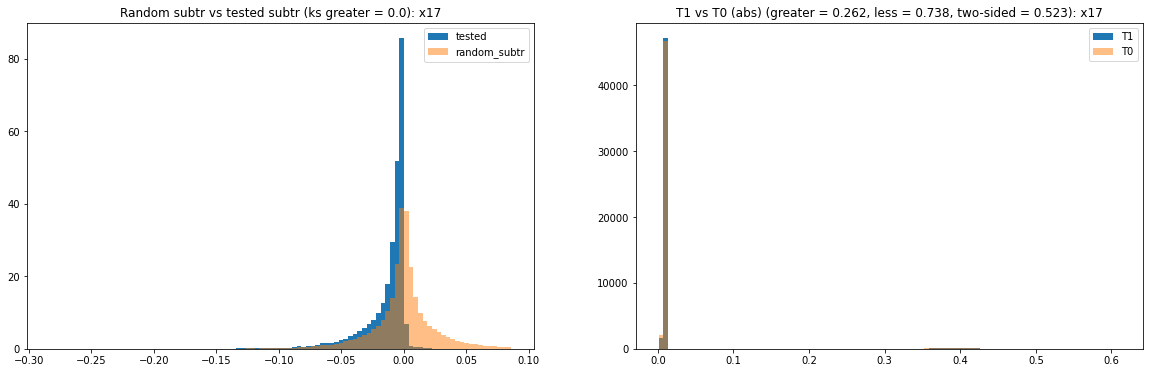

0.0008149433543506862
-0.0023548798852193013
old
Ttest_indResult(statistic=0.781019703435379, pvalue=0.43479275739178147)
new
Ttest_indResult(statistic=3.037872992392273, pvalue=0.002383158461742177)


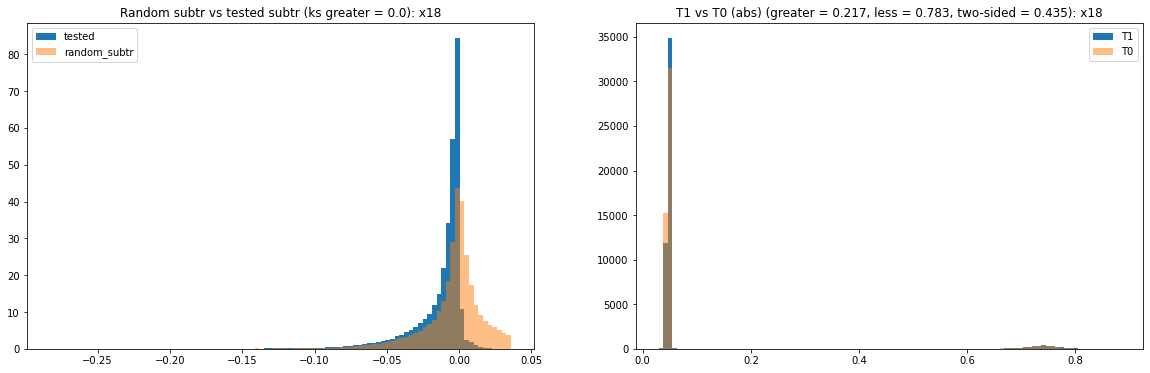

0.001050487757671803
-0.0023548798852193013
old
Ttest_indResult(statistic=3.4218404978847983, pvalue=0.0006222369353513617)
new
Ttest_indResult(statistic=11.092585159161741, pvalue=1.416377069957033e-28)


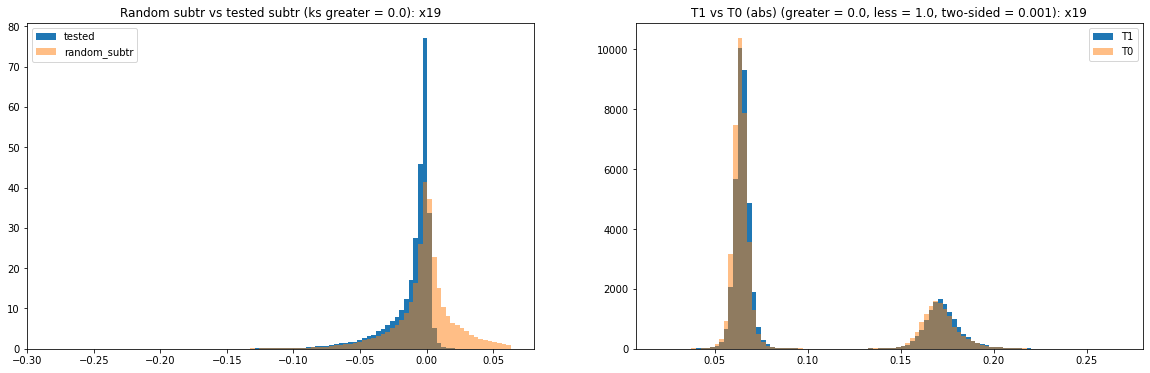

0.010084769625556156
-0.0023548798852193013
old
Ttest_indResult(statistic=0.8033964406889944, pvalue=0.42174754349724597)
new
Ttest_indResult(statistic=0.9909963748749945, pvalue=0.3216897511094787)


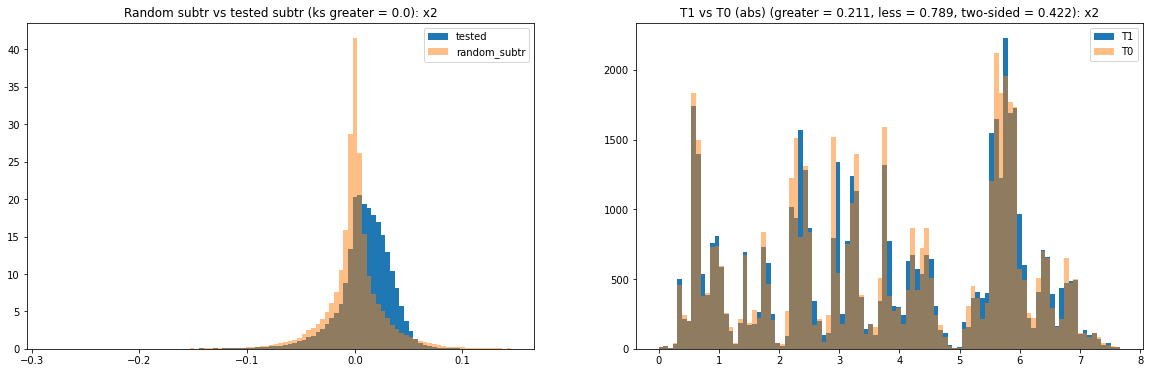

0.0
-0.0023548798852193013
old
Ttest_indResult(statistic=0.0, pvalue=1.0)
new
Ttest_indResult(statistic=311.8913940726693, pvalue=0.0)


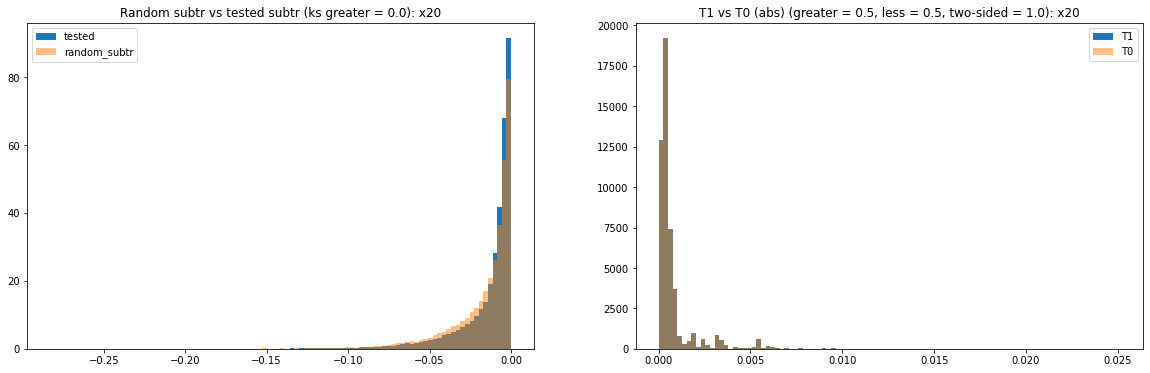

-0.022090279071842564
-0.0023548798852193013
old
Ttest_indResult(statistic=-45.452309025177215, pvalue=0.0)
new
Ttest_indResult(statistic=-40.606977378978435, pvalue=0.0)


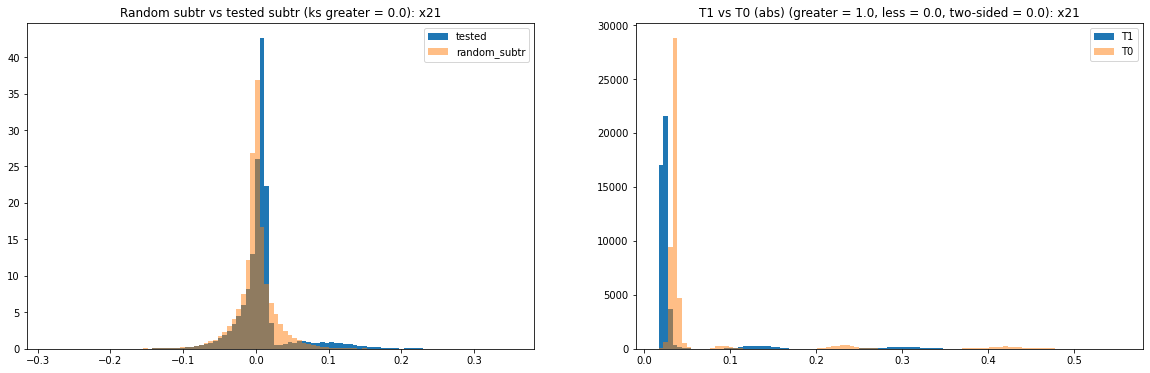

0.0021462052296019607
-0.0023548798852193013
old
Ttest_indResult(statistic=1.8602321923165555, pvalue=0.0628556218480885)
new
Ttest_indResult(statistic=3.9013339989392635, pvalue=9.572672320897659e-05)


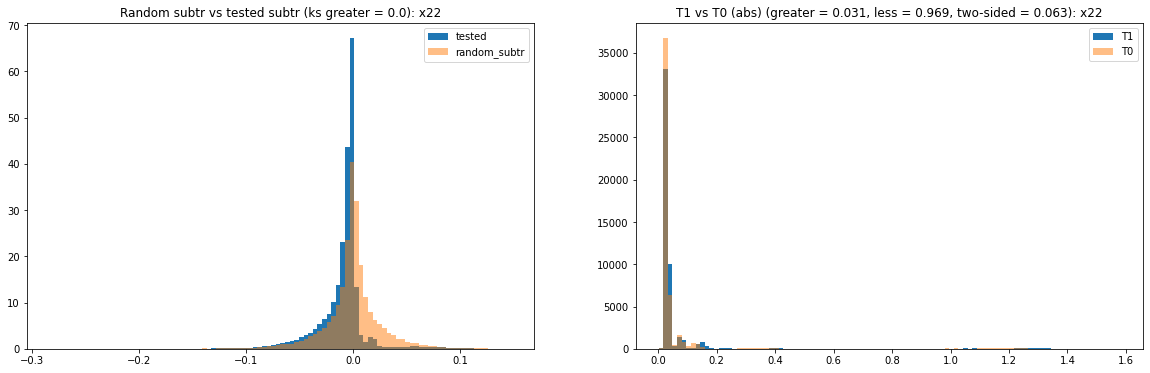

-0.00459206216497382
-0.0023548798852193013
old
Ttest_indResult(statistic=-2.4879767403497532, pvalue=0.01284883102177673)
new
Ttest_indResult(statistic=-1.2121041214135146, pvalue=0.22547539358912977)


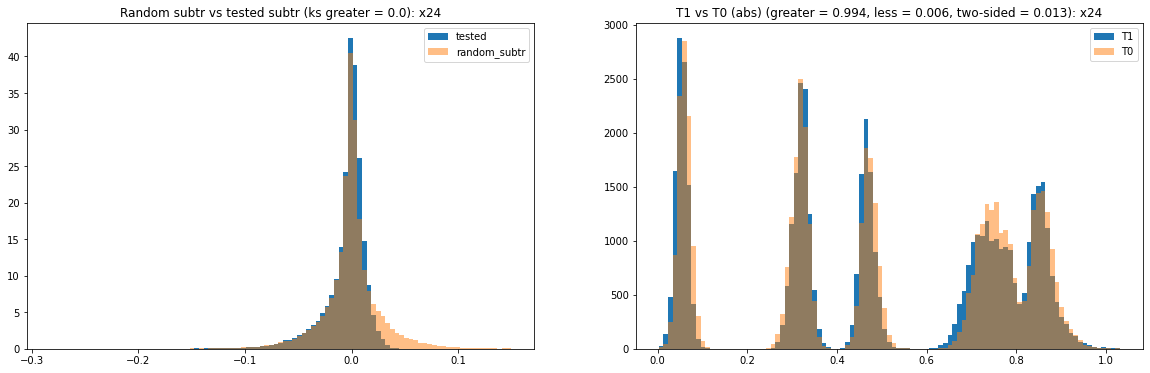

0.25425515058940495
-0.0023548798852193013
old
Ttest_indResult(statistic=224.96198690941586, pvalue=0.0)
new
Ttest_indResult(statistic=227.045557121008, pvalue=0.0)


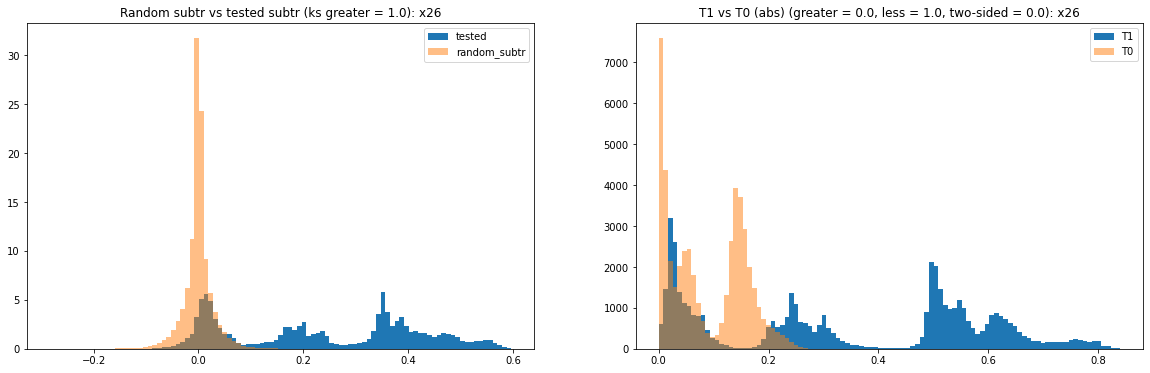

0.3482682864619509
-0.0023548798852193013
old
Ttest_indResult(statistic=168.01906809979786, pvalue=0.0)
new
Ttest_indResult(statistic=169.15515984051027, pvalue=0.0)


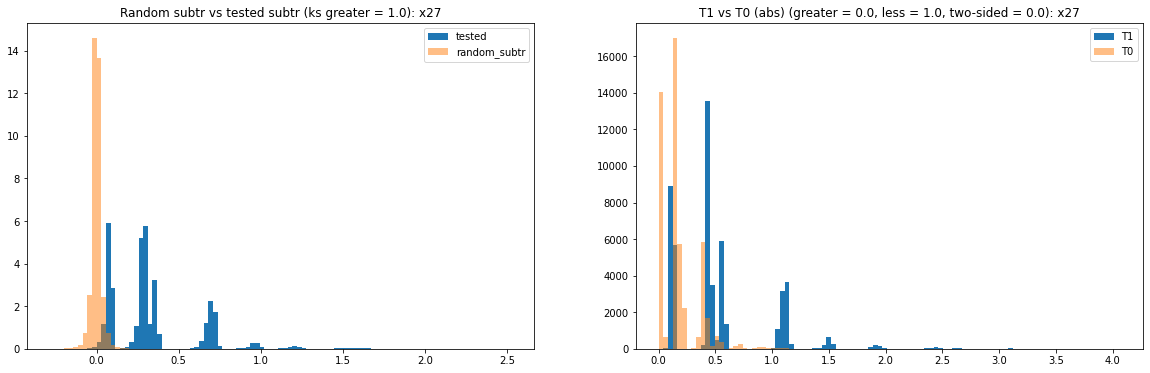

0.4348881462134019
-0.0023548798852193013
old
Ttest_indResult(statistic=163.48379295924275, pvalue=0.0)
new
Ttest_indResult(statistic=164.36904287683922, pvalue=0.0)


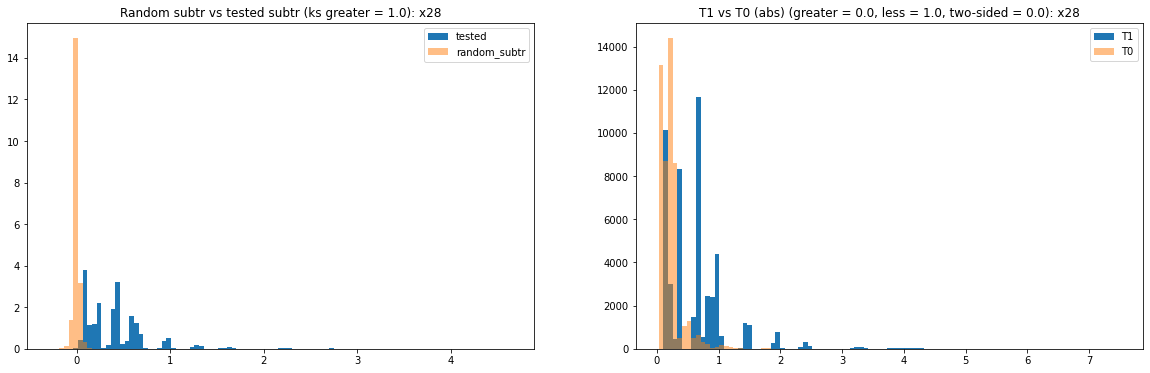

-0.0018333683019025326
-0.0023548798852193013
old
Ttest_indResult(statistic=-2.799142152588665, pvalue=0.005124840464247041)
new
Ttest_indResult(statistic=0.7962312070140724, pvalue=0.42589955568438564)


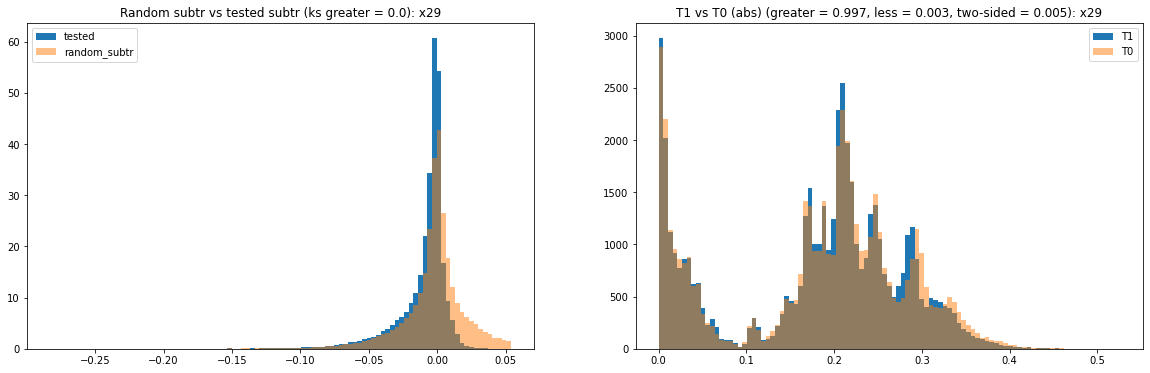

-0.007224324431705537
-0.0023548798852193013
old
Ttest_indResult(statistic=-6.610084426622751, pvalue=3.8602411584850456e-11)
new
Ttest_indResult(statistic=-4.455425537337465, pvalue=8.381776064427583e-06)


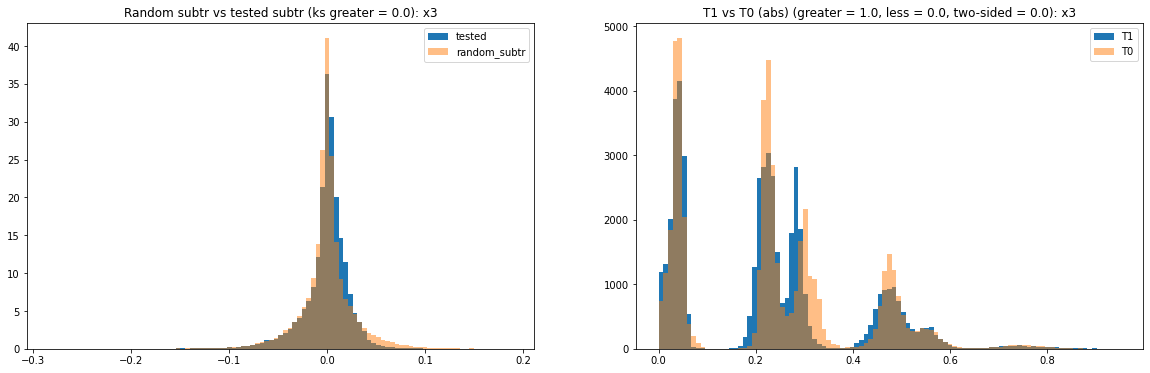

-0.0007699125884453872
-0.0023548798852193013
old
Ttest_indResult(statistic=-0.17690870539761044, pvalue=0.8595804592652139)
new
Ttest_indResult(statistic=0.3641900610249552, pvalue=0.7157168592184322)


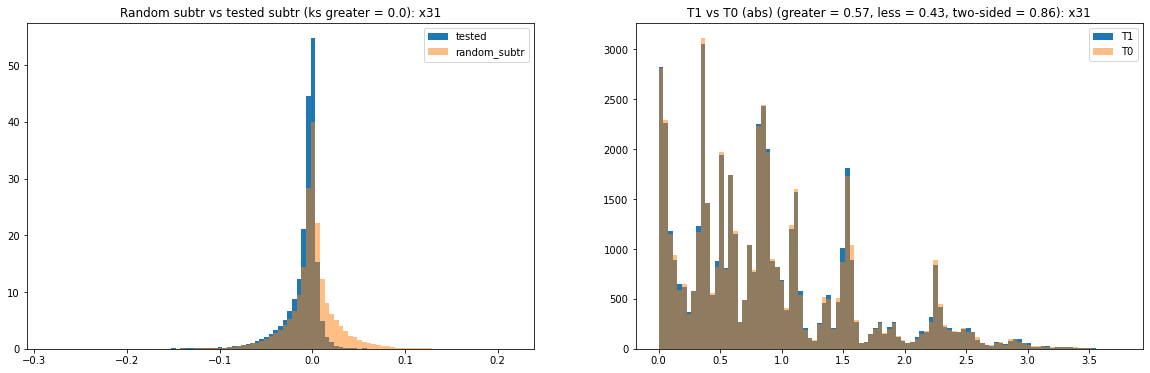

-0.04155992676358694
-0.0023548798852193013
old
Ttest_indResult(statistic=-21.26919548234953, pvalue=3.807060424740521e-100)
new
Ttest_indResult(statistic=-20.064034537261772, pvalue=2.3593969902339194e-89)


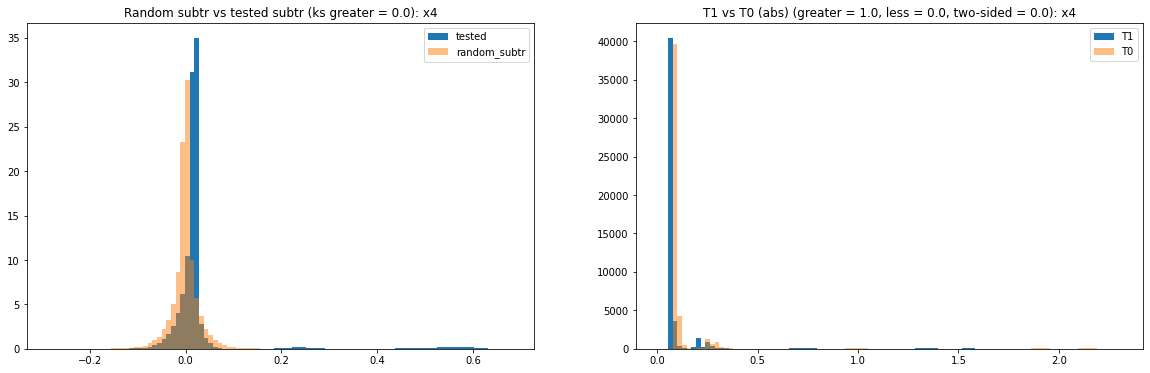

0.018964299721530603
-0.0023548798852193013
old
Ttest_indResult(statistic=7.267780024395789, pvalue=3.6810740329490453e-13)
new
Ttest_indResult(statistic=8.170251997574827, pvalue=3.113094620032939e-16)


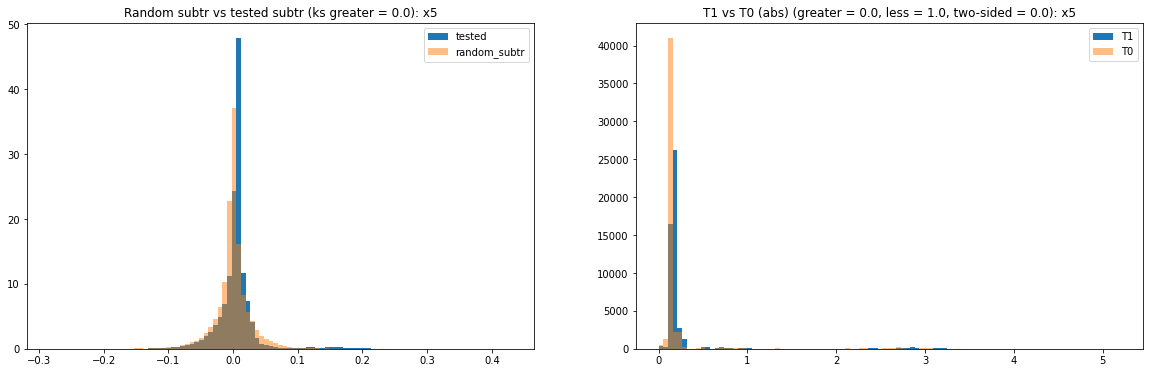

-0.04265304424765881
-0.0023548798852193013
old
Ttest_indResult(statistic=-10.58695474552781, pvalue=3.537098508321896e-26)
new
Ttest_indResult(statistic=-10.00244765545442, pvalue=1.5252949433092945e-23)


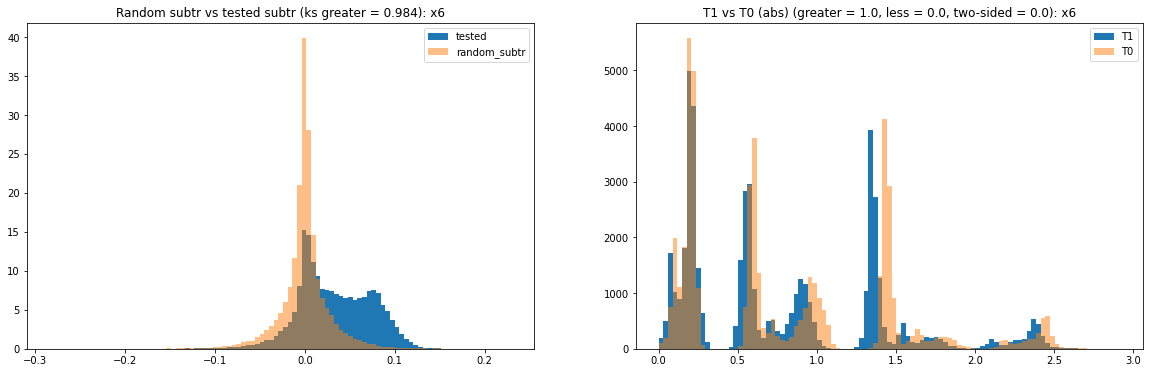

0.036999130380307055
-0.0023548798852193013
old
Ttest_indResult(statistic=53.839850239735206, pvalue=0.0)
new
Ttest_indResult(statistic=57.2665897076513, pvalue=0.0)


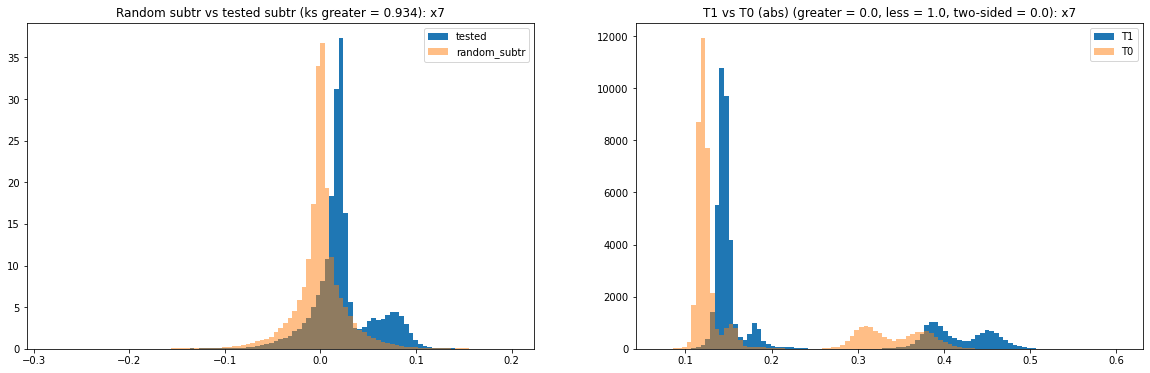

0.0039572277901767094
-0.0023548798852193013
old
Ttest_indResult(statistic=0.13756977148487662, pvalue=0.8905807244975588)
new
Ttest_indResult(statistic=0.21943523510274288, pvalue=0.8263114735676835)


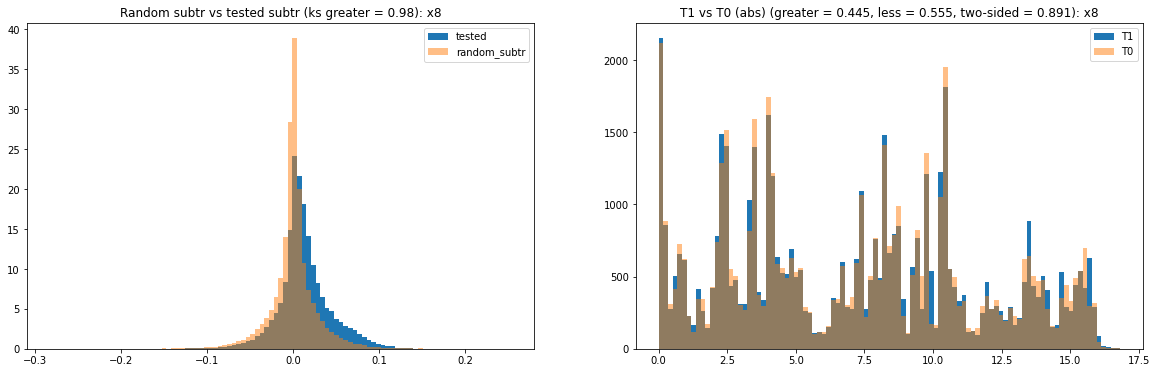

0.1081978778624178
-0.0023548798852193013
old
Ttest_indResult(statistic=57.85507801369176, pvalue=0.0)
new
Ttest_indResult(statistic=59.11426869435812, pvalue=0.0)


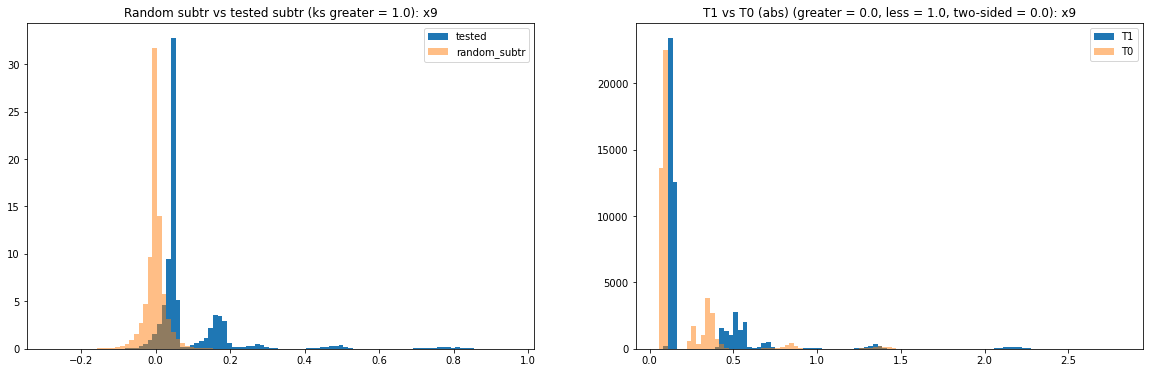

In [260]:
plot_bins = 100#100

print("True predictive vars: " +str(ground_truth_pred_features))
print("Found predictive vars: " +str(predictive_vars))
print("Found candidate vars: " +str(candidate_vars))

for i in range(len(feature_set_pred)-2):

        p_value_is_not_greater = np.round(
                st.kstest(
                # (np.abs(pred_matrix_list[:,-1])-np.abs(prog_matrix_list[:,-1])),
                (np.abs(pred_matrix_list[:,i])-np.abs(pred_matrix_list[:,-1])),
                (np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1])),
                alternative='greater'
            )[1],3

        )

        # p_value_kstest_less = np.round(
        #         st.kstest(
        #         (np.abs(pred_matrix_list[:,i])-np.abs(pred_matrix_list[:,-1])),
        #         (np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1])),
        #         alternative='less'
        #     )[1],3
        # )

        # p_value_kstest_two_sided = np.round(
        #         st.kstest(
        #         (np.abs(pred_matrix_list[:,i])-np.abs(pred_matrix_list[:,-1])),
        #         (np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1])),
        #         alternative='two-sided'
        #     )[1],3
        # )


        # print(ttost_paired(
        #         np.abs(T1_matrix_list[:,i]),
        #         np.abs(prog_matrix_list[:,i]),
        #         np.quantile(np.abs(T1_matrix_list[:,-1]) - np.abs(prog_matrix_list[:,-1]),significance_factor/2),np.quantile(np.abs(T1_matrix_list[:,-1]) - np.abs(prog_matrix_list[:,-1]),1-significance_factor/2)
        # ))

        p_value_ttest = np.round(
                st.ttest_ind(
                np.abs(T1_matrix_list[:,i]),
                np.abs(prog_matrix_list[:,i]),
                equal_var = False,
                alternative='greater'
                )[1],3
                )
        
        
        p_value_ttest_less = np.round(
                st.ttest_ind(
                np.abs(T1_matrix_list[:,i]),
                np.abs(prog_matrix_list[:,i]),
                equal_var = False,
                alternative='less'
                )[1],3
                )
        
        p_value_ttest_two_side = np.round(
                st.ttest_ind(
                np.abs(T1_matrix_list[:,i]),
                np.abs(prog_matrix_list[:,i]),
                equal_var = False,
                alternative='two-sided'
                )[1],3
                )

        # print(np.mean(np.abs(T1_matrix_list[:,i])) - np.mean(np.abs(prog_matrix_list[:,i])))
        # print(mean_diff_random)
        # print("old")
        # print(st.ttest_ind(
        #         np.abs(T1_matrix_list[:,i]),
        #         np.abs(prog_matrix_list[:,i]),
        #         equal_var = False,
        #         alternative='two-sided'
        #         ))
        # print("new")
        # print(st.ttest_ind(
        #         np.abs(T1_matrix_list[:,i]) - mean_diff_random,
        #         np.abs(prog_matrix_list[:,i]),
        #         equal_var = False,
        #         alternative='two-sided'
        #         ))

        plot_1_max = np.max(np.abs(pred_matrix_list[:-1,i])-np.abs(pred_matrix_list[:-1,-1]))
        plot_1_min = np.min(np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1]))

        fig, axs = plt.subplots(1,2,figsize=(20,6))
        array_tested = axs[0].hist(np.abs(pred_matrix_list[:-1,i])-np.abs(pred_matrix_list[:-1,-1]),label="tested",bins=np.arange(plot_1_min,plot_1_max,(plot_1_max-plot_1_min)/plot_bins),density=True)
        array_random = axs[0].hist(np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1]),label="random_subtr",alpha=0.5,bins=np.arange(plot_1_min,plot_1_max,(plot_1_max-plot_1_min)/plot_bins),density=True)
        axs[0].legend()
        axs[0].set_title("Random subtr vs tested subtr (ks greater = "+str(p_value_is_not_greater)+"): "+feature_set_pred[i])
        
        # array_feature = np.append(np.append(array_tested[0],array_random[0]),[1 if feature_set_pred[i] in predictive_vars else 0])
        # hist_dataset_df = pd.concat([hist_dataset_df,pd.DataFrame([array_feature],columns=colum_features)])

        plot_2_max = np.max(np.abs(T1_matrix_list[:,i]))
        plot_2_min = np.min(np.abs(prog_matrix_list[:,i]))

        axs[1].hist(np.abs(T1_matrix_list[:,i]),label="T1",bins=np.arange(plot_2_min,plot_2_max,(plot_2_max-plot_2_min)/plot_bins))
        axs[1].hist(np.abs(prog_matrix_list[:,i]),label="T0",alpha=0.5,bins=np.arange(plot_2_min,plot_2_max,(plot_2_max-plot_2_min)/plot_bins))
        axs[1].legend()
        axs[1].set_title("T1 vs T0 (abs) (greater = "+str(p_value_ttest)+", less = "+str(p_value_ttest_less)+", two-sided = "+str(p_value_ttest_two_side)+"): " + feature_set_pred[i])

        # plot_3_max = np.quantile(T1_matrix_list[:,i],0.98)
        # plot_3_min = np.quantile(T1_matrix_list[:,i],0.02)

        # axs[2].hist(T1_matrix_list[:,i],label="T1",bins=np.arange(plot_3_min,plot_3_max,(plot_3_max-plot_3_min)/50))
        # axs[2].hist(prog_matrix_list[:,i],label="T0",alpha=0.5,bins=np.arange(plot_3_min,plot_3_max,(plot_3_max-plot_3_min)/50))
        # axs[2].legend()
        # axs[2].set_title("T1 vs T0 (ttest greater = "+str(p_value_ttest_noabs)+"): " + feature_set_pred[i])

        plt.show()

In [214]:
np.quantile(np.abs(T1_matrix_list[:,-1]) - np.abs(prog_matrix_list[:,-1]),significance_factor/2),np.quantile(np.abs(T1_matrix_list[:,-1]) - np.abs(prog_matrix_list[:,-1]),1-significance_factor/2)

(-0.9307047411763351, 0.9492527797782131)

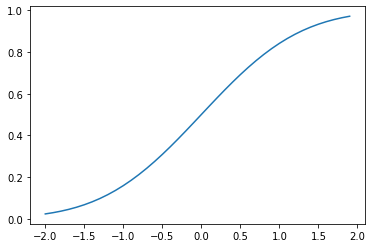

In [239]:
plt.plot(np.arange(-2,2,0.1),st.nct.cdf(np.arange(-2,2,0.1),10000,np.mean(np.abs(T1_matrix_list[:,-1]) - np.abs(prog_matrix_list[:,-1]) )))

In [218]:
diff_random_distr = T1_matrix_list[:,-1]-prog_matrix_list[:,-1]
diff_random_distr_normalized = (diff_random_distr - np.mean(diff_random_distr)) / np.std(diff_random_distr)


np.quantile(diff_random_distr_normalized,significance_factor/2),np.quantile(diff_random_distr_normalized,1-significance_factor/2)

(-1.9029638628694725, 1.5196783570515724)

In [225]:
T1_normalized = (np.abs(T1_matrix_list[:,i]) - np.mean(np.abs(T1_matrix_list[:,i])-np.abs(prog_matrix_list[:,i])))/(np.std(np.abs(T1_matrix_list[:,i])-np.abs(prog_matrix_list[:,i])))
prog_normalized = (np.abs(prog_matrix_list[:,i]) - np.mean(np.abs(T1_matrix_list[:,i])-np.abs(prog_matrix_list[:,i])))/(np.std(np.abs(T1_matrix_list[:,i])-np.abs(prog_matrix_list[:,i])))

print(ttost_paired(
                T1_normalized,
                prog_normalized,
                np.quantile(diff_random_distr_normalized,significance_factor/2),np.quantile(diff_random_distr_normalized,1-significance_factor/2)
        ))

(0.0, (136.60589059486463, 0.0, 3499.0), (-65.85142515288902, 0.0, 3499.0))


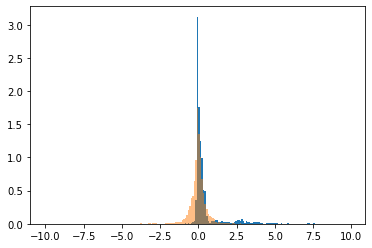

In [233]:
plt.hist(T1_normalized - prog_normalized,bins=np.arange(-10,10,0.1),density=True)
plt.hist(diff_random_distr_normalized,bins=np.arange(-10,10,0.1),density=True,alpha=0.5)
plt.show()